In [27]:
from dataloader import *
from models import CustomUnet
from train import train_all
import torch.nn as nn
from loss import WeightedBinaryCrossEntropyLoss
import matplotlib.pyplot as plt

In [12]:
train_dataloader = getDataloader(mode='train', augment=True)

loading annotations into memory...
Done (t=15.76s)
creating index...
index created!


In [13]:
model = CustomUnet
model = model()
n_epochs = 100

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(f"Device used :{device}")

Device used :cuda


In [15]:
trained_model = train_all(model, n_epochs, train_dataloader)

EPOCH 1:


101it [00:13,  7.29it/s]

  batch 100 loss: 0.7340804535150528


201it [00:27,  7.27it/s]

  batch 200 loss: 0.68916359603405


301it [00:41,  6.76it/s]

  batch 300 loss: 0.6504191544651985


401it [00:55,  7.04it/s]

  batch 400 loss: 0.5634414809942245


501it [01:10,  6.95it/s]

  batch 500 loss: 0.7187527266144752


601it [01:24,  6.82it/s]

  batch 600 loss: 0.5513521403074264


701it [01:39,  6.76it/s]

  batch 700 loss: 0.5146861307322979


801it [01:53,  6.73it/s]

  batch 800 loss: 0.5768556915223598


901it [02:08,  6.69it/s]

  batch 900 loss: 0.5820803020894527


1001it [02:23,  6.63it/s]

  batch 1000 loss: 0.5642052945494652


1101it [02:38,  6.69it/s]

  batch 1100 loss: 0.4844018688797951


1201it [02:53,  6.67it/s]

  batch 1200 loss: 0.7045292100310325


1301it [03:08,  6.73it/s]

  batch 1300 loss: 0.43120081782341


1401it [03:23,  6.77it/s]

  batch 1400 loss: 0.4432949139177799


1501it [03:38,  6.80it/s]

  batch 1500 loss: 0.5464002932608127


1601it [03:52,  6.87it/s]

  batch 1600 loss: 0.8988373248279095


1701it [04:07,  6.85it/s]

  batch 1700 loss: 0.571612938940525


1801it [04:22,  6.89it/s]

  batch 1800 loss: 0.7380903428792953


1901it [04:36,  6.86it/s]

  batch 1900 loss: 0.5905028462409974


2001it [04:51,  6.86it/s]

  batch 2000 loss: 0.49483717247843745


2101it [05:05,  6.86it/s]

  batch 2100 loss: 0.6327000799775123


2201it [05:20,  6.81it/s]

  batch 2200 loss: 0.4540886287391186


2301it [05:34,  6.88it/s]

  batch 2300 loss: 0.5389117127656937


2401it [05:49,  6.91it/s]

  batch 2400 loss: 1.000394822359085


2501it [06:03,  6.92it/s]

  batch 2500 loss: 0.7297851927578449


2601it [06:18,  6.94it/s]

  batch 2600 loss: 0.543798114657402


2701it [06:32,  6.90it/s]

  batch 2700 loss: 0.587246550321579


2801it [06:47,  6.96it/s]

  batch 2800 loss: 0.528132211714983


2901it [07:01,  6.96it/s]

  batch 2900 loss: 0.5048070967197418


3001it [07:15,  6.95it/s]

  batch 3000 loss: 0.48456669092178345


3101it [07:30,  6.99it/s]

  batch 3100 loss: 0.5455862262845039


3201it [07:44,  6.99it/s]

  batch 3200 loss: 0.5112134622037411


3301it [07:58,  6.96it/s]

  batch 3300 loss: 0.5009110917150974


3401it [08:13,  6.87it/s]

  batch 3400 loss: 0.5075704458355904


3501it [08:27,  7.03it/s]

  batch 3500 loss: 0.8388119903206825


3601it [08:41,  6.97it/s]

  batch 3600 loss: 0.5181909120082855


3701it [08:56,  6.95it/s]

  batch 3700 loss: 0.4568668156862259


3801it [09:10,  7.00it/s]

  batch 3800 loss: 0.599483890235424


3901it [09:25,  6.94it/s]

  batch 3900 loss: 0.5050350672006607


4001it [09:39,  6.99it/s]

  batch 4000 loss: 0.5408460694551468


4101it [09:53,  7.04it/s]

  batch 4100 loss: 0.710044836550951


4201it [10:07,  6.97it/s]

  batch 4200 loss: 0.45388369023799896


4262it [10:16,  6.91it/s]


LOSS train 0.45388369023799896
EPOCH 2:


101it [00:14,  6.92it/s]

  batch 100 loss: 0.5297903475165368


201it [00:28,  6.99it/s]

  batch 200 loss: 0.6445212791860103


301it [00:43,  6.93it/s]

  batch 300 loss: 0.6277399241924286


401it [00:57,  6.94it/s]

  batch 400 loss: 0.5173349969089032


501it [01:11,  6.98it/s]

  batch 500 loss: 0.7325367856025696


601it [01:26,  6.94it/s]

  batch 600 loss: 0.5415907749533653


701it [01:40,  6.99it/s]

  batch 700 loss: 0.5125161373615265


801it [01:54,  6.91it/s]

  batch 800 loss: 0.5649057479202747


901it [02:09,  6.94it/s]

  batch 900 loss: 0.5719411715865135


1001it [02:23,  6.91it/s]

  batch 1000 loss: 0.5661868935823441


1101it [02:37,  6.98it/s]

  batch 1100 loss: 0.47449096411466596


1201it [02:52,  7.02it/s]

  batch 1200 loss: 0.7057747961580754


1301it [03:06,  6.99it/s]

  batch 1300 loss: 0.4234262880682945


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.44336244463920593


1501it [03:35,  6.87it/s]

  batch 1500 loss: 0.5369395087659359


1601it [03:49,  7.01it/s]

  batch 1600 loss: 0.9028494301438331


1701it [04:04,  6.99it/s]

  batch 1700 loss: 0.5824252437055111


1801it [04:18,  7.03it/s]

  batch 1800 loss: 0.7399994361400605


1901it [04:32,  7.01it/s]

  batch 1900 loss: 0.5917120744287968


2001it [04:47,  6.92it/s]

  batch 2000 loss: 0.4991957195103168


2101it [05:01,  7.02it/s]

  batch 2100 loss: 0.6432028558850288


2201it [05:15,  6.98it/s]

  batch 2200 loss: 0.4538870045542717


2301it [05:29,  6.92it/s]

  batch 2300 loss: 0.5404003177583218


2401it [05:44,  6.99it/s]

  batch 2400 loss: 0.9833144563436508


2501it [05:58,  6.98it/s]

  batch 2500 loss: 0.7329330013692379


2601it [06:12,  6.97it/s]

  batch 2600 loss: 0.5215212872624397


2701it [06:27,  6.98it/s]

  batch 2700 loss: 0.5842573319375515


2801it [06:41,  6.99it/s]

  batch 2800 loss: 0.5192107826471328


2901it [06:55,  6.96it/s]

  batch 2900 loss: 0.5042411190271378


3001it [07:10,  6.93it/s]

  batch 3000 loss: 0.4768531511723995


3101it [07:24,  6.86it/s]

  batch 3100 loss: 0.5587355199456215


3201it [07:38,  7.03it/s]

  batch 3200 loss: 0.5087523496150971


3301it [07:53,  7.03it/s]

  batch 3300 loss: 0.4882428948581219


3401it [08:07,  7.03it/s]

  batch 3400 loss: 0.505601272135973


3501it [08:21,  7.01it/s]

  batch 3500 loss: 0.8359938004612922


3601it [08:36,  6.92it/s]

  batch 3600 loss: 0.5160124009847641


3701it [08:50,  7.00it/s]

  batch 3700 loss: 0.44167759254574773


3801it [09:04,  7.00it/s]

  batch 3800 loss: 0.5857612954080105


3901it [09:18,  6.96it/s]

  batch 3900 loss: 0.48866583555936816


4001it [09:33,  6.96it/s]

  batch 4000 loss: 0.5359613859653473


4101it [09:47,  7.05it/s]

  batch 4100 loss: 0.7144680404663086


4201it [10:01,  7.02it/s]

  batch 4200 loss: 0.4492863954603672


4262it [10:10,  6.98it/s]


LOSS train 0.4492863954603672
EPOCH 3:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.5241939648985863


201it [00:28,  7.01it/s]

  batch 200 loss: 0.6483141689002514


301it [00:43,  7.01it/s]

  batch 300 loss: 0.6320389702916145


401it [00:57,  6.94it/s]

  batch 400 loss: 0.5249257212877274


501it [01:11,  7.03it/s]

  batch 500 loss: 0.740255047827959


601it [01:25,  6.93it/s]

  batch 600 loss: 0.5327497287094594


701it [01:40,  6.97it/s]

  batch 700 loss: 0.5069675989449024


801it [01:54,  7.04it/s]

  batch 800 loss: 0.5664559786021709


901it [02:08,  6.98it/s]

  batch 900 loss: 0.5694442580640316


1001it [02:23,  6.95it/s]

  batch 1000 loss: 0.5598330855369568


1101it [02:37,  6.97it/s]

  batch 1100 loss: 0.4678975759446621


1201it [02:51,  6.96it/s]

  batch 1200 loss: 0.7121743793785572


1301it [03:06,  6.95it/s]

  batch 1300 loss: 0.41902918338775635


1401it [03:20,  6.96it/s]

  batch 1400 loss: 0.4427195207774639


1501it [03:35,  6.95it/s]

  batch 1500 loss: 0.5362434832751751


1601it [03:49,  7.03it/s]

  batch 1600 loss: 0.8648820948600769


1701it [04:03,  6.99it/s]

  batch 1700 loss: 0.5763356228172779


1801it [04:17,  7.04it/s]

  batch 1800 loss: 0.7191792181134224


1901it [04:32,  7.05it/s]

  batch 1900 loss: 0.5792064067721366


2001it [04:46,  7.02it/s]

  batch 2000 loss: 0.49881409913301467


2101it [05:00,  6.98it/s]

  batch 2100 loss: 0.6401228255033493


2201it [05:15,  6.94it/s]

  batch 2200 loss: 0.4521576768159866


2301it [05:29,  6.91it/s]

  batch 2300 loss: 0.538314965069294


2401it [05:43,  6.89it/s]

  batch 2400 loss: 0.9779773354530334


2501it [05:58,  6.96it/s]

  batch 2500 loss: 0.7279871936142445


2601it [06:12,  7.01it/s]

  batch 2600 loss: 0.5118993569910526


2701it [06:27,  7.04it/s]

  batch 2700 loss: 0.5821622291207313


2801it [06:41,  6.95it/s]

  batch 2800 loss: 0.5221670070290565


2901it [06:55,  7.02it/s]

  batch 2900 loss: 0.5036530514061451


3001it [07:10,  6.97it/s]

  batch 3000 loss: 0.4768556171655655


3101it [07:24,  6.96it/s]

  batch 3100 loss: 0.5515066136419773


3201it [07:38,  6.88it/s]

  batch 3200 loss: 0.501938144415617


3301it [07:53,  6.89it/s]

  batch 3300 loss: 0.49609890699386594


3401it [08:07,  6.87it/s]

  batch 3400 loss: 0.5094503247737885


3501it [08:22,  6.97it/s]

  batch 3500 loss: 0.8266942094266415


3601it [08:36,  6.97it/s]

  batch 3600 loss: 0.5218918277323246


3701it [08:50,  6.94it/s]

  batch 3700 loss: 0.4353715631365776


3801it [09:05,  6.95it/s]

  batch 3800 loss: 0.5929124081134796


3901it [09:19,  6.98it/s]

  batch 3900 loss: 0.49672148391604426


4001it [09:34,  6.96it/s]

  batch 4000 loss: 0.5372239011526108


4101it [09:48,  7.00it/s]

  batch 4100 loss: 0.6906451487541199


4201it [10:02,  6.96it/s]

  batch 4200 loss: 0.4494677859544754


4262it [10:11,  6.97it/s]


LOSS train 0.4494677859544754
EPOCH 4:


101it [00:14,  6.97it/s]

  batch 100 loss: 0.5224455128610134


201it [00:28,  7.01it/s]

  batch 200 loss: 0.6332703804969788


301it [00:43,  6.91it/s]

  batch 300 loss: 0.6252423277497292


401it [00:57,  6.97it/s]

  batch 400 loss: 0.5213389222323894


501it [01:11,  7.00it/s]

  batch 500 loss: 0.720715676099062


601it [01:26,  6.95it/s]

  batch 600 loss: 0.5288313412666321


701it [01:40,  6.94it/s]

  batch 700 loss: 0.5005318707227707


801it [01:54,  6.99it/s]

  batch 800 loss: 0.5500864718854427


901it [02:09,  6.98it/s]

  batch 900 loss: 0.5514795762300492


1001it [02:23,  6.92it/s]

  batch 1000 loss: 0.5450912918150425


1101it [02:38,  6.96it/s]

  batch 1100 loss: 0.46806343629956243


1201it [02:52,  6.93it/s]

  batch 1200 loss: 0.6863117651641368


1301it [03:06,  6.91it/s]

  batch 1300 loss: 0.4167672915756702


1401it [03:21,  6.99it/s]

  batch 1400 loss: 0.44276384174823763


1501it [03:35,  6.88it/s]

  batch 1500 loss: 0.5309673745930195


1601it [03:50,  6.92it/s]

  batch 1600 loss: 0.8933768670260906


1701it [04:04,  7.00it/s]

  batch 1700 loss: 0.5612325857579709


1801it [04:18,  7.01it/s]

  batch 1800 loss: 0.7223290131986141


1901it [04:33,  6.98it/s]

  batch 1900 loss: 0.5708274920284748


2001it [04:47,  6.99it/s]

  batch 2000 loss: 0.4941778828203678


2101it [05:01,  6.95it/s]

  batch 2100 loss: 0.6237055017054081


2201it [05:16,  6.95it/s]

  batch 2200 loss: 0.44990790769457817


2301it [05:30,  6.89it/s]

  batch 2300 loss: 0.5294307000935078


2401it [05:45,  6.96it/s]

  batch 2400 loss: 0.970033171325922


2501it [05:59,  6.92it/s]

  batch 2500 loss: 0.7035020057857037


2601it [06:13,  6.98it/s]

  batch 2600 loss: 0.5227461534738541


2701it [06:28,  6.99it/s]

  batch 2700 loss: 0.5793075321614742


2801it [06:42,  6.86it/s]

  batch 2800 loss: 0.5153259199857712


2901it [06:56,  7.03it/s]

  batch 2900 loss: 0.5063950498402119


3001it [07:11,  6.94it/s]

  batch 3000 loss: 0.4816569350659847


3101it [07:25,  6.98it/s]

  batch 3100 loss: 0.5485167118906975


3201it [07:40,  6.93it/s]

  batch 3200 loss: 0.4974979893863201


3301it [07:54,  6.91it/s]

  batch 3300 loss: 0.48707470670342445


3401it [08:08,  6.91it/s]

  batch 3400 loss: 0.48522167578339576


3501it [08:23,  6.97it/s]

  batch 3500 loss: 0.8099155059456825


3601it [08:37,  6.91it/s]

  batch 3600 loss: 0.5069792367517948


3701it [08:51,  6.89it/s]

  batch 3700 loss: 0.4349189995229244


3801it [09:06,  6.98it/s]

  batch 3800 loss: 0.5803026805818081


3901it [09:20,  7.03it/s]

  batch 3900 loss: 0.48988084197044374


4001it [09:34,  6.98it/s]

  batch 4000 loss: 0.5303096450865269


4101it [09:49,  7.01it/s]

  batch 4100 loss: 0.6887367227673531


4201it [10:03,  6.99it/s]

  batch 4200 loss: 0.462292937040329


4262it [10:12,  6.96it/s]


LOSS train 0.462292937040329
EPOCH 5:


101it [00:14,  7.00it/s]

  batch 100 loss: 0.5202145226299763


201it [00:28,  7.04it/s]

  batch 200 loss: 0.6426715956628323


301it [00:43,  6.99it/s]

  batch 300 loss: 0.6199506284296512


401it [00:57,  7.00it/s]

  batch 400 loss: 0.5106881859898568


501it [01:11,  7.03it/s]

  batch 500 loss: 0.7140610472857952


601it [01:25,  7.01it/s]

  batch 600 loss: 0.524335822314024


701it [01:40,  6.92it/s]

  batch 700 loss: 0.4971584819257259


801it [01:54,  7.03it/s]

  batch 800 loss: 0.551493891775608


901it [02:08,  6.98it/s]

  batch 900 loss: 0.546703074425459


1001it [02:23,  6.99it/s]

  batch 1000 loss: 0.5373061770200729


1101it [02:37,  7.07it/s]

  batch 1100 loss: 0.47162292823195456


1201it [02:51,  7.00it/s]

  batch 1200 loss: 0.6935743674635887


1301it [03:06,  7.01it/s]

  batch 1300 loss: 0.41600606486201286


1401it [03:20,  6.95it/s]

  batch 1400 loss: 0.43485563397407534


1501it [03:34,  6.97it/s]

  batch 1500 loss: 0.5329207855463028


1601it [03:48,  7.05it/s]

  batch 1600 loss: 0.8786231717467308


1701it [04:03,  6.98it/s]

  batch 1700 loss: 0.559151014983654


1801it [04:17,  7.04it/s]

  batch 1800 loss: 0.7131709502637387


1901it [04:31,  6.96it/s]

  batch 1900 loss: 0.5641284769773484


2001it [04:46,  7.04it/s]

  batch 2000 loss: 0.4973333781957626


2101it [05:00,  6.99it/s]

  batch 2100 loss: 0.6163128112256527


2201it [05:14,  6.88it/s]

  batch 2200 loss: 0.45472629234194756


2301it [05:29,  6.95it/s]

  batch 2300 loss: 0.5345870822668075


2401it [05:43,  6.97it/s]

  batch 2400 loss: 0.9545081309974194


2501it [05:57,  7.02it/s]

  batch 2500 loss: 0.6911789165437221


2601it [06:12,  6.93it/s]

  batch 2600 loss: 0.515269855260849


2701it [06:26,  6.99it/s]

  batch 2700 loss: 0.5795898106694222


2801it [06:40,  6.98it/s]

  batch 2800 loss: 0.5137448725104332


2901it [06:54,  6.98it/s]

  batch 2900 loss: 0.5037054283916951


3001it [07:09,  7.01it/s]

  batch 3000 loss: 0.48083082005381583


3101it [07:23,  6.99it/s]

  batch 3100 loss: 0.5370356959104537


3201it [07:37,  7.06it/s]

  batch 3200 loss: 0.48805118203163145


3301it [07:52,  6.88it/s]

  batch 3300 loss: 0.4849234038591385


3401it [08:06,  7.03it/s]

  batch 3400 loss: 0.48525664538145064


3501it [08:20,  7.02it/s]

  batch 3500 loss: 0.8067712515592576


3601it [08:35,  6.96it/s]

  batch 3600 loss: 0.5025566108524799


3701it [08:49,  6.95it/s]

  batch 3700 loss: 0.4312302900850773


3801it [09:03,  7.03it/s]

  batch 3800 loss: 0.5613972580432892


3901it [09:18,  7.02it/s]

  batch 3900 loss: 0.48199003756046294


4001it [09:32,  6.95it/s]

  batch 4000 loss: 0.5345822289586067


4101it [09:46,  7.04it/s]

  batch 4100 loss: 0.6656618125736713


4201it [10:00,  6.94it/s]

  batch 4200 loss: 0.45098258525133134


4262it [10:09,  6.99it/s]


LOSS train 0.45098258525133134
EPOCH 6:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.5147308397293091


201it [00:28,  7.03it/s]

  batch 200 loss: 0.6415928307175637


301it [00:42,  6.97it/s]

  batch 300 loss: 0.6132451076805592


401it [00:57,  6.93it/s]

  batch 400 loss: 0.512040570229292


501it [01:11,  6.98it/s]

  batch 500 loss: 0.7014870980381965


601it [01:25,  7.03it/s]

  batch 600 loss: 0.5207961204648018


701it [01:40,  6.97it/s]

  batch 700 loss: 0.4936963753402233


801it [01:54,  7.05it/s]

  batch 800 loss: 0.5345411238074302


901it [02:08,  7.01it/s]

  batch 900 loss: 0.5368174809217453


1001it [02:23,  6.99it/s]

  batch 1000 loss: 0.5257284198701382


1101it [02:37,  7.00it/s]

  batch 1100 loss: 0.4631591339409351


1201it [02:51,  6.98it/s]

  batch 1200 loss: 0.6881949478387832


1301it [03:05,  6.94it/s]

  batch 1300 loss: 0.41797527581453325


1401it [03:20,  6.99it/s]

  batch 1400 loss: 0.4339483034610748


1501it [03:34,  6.92it/s]

  batch 1500 loss: 0.5275146445631981


1601it [03:48,  7.03it/s]

  batch 1600 loss: 0.890432869642973


1701it [04:03,  6.93it/s]

  batch 1700 loss: 0.562109109312296


1801it [04:17,  7.00it/s]

  batch 1800 loss: 0.7004116481542587


1901it [04:31,  6.92it/s]

  batch 1900 loss: 0.5563862803578377


2001it [04:46,  6.98it/s]

  batch 2000 loss: 0.49602144688367844


2101it [05:00,  6.86it/s]

  batch 2100 loss: 0.6179133887588978


2201it [05:15,  6.88it/s]

  batch 2200 loss: 0.4487530706822872


2301it [05:29,  6.94it/s]

  batch 2300 loss: 0.5210741850733757


2401it [05:43,  6.89it/s]

  batch 2400 loss: 0.9497889573872089


2501it [05:58,  6.93it/s]

  batch 2500 loss: 0.6986873263120651


2601it [06:12,  7.04it/s]

  batch 2600 loss: 0.5126528994739056


2701it [06:27,  7.03it/s]

  batch 2700 loss: 0.5746636691689492


2801it [06:41,  6.92it/s]

  batch 2800 loss: 0.513845967054367


2901it [06:55,  6.98it/s]

  batch 2900 loss: 0.5078870716691017


3001it [07:10,  6.94it/s]

  batch 3000 loss: 0.475909084379673


3101it [07:24,  6.97it/s]

  batch 3100 loss: 0.5352757088840008


3201it [07:38,  6.90it/s]

  batch 3200 loss: 0.4848657439649105


3301it [07:53,  6.94it/s]

  batch 3300 loss: 0.48598448768258096


3401it [08:07,  6.97it/s]

  batch 3400 loss: 0.48172505050897596


3501it [08:22,  6.96it/s]

  batch 3500 loss: 0.8015178443491459


3601it [08:36,  6.97it/s]

  batch 3600 loss: 0.5003283536434173


3701it [08:50,  6.96it/s]

  batch 3700 loss: 0.4279296487569809


3801it [09:05,  7.03it/s]

  batch 3800 loss: 0.5515035100281238


3901it [09:19,  7.02it/s]

  batch 3900 loss: 0.4879168127477169


4001it [09:33,  6.96it/s]

  batch 4000 loss: 0.5226917813718319


4101it [09:47,  6.98it/s]

  batch 4100 loss: 0.6595071570575237


4201it [10:02,  6.95it/s]

  batch 4200 loss: 0.45000305503606797


4262it [10:11,  6.98it/s]


LOSS train 0.45000305503606797
EPOCH 7:


101it [00:14,  6.98it/s]

  batch 100 loss: 0.5061732013523579


201it [00:28,  7.00it/s]

  batch 200 loss: 0.6265379865467549


301it [00:43,  7.03it/s]

  batch 300 loss: 0.618171063810587


401it [00:57,  6.95it/s]

  batch 400 loss: 0.5057123057544232


501it [01:11,  7.02it/s]

  batch 500 loss: 0.6950637356936932


601it [01:25,  6.93it/s]

  batch 600 loss: 0.5186469422280788


701it [01:40,  6.97it/s]

  batch 700 loss: 0.4910015867650509


801it [01:54,  7.03it/s]

  batch 800 loss: 0.5387138962745667


901it [02:08,  6.96it/s]

  batch 900 loss: 0.5287349964678287


1001it [02:23,  6.92it/s]

  batch 1000 loss: 0.5361557368934154


1101it [02:37,  7.03it/s]

  batch 1100 loss: 0.4571650575101376


1201it [02:51,  6.98it/s]

  batch 1200 loss: 0.6814029732346535


1301it [03:06,  7.06it/s]

  batch 1300 loss: 0.41520303606986997


1401it [03:20,  6.97it/s]

  batch 1400 loss: 0.4322932316362858


1501it [03:34,  6.92it/s]

  batch 1500 loss: 0.534840744137764


1601it [03:49,  7.02it/s]

  batch 1600 loss: 0.8801991125941276


1701it [04:03,  6.98it/s]

  batch 1700 loss: 0.5616704107820988


1801it [04:17,  7.04it/s]

  batch 1800 loss: 0.6999917875230313


1901it [04:31,  7.02it/s]

  batch 1900 loss: 0.5623118562996388


2001it [04:46,  7.01it/s]

  batch 2000 loss: 0.4891565153002739


2101it [05:00,  7.01it/s]

  batch 2100 loss: 0.6294664123654365


2201it [05:14,  6.98it/s]

  batch 2200 loss: 0.44424052447080614


2301it [05:28,  7.00it/s]

  batch 2300 loss: 0.5264969524741173


2401it [05:43,  7.04it/s]

  batch 2400 loss: 0.9402962996065617


2501it [05:57,  7.03it/s]

  batch 2500 loss: 0.6884681645035744


2601it [06:11,  7.04it/s]

  batch 2600 loss: 0.5088965341448783


2701it [06:25,  6.96it/s]

  batch 2700 loss: 0.5761067955195904


2801it [06:40,  6.97it/s]

  batch 2800 loss: 0.5099015353620052


2901it [06:54,  7.05it/s]

  batch 2900 loss: 0.5032377073168754


3001it [07:08,  6.95it/s]

  batch 3000 loss: 0.47640040159225466


3101it [07:23,  6.91it/s]

  batch 3100 loss: 0.5296942740678787


3201it [07:37,  6.97it/s]

  batch 3200 loss: 0.476611240953207


3301it [07:51,  6.95it/s]

  batch 3300 loss: 0.4849835047125816


3401it [08:06,  6.91it/s]

  batch 3400 loss: 0.4792573806643486


3501it [08:20,  7.02it/s]

  batch 3500 loss: 0.7962950840592384


3601it [08:34,  6.90it/s]

  batch 3600 loss: 0.49151357263326645


3701it [08:49,  6.86it/s]

  batch 3700 loss: 0.4260780695080757


3801it [09:03,  7.05it/s]

  batch 3800 loss: 0.5720828498899937


3901it [09:17,  7.03it/s]

  batch 3900 loss: 0.4846488459408283


4001it [09:32,  6.91it/s]

  batch 4000 loss: 0.5264629544317723


4101it [09:46,  7.04it/s]

  batch 4100 loss: 0.6771516652405262


4201it [10:00,  6.92it/s]

  batch 4200 loss: 0.44321063995361326


4262it [10:09,  6.99it/s]


LOSS train 0.44321063995361326
EPOCH 8:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.5016879384219647


201it [00:28,  7.04it/s]

  batch 200 loss: 0.6261038407683372


301it [00:43,  6.98it/s]

  batch 300 loss: 0.6118485675752163


401it [00:57,  6.98it/s]

  batch 400 loss: 0.5043669553101062


501it [01:11,  7.01it/s]

  batch 500 loss: 0.6966690261662006


601it [01:25,  6.93it/s]

  batch 600 loss: 0.513691343665123


701it [01:40,  6.94it/s]

  batch 700 loss: 0.4898264615237713


801it [01:54,  7.02it/s]

  batch 800 loss: 0.5342759892344475


901it [02:08,  6.97it/s]

  batch 900 loss: 0.530877473205328


1001it [02:23,  7.05it/s]

  batch 1000 loss: 0.5294754639267921


1101it [02:37,  7.03it/s]

  batch 1100 loss: 0.46024619847536086


1201it [02:51,  6.99it/s]

  batch 1200 loss: 0.6727555887401104


1301it [03:05,  7.04it/s]

  batch 1300 loss: 0.4196144066751003


1401it [03:20,  6.92it/s]

  batch 1400 loss: 0.43290851965546606


1501it [03:34,  6.96it/s]

  batch 1500 loss: 0.5260110014677047


1601it [03:49,  7.02it/s]

  batch 1600 loss: 0.8919640389084816


1701it [04:03,  6.93it/s]

  batch 1700 loss: 0.5560315838456154


1801it [04:17,  7.03it/s]

  batch 1800 loss: 0.7046095886826516


1901it [04:31,  7.04it/s]

  batch 1900 loss: 0.5630499510467053


2001it [04:46,  7.04it/s]

  batch 2000 loss: 0.49130558416247366


2101it [05:00,  7.02it/s]

  batch 2100 loss: 0.6202134090662003


2201it [05:14,  7.03it/s]

  batch 2200 loss: 0.43764486446976664


2301it [05:29,  6.97it/s]

  batch 2300 loss: 0.5237655632197857


2401it [05:43,  7.00it/s]

  batch 2400 loss: 0.9323778134584427


2501it [05:57,  7.02it/s]

  batch 2500 loss: 0.6898464420437813


2601it [06:11,  7.02it/s]

  batch 2600 loss: 0.5030728980898858


2701it [06:26,  6.99it/s]

  batch 2700 loss: 0.5703163021802902


2801it [06:40,  6.94it/s]

  batch 2800 loss: 0.5090705636143684


2901it [06:54,  7.04it/s]

  batch 2900 loss: 0.5032974138855935


3001it [07:09,  6.85it/s]

  batch 3000 loss: 0.4749421040713787


3101it [07:23,  7.01it/s]

  batch 3100 loss: 0.5290117236971855


3201it [07:37,  6.99it/s]

  batch 3200 loss: 0.475482784807682


3301it [07:52,  6.96it/s]

  batch 3300 loss: 0.4843040904402733


3401it [08:06,  6.94it/s]

  batch 3400 loss: 0.48203896403312685


3501it [08:20,  7.01it/s]

  batch 3500 loss: 0.7975361227989197


3601it [08:35,  7.00it/s]

  batch 3600 loss: 0.4982192076742649


3701it [08:49,  7.00it/s]

  batch 3700 loss: 0.42430212497711184


3801it [09:03,  7.01it/s]

  batch 3800 loss: 0.5528015637397766


3901it [09:17,  7.03it/s]

  batch 3900 loss: 0.4846650776267052


4001it [09:32,  6.98it/s]

  batch 4000 loss: 0.5222249925136566


4101it [09:46,  7.02it/s]

  batch 4100 loss: 0.6563235001266002


4201it [10:00,  6.97it/s]

  batch 4200 loss: 0.44808116599917414


4262it [10:09,  6.99it/s]


LOSS train 0.44808116599917414
EPOCH 9:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.4975428631901741


201it [00:28,  7.02it/s]

  batch 200 loss: 0.6133414554595947


301it [00:43,  6.88it/s]

  batch 300 loss: 0.6168280154466629


401it [00:57,  6.93it/s]

  batch 400 loss: 0.5060823890566826


501it [01:11,  7.00it/s]

  batch 500 loss: 0.6735943122208119


601it [01:26,  6.95it/s]

  batch 600 loss: 0.5141077426075935


701it [01:40,  6.90it/s]

  batch 700 loss: 0.48901458233594897


801it [01:55,  6.95it/s]

  batch 800 loss: 0.543802669942379


901it [02:09,  6.95it/s]

  batch 900 loss: 0.530725032389164


1001it [02:23,  6.94it/s]

  batch 1000 loss: 0.5303248110413551


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.4583086283504963


1201it [02:52,  6.91it/s]

  batch 1200 loss: 0.680462590008974


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.4156074573099613


1401it [03:21,  6.83it/s]

  batch 1400 loss: 0.43126487240195277


1501it [03:36,  6.89it/s]

  batch 1500 loss: 0.5397648894786835


1601it [03:50,  6.94it/s]

  batch 1600 loss: 0.8770087561011315


1701it [04:04,  6.86it/s]

  batch 1700 loss: 0.575261961966753


1801it [04:19,  6.94it/s]

  batch 1800 loss: 0.6845196180045605


1901it [04:33,  6.99it/s]

  batch 1900 loss: 0.5578978176414967


2001it [04:48,  6.95it/s]

  batch 2000 loss: 0.4897625355422497


2101it [05:02,  6.92it/s]

  batch 2100 loss: 0.6170235572755337


2201it [05:16,  6.93it/s]

  batch 2200 loss: 0.43618585646152497


2301it [05:31,  6.93it/s]

  batch 2300 loss: 0.517954848408699


2401it [05:45,  6.94it/s]

  batch 2400 loss: 0.9199882863461971


2501it [06:00,  6.95it/s]

  batch 2500 loss: 0.6882674960792065


2601it [06:14,  6.95it/s]

  batch 2600 loss: 0.5135765202343464


2701it [06:28,  6.97it/s]

  batch 2700 loss: 0.5752439327538014


2801it [06:43,  6.88it/s]

  batch 2800 loss: 0.5092939043045044


2901it [06:57,  6.83it/s]

  batch 2900 loss: 0.5002992896735668


3001it [07:12,  6.88it/s]

  batch 3000 loss: 0.47368619829416275


3101it [07:26,  6.94it/s]

  batch 3100 loss: 0.5196606382727623


3201it [07:40,  6.80it/s]

  batch 3200 loss: 0.4734038281440735


3301it [07:55,  6.87it/s]

  batch 3300 loss: 0.4789232939481735


3401it [08:09,  6.87it/s]

  batch 3400 loss: 0.48728014588356017


3501it [08:24,  6.97it/s]

  batch 3500 loss: 0.7960641978681088


3601it [08:38,  6.89it/s]

  batch 3600 loss: 0.49320783972740173


3701it [08:52,  6.95it/s]

  batch 3700 loss: 0.42314192533493045


3801it [09:07,  6.92it/s]

  batch 3800 loss: 0.5492462994158268


3901it [09:21,  6.93it/s]

  batch 3900 loss: 0.4833004260063171


4001it [09:36,  6.89it/s]

  batch 4000 loss: 0.5152315631508827


4101it [09:50,  6.95it/s]

  batch 4100 loss: 0.6557641085982323


4201it [10:04,  6.97it/s]

  batch 4200 loss: 0.45123202428221704


4262it [10:13,  6.95it/s]


LOSS train 0.45123202428221704
EPOCH 10:


101it [00:14,  6.88it/s]

  batch 100 loss: 0.4949181059002876


201it [00:29,  6.97it/s]

  batch 200 loss: 0.613281077593565


301it [00:43,  6.89it/s]

  batch 300 loss: 0.6034277018904686


401it [00:57,  6.94it/s]

  batch 400 loss: 0.5031438326835632


501it [01:12,  6.98it/s]

  batch 500 loss: 0.6701058946549893


601it [01:26,  6.86it/s]

  batch 600 loss: 0.5109273506700993


701it [01:41,  6.89it/s]

  batch 700 loss: 0.4820205603539944


801it [01:55,  6.97it/s]

  batch 800 loss: 0.5245553870499134


901it [02:09,  6.97it/s]

  batch 900 loss: 0.528015205860138


1001it [02:24,  6.95it/s]

  batch 1000 loss: 0.5277884787321091


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.46270873084664343


1201it [02:53,  6.95it/s]

  batch 1200 loss: 0.6839014849066735


1301it [03:07,  6.99it/s]

  batch 1300 loss: 0.4199580979347229


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.4393107470870018


1501it [03:36,  6.97it/s]

  batch 1500 loss: 0.530148207694292


1601it [03:50,  7.02it/s]

  batch 1600 loss: 0.8718079100549221


1701it [04:04,  6.87it/s]

  batch 1700 loss: 0.5596927751600742


1801it [04:19,  7.00it/s]

  batch 1800 loss: 0.6985460856556892


1901it [04:33,  6.95it/s]

  batch 1900 loss: 0.5596763056516647


2001it [04:48,  6.95it/s]

  batch 2000 loss: 0.487701963186264


2101it [05:02,  6.97it/s]

  batch 2100 loss: 0.620353652536869


2201it [05:16,  6.96it/s]

  batch 2200 loss: 0.4385095910727978


2301it [05:31,  6.94it/s]

  batch 2300 loss: 0.5237311838567257


2401it [05:45,  6.96it/s]

  batch 2400 loss: 0.9142149585485458


2501it [05:59,  6.96it/s]

  batch 2500 loss: 0.690716405659914


2601it [06:14,  7.01it/s]

  batch 2600 loss: 0.5070943669974803


2701it [06:28,  6.99it/s]

  batch 2700 loss: 0.5729050324857234


2801it [06:43,  6.96it/s]

  batch 2800 loss: 0.5105095994472504


2901it [06:57,  6.96it/s]

  batch 2900 loss: 0.49862245976924896


3001it [07:11,  6.95it/s]

  batch 3000 loss: 0.4734238490462303


3101it [07:26,  6.93it/s]

  batch 3100 loss: 0.5261204944550991


3201it [07:40,  6.95it/s]

  batch 3200 loss: 0.472739317715168


3301it [07:55,  6.89it/s]

  batch 3300 loss: 0.4805479109287262


3401it [08:09,  6.97it/s]

  batch 3400 loss: 0.4789065133035183


3501it [08:23,  6.94it/s]

  batch 3500 loss: 0.7846507041156292


3601it [08:38,  6.95it/s]

  batch 3600 loss: 0.49173699110746383


3701it [08:52,  6.87it/s]

  batch 3700 loss: 0.4270651441812515


3801it [09:06,  7.00it/s]

  batch 3800 loss: 0.541450487524271


3901it [09:21,  7.03it/s]

  batch 3900 loss: 0.48298842445015905


4001it [09:35,  6.96it/s]

  batch 4000 loss: 0.5183856229484082


4101it [09:49,  6.95it/s]

  batch 4100 loss: 0.6501503996551037


4201it [10:04,  6.96it/s]

  batch 4200 loss: 0.44832242503762243


4262it [10:12,  6.95it/s]


LOSS train 0.44832242503762243
EPOCH 11:


101it [00:14,  6.97it/s]

  batch 100 loss: 0.4956741036474705


201it [00:28,  7.04it/s]

  batch 200 loss: 0.6082905866205692


301it [00:43,  6.94it/s]

  batch 300 loss: 0.5966533164680005


401it [00:57,  7.01it/s]

  batch 400 loss: 0.5034040841460228


501it [01:11,  7.04it/s]

  batch 500 loss: 0.6632547661662102


601it [01:26,  7.02it/s]

  batch 600 loss: 0.510449388474226


701it [01:40,  6.96it/s]

  batch 700 loss: 0.48287546187639235


801it [01:54,  7.04it/s]

  batch 800 loss: 0.5217098519206047


901it [02:09,  6.95it/s]

  batch 900 loss: 0.5198610059916973


1001it [02:23,  6.96it/s]

  batch 1000 loss: 0.5258961114287376


1101it [02:37,  7.02it/s]

  batch 1100 loss: 0.45753846168518064


1201it [02:52,  7.02it/s]

  batch 1200 loss: 0.6724488580226898


1301it [03:06,  6.98it/s]

  batch 1300 loss: 0.42047232151031494


1401it [03:20,  6.97it/s]

  batch 1400 loss: 0.4353533634543419


1501it [03:35,  6.98it/s]

  batch 1500 loss: 0.5264743138849736


1601it [03:49,  7.03it/s]

  batch 1600 loss: 0.8727576676011085


1701it [04:03,  6.92it/s]

  batch 1700 loss: 0.563177259862423


1801it [04:18,  7.02it/s]

  batch 1800 loss: 0.7000584296882153


1901it [04:32,  7.01it/s]

  batch 1900 loss: 0.5599121089279652


2001it [04:46,  7.01it/s]

  batch 2000 loss: 0.48992070719599723


2101it [05:00,  6.96it/s]

  batch 2100 loss: 0.6077375519275665


2201it [05:15,  6.98it/s]

  batch 2200 loss: 0.4402990289032459


2301it [05:29,  6.95it/s]

  batch 2300 loss: 0.516892167031765


2401it [05:44,  6.90it/s]

  batch 2400 loss: 0.9007692781090736


2501it [05:58,  6.92it/s]

  batch 2500 loss: 0.6820133934915066


2601it [06:12,  7.05it/s]

  batch 2600 loss: 0.5114299122989178


2701it [06:27,  6.94it/s]

  batch 2700 loss: 0.5754952944815159


2801it [06:41,  6.96it/s]

  batch 2800 loss: 0.5030474084615707


2901it [06:55,  6.99it/s]

  batch 2900 loss: 0.49594815135002135


3001it [07:10,  6.98it/s]

  batch 3000 loss: 0.47374556556344033


3101it [07:24,  6.96it/s]

  batch 3100 loss: 0.5189660796523095


3201it [07:38,  6.99it/s]

  batch 3200 loss: 0.4721463568508625


3301it [07:53,  7.02it/s]

  batch 3300 loss: 0.4855850179493427


3401it [08:07,  6.94it/s]

  batch 3400 loss: 0.4823569013178349


3501it [08:21,  7.03it/s]

  batch 3500 loss: 0.7872043107450009


3601it [08:35,  7.00it/s]

  batch 3600 loss: 0.4921762879192829


3701it [08:50,  7.00it/s]

  batch 3700 loss: 0.4252334634959698


3801it [09:04,  7.01it/s]

  batch 3800 loss: 0.5458716014027596


3901it [09:18,  7.03it/s]

  batch 3900 loss: 0.48335536375641824


4001it [09:33,  6.97it/s]

  batch 4000 loss: 0.517334555387497


4101it [09:47,  7.04it/s]

  batch 4100 loss: 0.6473167137801648


4201it [10:01,  7.00it/s]

  batch 4200 loss: 0.44487699046730994


4262it [10:10,  6.98it/s]


LOSS train 0.44487699046730994
EPOCH 12:


101it [00:14,  6.84it/s]

  batch 100 loss: 0.5017616254091263


201it [00:28,  7.03it/s]

  batch 200 loss: 0.6093679764866828


301it [00:43,  6.99it/s]

  batch 300 loss: 0.5949827480316162


401it [00:57,  6.96it/s]

  batch 400 loss: 0.5003877024352551


501it [01:11,  6.95it/s]

  batch 500 loss: 0.6586196379363537


601it [01:26,  6.98it/s]

  batch 600 loss: 0.5001280908286572


701it [01:40,  7.00it/s]

  batch 700 loss: 0.484583850055933


801it [01:54,  6.94it/s]

  batch 800 loss: 0.5168839874863624


901it [02:09,  6.87it/s]

  batch 900 loss: 0.5086026233434677


1001it [02:23,  6.89it/s]

  batch 1000 loss: 0.5266300985217094


1101it [02:37,  7.03it/s]

  batch 1100 loss: 0.45466082960367205


1201it [02:52,  6.98it/s]

  batch 1200 loss: 0.6716448692977428


1301it [03:06,  6.97it/s]

  batch 1300 loss: 0.4226042342185974


1401it [03:20,  6.90it/s]

  batch 1400 loss: 0.43002717196941376


1501it [03:35,  6.90it/s]

  batch 1500 loss: 0.5241899108886718


1601it [03:49,  6.99it/s]

  batch 1600 loss: 0.8759850211441517


1701it [04:03,  6.87it/s]

  batch 1700 loss: 0.5564132462441921


1801it [04:18,  7.00it/s]

  batch 1800 loss: 0.6886906802654267


1901it [04:32,  6.98it/s]

  batch 1900 loss: 0.5614772628247738


2001it [04:46,  6.93it/s]

  batch 2000 loss: 0.49621683835983277


2101it [05:01,  6.96it/s]

  batch 2100 loss: 0.6096269106864929


2201it [05:15,  6.97it/s]

  batch 2200 loss: 0.44017571926116944


2301it [05:30,  6.96it/s]

  batch 2300 loss: 0.5148480123281479


2401it [05:44,  6.89it/s]

  batch 2400 loss: 0.8841107311844826


2501it [05:58,  6.98it/s]

  batch 2500 loss: 0.6749534313380718


2601it [06:13,  6.97it/s]

  batch 2600 loss: 0.5177394850552082


2701it [06:27,  6.93it/s]

  batch 2700 loss: 0.5833229950070381


2801it [06:42,  6.93it/s]

  batch 2800 loss: 0.4970721586048603


2901it [06:56,  6.96it/s]

  batch 2900 loss: 0.49749073296785357


3001it [07:10,  6.97it/s]

  batch 3000 loss: 0.46746548399329185


3101it [07:25,  6.95it/s]

  batch 3100 loss: 0.5189162793755532


3201it [07:39,  6.99it/s]

  batch 3200 loss: 0.4695453469455242


3301it [07:54,  6.85it/s]

  batch 3300 loss: 0.482867351770401


3401it [08:08,  6.97it/s]

  batch 3400 loss: 0.4805714592337608


3501it [08:22,  6.93it/s]

  batch 3500 loss: 0.7880553378164769


3601it [08:37,  6.94it/s]

  batch 3600 loss: 0.49213411450386046


3701it [08:51,  6.93it/s]

  batch 3700 loss: 0.4272216399013996


3801it [09:06,  7.00it/s]

  batch 3800 loss: 0.5456744693219662


3901it [09:20,  7.00it/s]

  batch 3900 loss: 0.4818141981959343


4001it [09:34,  6.90it/s]

  batch 4000 loss: 0.5168770837783814


4101it [09:49,  6.96it/s]

  batch 4100 loss: 0.6450268991291523


4201it [10:03,  6.96it/s]

  batch 4200 loss: 0.4461895939707756


4262it [10:12,  6.96it/s]


LOSS train 0.4461895939707756
EPOCH 13:


101it [00:14,  6.83it/s]

  batch 100 loss: 0.49551366150379184


201it [00:28,  7.05it/s]

  batch 200 loss: 0.6077495513856411


301it [00:43,  6.96it/s]

  batch 300 loss: 0.5969746643304825


401it [00:57,  6.96it/s]

  batch 400 loss: 0.49755862206220625


501it [01:12,  6.95it/s]

  batch 500 loss: 0.65068205550313


601it [01:26,  6.94it/s]

  batch 600 loss: 0.5019989751279355


701it [01:40,  6.93it/s]

  batch 700 loss: 0.48636287584900856


801it [01:55,  7.04it/s]

  batch 800 loss: 0.5183135023713112


901it [02:09,  6.97it/s]

  batch 900 loss: 0.514231243878603


1001it [02:23,  6.94it/s]

  batch 1000 loss: 0.5138212722539902


1101it [02:38,  7.02it/s]

  batch 1100 loss: 0.4604964157938957


1201it [02:52,  6.95it/s]

  batch 1200 loss: 0.6738097833096981


1301it [03:06,  6.98it/s]

  batch 1300 loss: 0.41989089757204057


1401it [03:21,  6.97it/s]

  batch 1400 loss: 0.4321319459378719


1501it [03:35,  6.99it/s]

  batch 1500 loss: 0.5206823390722275


1601it [03:49,  6.96it/s]

  batch 1600 loss: 0.8671116077899933


1701it [04:04,  6.87it/s]

  batch 1700 loss: 0.5506475524604321


1801it [04:18,  6.97it/s]

  batch 1800 loss: 0.6839418472349643


1901it [04:33,  6.81it/s]

  batch 1900 loss: 0.5582589642703533


2001it [04:47,  7.00it/s]

  batch 2000 loss: 0.4932980538904667


2101it [05:01,  6.98it/s]

  batch 2100 loss: 0.6033574032783509


2201it [05:16,  6.89it/s]

  batch 2200 loss: 0.43746123477816584


2301it [05:30,  6.92it/s]

  batch 2300 loss: 0.5128141665458679


2401it [05:45,  6.93it/s]

  batch 2400 loss: 0.8755599299073219


2501it [05:59,  6.95it/s]

  batch 2500 loss: 0.6764736573398114


2601it [06:13,  7.03it/s]

  batch 2600 loss: 0.5194373925030231


2701it [06:28,  7.03it/s]

  batch 2700 loss: 0.5772022370994091


2801it [06:42,  6.97it/s]

  batch 2800 loss: 0.5016691786050796


2901it [06:56,  6.95it/s]

  batch 2900 loss: 0.4969438444077969


3001it [07:11,  6.94it/s]

  batch 3000 loss: 0.4688832326233387


3101it [07:25,  6.96it/s]

  batch 3100 loss: 0.5131527441740036


3201it [07:39,  7.03it/s]

  batch 3200 loss: 0.46735461190342903


3301it [07:54,  6.98it/s]

  batch 3300 loss: 0.48487176418304445


3401it [08:08,  6.90it/s]

  batch 3400 loss: 0.47682729095220566


3501it [08:22,  6.97it/s]

  batch 3500 loss: 0.7789442062377929


3601it [08:37,  6.92it/s]

  batch 3600 loss: 0.4867672084271908


3701it [08:51,  6.94it/s]

  batch 3700 loss: 0.4234472934901714


3801it [09:05,  6.95it/s]

  batch 3800 loss: 0.536605481505394


3901it [09:19,  6.96it/s]

  batch 3900 loss: 0.4845023204386234


4001it [09:34,  6.94it/s]

  batch 4000 loss: 0.5124118383228778


4101it [09:48,  6.95it/s]

  batch 4100 loss: 0.6478556196391583


4201it [10:02,  6.92it/s]

  batch 4200 loss: 0.44554017901420595


4262it [10:11,  6.97it/s]


LOSS train 0.44554017901420595
EPOCH 14:


101it [00:14,  7.02it/s]

  batch 100 loss: 0.5018500871956348


201it [00:28,  6.94it/s]

  batch 200 loss: 0.6059423600137234


301it [00:43,  6.94it/s]

  batch 300 loss: 0.6006106765568257


401it [00:57,  7.00it/s]

  batch 400 loss: 0.4997221878170967


501it [01:11,  7.02it/s]

  batch 500 loss: 0.6535624580085277


601it [01:25,  7.03it/s]

  batch 600 loss: 0.4987961371243


701it [01:40,  6.98it/s]

  batch 700 loss: 0.48209766939282417


801it [01:54,  6.93it/s]

  batch 800 loss: 0.5184069953858852


901it [02:08,  6.92it/s]

  batch 900 loss: 0.5038881868124008


1001it [02:23,  6.97it/s]

  batch 1000 loss: 0.5155753526091575


1101it [02:37,  7.05it/s]

  batch 1100 loss: 0.4594237042963505


1201it [02:51,  6.83it/s]

  batch 1200 loss: 0.6696634823083878


1301it [03:06,  7.02it/s]

  batch 1300 loss: 0.4221136021614075


1401it [03:20,  6.90it/s]

  batch 1400 loss: 0.43349855884909627


1501it [03:34,  6.94it/s]

  batch 1500 loss: 0.5143070091307164


1601it [03:49,  7.02it/s]

  batch 1600 loss: 0.8656187762320041


1701it [04:03,  6.96it/s]

  batch 1700 loss: 0.550086517482996


1801it [04:17,  7.01it/s]

  batch 1800 loss: 0.6909464156627655


1901it [04:31,  6.95it/s]

  batch 1900 loss: 0.5582065215706825


2001it [04:46,  7.00it/s]

  batch 2000 loss: 0.4965976145863533


2101it [05:00,  6.99it/s]

  batch 2100 loss: 0.5998162163794041


2201it [05:14,  6.96it/s]

  batch 2200 loss: 0.43575442463159564


2301it [05:29,  6.87it/s]

  batch 2300 loss: 0.5145012165606022


2401it [05:43,  6.75it/s]

  batch 2400 loss: 0.8686605018377304


2501it [05:57,  6.99it/s]

  batch 2500 loss: 0.6659810407459736


2601it [06:12,  6.95it/s]

  batch 2600 loss: 0.5119757352769375


2701it [06:26,  6.98it/s]

  batch 2700 loss: 0.5797659011185169


2801it [06:40,  6.94it/s]

  batch 2800 loss: 0.49126217111945153


2901it [06:55,  7.04it/s]

  batch 2900 loss: 0.49872876822948453


3001it [07:09,  6.95it/s]

  batch 3000 loss: 0.4674577358365059


3101it [07:23,  6.91it/s]

  batch 3100 loss: 0.5145718263089657


3201it [07:38,  6.95it/s]

  batch 3200 loss: 0.4661091850697994


3301it [07:52,  6.94it/s]

  batch 3300 loss: 0.4828294797241688


3401it [08:06,  6.95it/s]

  batch 3400 loss: 0.47906977131962775


3501it [08:21,  7.01it/s]

  batch 3500 loss: 0.7855799345672131


3601it [08:35,  6.99it/s]

  batch 3600 loss: 0.4914393837749958


3701it [08:49,  6.93it/s]

  batch 3700 loss: 0.4198615595698357


3801it [09:04,  6.92it/s]

  batch 3800 loss: 0.5469401566684247


3901it [09:18,  7.01it/s]

  batch 3900 loss: 0.492072022408247


4001it [09:32,  7.01it/s]

  batch 4000 loss: 0.5140423567593098


4101it [09:47,  7.01it/s]

  batch 4100 loss: 0.6635711784660816


4201it [10:01,  6.94it/s]

  batch 4200 loss: 0.44293879449367524


4262it [10:10,  6.99it/s]


LOSS train 0.44293879449367524
EPOCH 15:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.5027435484528542


201it [00:28,  7.03it/s]

  batch 200 loss: 0.6093845266103745


301it [00:43,  6.99it/s]

  batch 300 loss: 0.5976507785916328


401it [00:57,  6.98it/s]

  batch 400 loss: 0.4978412067890167


501it [01:11,  7.03it/s]

  batch 500 loss: 0.6505531378090381


601it [01:25,  7.03it/s]

  batch 600 loss: 0.49525643765926364


701it [01:40,  6.91it/s]

  batch 700 loss: 0.47919314160943033


801it [01:54,  7.01it/s]

  batch 800 loss: 0.5162197586894035


901it [02:08,  6.89it/s]

  batch 900 loss: 0.4963942891359329


1001it [02:23,  6.95it/s]

  batch 1000 loss: 0.5159376981854439


1101it [02:37,  6.99it/s]

  batch 1100 loss: 0.459610505849123


1201it [02:51,  6.97it/s]

  batch 1200 loss: 0.6762464083731174


1301it [03:06,  7.02it/s]

  batch 1300 loss: 0.41814982652664184


1401it [03:20,  7.00it/s]

  batch 1400 loss: 0.42739334926009176


1501it [03:34,  6.99it/s]

  batch 1500 loss: 0.5153106953203678


1601it [03:49,  6.99it/s]

  batch 1600 loss: 0.8579714798927307


1701it [04:03,  6.96it/s]

  batch 1700 loss: 0.5482865813374519


1801it [04:17,  6.93it/s]

  batch 1800 loss: 0.6913473120331765


1901it [04:31,  7.02it/s]

  batch 1900 loss: 0.554764499515295


2001it [04:46,  6.94it/s]

  batch 2000 loss: 0.4959319870173931


2101it [05:00,  6.98it/s]

  batch 2100 loss: 0.598353678137064


2201it [05:15,  6.97it/s]

  batch 2200 loss: 0.4370465898513794


2301it [05:29,  6.86it/s]

  batch 2300 loss: 0.5111321385204792


2401it [05:43,  6.91it/s]

  batch 2400 loss: 0.8932216827571392


2501it [05:58,  6.94it/s]

  batch 2500 loss: 0.6715855218470097


2601it [06:12,  6.99it/s]

  batch 2600 loss: 0.5082908864319324


2701it [06:27,  6.99it/s]

  batch 2700 loss: 0.574368791282177


2801it [06:41,  6.96it/s]

  batch 2800 loss: 0.49656729146838186


2901it [06:55,  7.00it/s]

  batch 2900 loss: 0.49564795807003975


3001it [07:10,  6.91it/s]

  batch 3000 loss: 0.46804781049489974


3101it [07:24,  6.97it/s]

  batch 3100 loss: 0.5123543660342693


3201it [07:38,  6.91it/s]

  batch 3200 loss: 0.46524948105216024


3301it [07:53,  6.97it/s]

  batch 3300 loss: 0.4822173358500004


3401it [08:07,  6.94it/s]

  batch 3400 loss: 0.4771380630135536


3501it [08:21,  6.96it/s]

  batch 3500 loss: 0.7745979821681976


3601it [08:36,  6.95it/s]

  batch 3600 loss: 0.491604427844286


3701it [08:50,  6.93it/s]

  batch 3700 loss: 0.4183520697057247


3801it [09:04,  6.99it/s]

  batch 3800 loss: 0.5400775308907032


3901it [09:19,  6.94it/s]

  batch 3900 loss: 0.49026986375451087


4001it [09:33,  6.94it/s]

  batch 4000 loss: 0.5117687225341797


4101it [09:47,  7.02it/s]

  batch 4100 loss: 0.6466126923263072


4201it [10:02,  6.96it/s]

  batch 4200 loss: 0.44613095581531526


4262it [10:10,  6.98it/s]


LOSS train 0.44613095581531526
EPOCH 16:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.4932801565527916


201it [00:28,  6.99it/s]

  batch 200 loss: 0.6097367697954178


301it [00:43,  6.95it/s]

  batch 300 loss: 0.5946146814525127


401it [00:57,  6.95it/s]

  batch 400 loss: 0.4950034709274769


501it [01:11,  7.01it/s]

  batch 500 loss: 0.649126782566309


601it [01:26,  7.00it/s]

  batch 600 loss: 0.49645806089043615


701it [01:40,  6.95it/s]

  batch 700 loss: 0.474756830483675


801it [01:54,  7.03it/s]

  batch 800 loss: 0.5137824599444866


901it [02:09,  6.96it/s]

  batch 900 loss: 0.5023214229941368


1001it [02:23,  6.95it/s]

  batch 1000 loss: 0.516836862117052


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.46079116135835646


1201it [02:52,  6.97it/s]

  batch 1200 loss: 0.6718401518464089


1301it [03:06,  6.92it/s]

  batch 1300 loss: 0.41494102492928503


1401it [03:21,  6.92it/s]

  batch 1400 loss: 0.4286936147511005


1501it [03:35,  6.94it/s]

  batch 1500 loss: 0.5127196298539638


1601it [03:50,  6.94it/s]

  batch 1600 loss: 0.8558749799430371


1701it [04:04,  6.94it/s]

  batch 1700 loss: 0.5475079476833343


1801it [04:18,  6.96it/s]

  batch 1800 loss: 0.6955851136147976


1901it [04:33,  6.94it/s]

  batch 1900 loss: 0.5556301186978817


2001it [04:47,  6.99it/s]

  batch 2000 loss: 0.4954534554481506


2101it [05:01,  6.97it/s]

  batch 2100 loss: 0.5924084602296352


2201it [05:16,  6.93it/s]

  batch 2200 loss: 0.44027083352208135


2301it [05:30,  6.90it/s]

  batch 2300 loss: 0.5121805888414382


2401it [05:45,  7.00it/s]

  batch 2400 loss: 0.8641848891973496


2501it [05:59,  6.92it/s]

  batch 2500 loss: 0.6611559611558914


2601it [06:14,  6.95it/s]

  batch 2600 loss: 0.5038211219012737


2701it [06:28,  6.82it/s]

  batch 2700 loss: 0.5759129285812378


2801it [06:42,  6.91it/s]

  batch 2800 loss: 0.48786001920700073


2901it [06:57,  6.96it/s]

  batch 2900 loss: 0.4971547473967075


3001it [07:11,  6.92it/s]

  batch 3000 loss: 0.46816533997654913


3101it [07:25,  7.00it/s]

  batch 3100 loss: 0.5193827156722546


3201it [07:40,  6.96it/s]

  batch 3200 loss: 0.46604765966534617


3301it [07:54,  6.96it/s]

  batch 3300 loss: 0.4829490521550179


3401it [08:09,  6.90it/s]

  batch 3400 loss: 0.4780025839805603


3501it [08:23,  6.97it/s]

  batch 3500 loss: 0.7791019292175769


3601it [08:37,  6.94it/s]

  batch 3600 loss: 0.49225311905145647


3701it [08:52,  6.95it/s]

  batch 3700 loss: 0.4197121214866638


3801it [09:06,  6.96it/s]

  batch 3800 loss: 0.5334147723019123


3901it [09:20,  6.99it/s]

  batch 3900 loss: 0.4810952112078667


4001it [09:35,  6.95it/s]

  batch 4000 loss: 0.5134017261862754


4101it [09:49,  6.94it/s]

  batch 4100 loss: 0.6491466443240642


4201it [10:04,  6.93it/s]

  batch 4200 loss: 0.445983018130064


4262it [10:12,  6.95it/s]


LOSS train 0.445983018130064
EPOCH 17:


101it [00:14,  6.94it/s]

  batch 100 loss: 0.4950300484895706


201it [00:28,  6.99it/s]

  batch 200 loss: 0.6004925999045372


301it [00:43,  6.98it/s]

  batch 300 loss: 0.5979952982068062


401it [00:57,  6.97it/s]

  batch 400 loss: 0.49386679619550705


501it [01:12,  6.95it/s]

  batch 500 loss: 0.6424504642188549


601it [01:26,  6.92it/s]

  batch 600 loss: 0.49110749170184137


701it [01:40,  6.93it/s]

  batch 700 loss: 0.47946598798036577


801it [01:55,  7.00it/s]

  batch 800 loss: 0.5115355156362057


901it [02:09,  6.92it/s]

  batch 900 loss: 0.4992351508140564


1001it [02:23,  7.00it/s]

  batch 1000 loss: 0.5105190870165824


1101it [02:38,  6.94it/s]

  batch 1100 loss: 0.458345797508955


1201it [02:52,  6.93it/s]

  batch 1200 loss: 0.667321487814188


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.41654873818159105


1401it [03:21,  6.94it/s]

  batch 1400 loss: 0.4280485033988953


1501it [03:35,  6.93it/s]

  batch 1500 loss: 0.5164315986633301


1601it [03:50,  6.91it/s]

  batch 1600 loss: 0.8477800585329532


1701it [04:04,  6.91it/s]

  batch 1700 loss: 0.5492980523407459


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.6875009897351265


1901it [04:33,  6.94it/s]

  batch 1900 loss: 0.5538124826550483


2001it [04:47,  6.99it/s]

  batch 2000 loss: 0.4978125701844692


2101it [05:02,  6.98it/s]

  batch 2100 loss: 0.5878820908069611


2201it [05:16,  6.99it/s]

  batch 2200 loss: 0.4377867305278778


2301it [05:30,  6.96it/s]

  batch 2300 loss: 0.5114500661194324


2401it [05:45,  6.99it/s]

  batch 2400 loss: 0.8610681642591953


2501it [05:59,  6.98it/s]

  batch 2500 loss: 0.6686352249979973


2601it [06:14,  6.94it/s]

  batch 2600 loss: 0.5097788533568383


2701it [06:28,  7.02it/s]

  batch 2700 loss: 0.5677993841469288


2801it [06:42,  6.92it/s]

  batch 2800 loss: 0.49453815147280694


2901it [06:57,  7.01it/s]

  batch 2900 loss: 0.49590561717748644


3001it [07:11,  6.98it/s]

  batch 3000 loss: 0.46937677428126334


3101it [07:25,  6.92it/s]

  batch 3100 loss: 0.5068263079226017


3201it [07:40,  6.94it/s]

  batch 3200 loss: 0.462815563082695


3301it [07:54,  7.01it/s]

  batch 3300 loss: 0.48116202771663663


3401it [08:08,  6.96it/s]

  batch 3400 loss: 0.47678647443652156


3501it [08:23,  7.00it/s]

  batch 3500 loss: 0.7823063093423843


3601it [08:37,  7.02it/s]

  batch 3600 loss: 0.48851616159081457


3701it [08:51,  6.99it/s]

  batch 3700 loss: 0.4225507019460201


3801it [09:05,  6.97it/s]

  batch 3800 loss: 0.5340054255723953


3901it [09:20,  6.96it/s]

  batch 3900 loss: 0.47756618753075597


4001it [09:34,  6.98it/s]

  batch 4000 loss: 0.510152886211872


4101it [09:48,  7.04it/s]

  batch 4100 loss: 0.6502563866972924


4201it [10:03,  6.97it/s]

  batch 4200 loss: 0.4446495632827282


4262it [10:11,  6.97it/s]


LOSS train 0.4446495632827282
EPOCH 18:


101it [00:14,  6.94it/s]

  batch 100 loss: 0.4930669479072094


201it [00:28,  7.02it/s]

  batch 200 loss: 0.6018957082927227


301it [00:43,  6.95it/s]

  batch 300 loss: 0.5952384516596794


401it [00:57,  6.94it/s]

  batch 400 loss: 0.496114074587822


501it [01:11,  6.93it/s]

  batch 500 loss: 0.6338130888342858


601it [01:26,  6.98it/s]

  batch 600 loss: 0.486121264398098


701it [01:40,  6.99it/s]

  batch 700 loss: 0.4748184485733509


801it [01:54,  6.99it/s]

  batch 800 loss: 0.5128334340453148


901it [02:09,  6.98it/s]

  batch 900 loss: 0.48823314130306245


1001it [02:23,  6.97it/s]

  batch 1000 loss: 0.5070856896042824


1101it [02:37,  7.01it/s]

  batch 1100 loss: 0.45700827077031136


1201it [02:52,  7.03it/s]

  batch 1200 loss: 0.666878263503313


1301it [03:06,  6.98it/s]

  batch 1300 loss: 0.4140831382572651


1401it [03:20,  6.93it/s]

  batch 1400 loss: 0.42329837158322337


1501it [03:35,  6.90it/s]

  batch 1500 loss: 0.5054681651294232


1601it [03:49,  6.97it/s]

  batch 1600 loss: 0.8562852492928505


1701it [04:03,  6.92it/s]

  batch 1700 loss: 0.5484343223273754


1801it [04:18,  6.93it/s]

  batch 1800 loss: 0.692998747676611


1901it [04:32,  6.92it/s]

  batch 1900 loss: 0.5584195481240749


2001it [04:46,  6.98it/s]

  batch 2000 loss: 0.498210491836071


2101it [05:01,  6.96it/s]

  batch 2100 loss: 0.5846390461921692


2201it [05:15,  6.95it/s]

  batch 2200 loss: 0.43241760417819025


2301it [05:29,  6.95it/s]

  batch 2300 loss: 0.5104560925066471


2401it [05:44,  6.89it/s]

  batch 2400 loss: 0.8516500648856163


2501it [05:58,  6.97it/s]

  batch 2500 loss: 0.6616653451323509


2601it [06:13,  6.96it/s]

  batch 2600 loss: 0.5121203637123108


2701it [06:27,  6.96it/s]

  batch 2700 loss: 0.5681033071875572


2801it [06:41,  6.90it/s]

  batch 2800 loss: 0.49695983573794367


2901it [06:56,  6.96it/s]

  batch 2900 loss: 0.4928790354728699


3001it [07:10,  6.96it/s]

  batch 3000 loss: 0.46562486723065377


3101it [07:25,  6.96it/s]

  batch 3100 loss: 0.505821742862463


3201it [07:39,  6.93it/s]

  batch 3200 loss: 0.45961136743426323


3301it [07:53,  6.95it/s]

  batch 3300 loss: 0.4825101597607136


3401it [08:08,  6.96it/s]

  batch 3400 loss: 0.4775712335109711


3501it [08:22,  6.95it/s]

  batch 3500 loss: 0.7857666070759296


3601it [08:37,  6.98it/s]

  batch 3600 loss: 0.4912158994376659


3701it [08:51,  6.95it/s]

  batch 3700 loss: 0.4193572169542313


3801it [09:05,  6.97it/s]

  batch 3800 loss: 0.536044432669878


3901it [09:20,  6.94it/s]

  batch 3900 loss: 0.4785746242105961


4001it [09:34,  6.88it/s]

  batch 4000 loss: 0.5102830395102501


4101it [09:49,  7.00it/s]

  batch 4100 loss: 0.6396923790872097


4201it [10:03,  6.87it/s]

  batch 4200 loss: 0.4430030645430088


4262it [10:12,  6.96it/s]


LOSS train 0.4430030645430088
EPOCH 19:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.48059542939066885


201it [00:28,  6.94it/s]

  batch 200 loss: 0.5948577161133289


301it [00:43,  6.90it/s]

  batch 300 loss: 0.5972730603814125


401it [00:57,  6.85it/s]

  batch 400 loss: 0.4924369305372238


501it [01:12,  6.94it/s]

  batch 500 loss: 0.6304345153272152


601it [01:26,  6.94it/s]

  batch 600 loss: 0.4850209720432758


701it [01:40,  6.93it/s]

  batch 700 loss: 0.4737808172404766


801it [01:55,  6.92it/s]

  batch 800 loss: 0.505137560069561


901it [02:09,  6.95it/s]

  batch 900 loss: 0.4861515960097313


1001it [02:24,  6.97it/s]

  batch 1000 loss: 0.5017082168161869


1101it [02:38,  6.96it/s]

  batch 1100 loss: 0.4553520818054676


1201it [02:53,  6.97it/s]

  batch 1200 loss: 0.6603698034584522


1301it [03:07,  6.97it/s]

  batch 1300 loss: 0.4129265882074833


1401it [03:21,  6.88it/s]

  batch 1400 loss: 0.42035967215895653


1501it [03:36,  6.86it/s]

  batch 1500 loss: 0.5050429417192936


1601it [03:50,  6.98it/s]

  batch 1600 loss: 0.84005037099123


1701it [04:05,  6.95it/s]

  batch 1700 loss: 0.5446006326377392


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.6873390592634678


1901it [04:33,  6.84it/s]

  batch 1900 loss: 0.5553374654054641


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.4952912659943104


2101it [05:02,  6.98it/s]

  batch 2100 loss: 0.5817045171558857


2201it [05:17,  6.97it/s]

  batch 2200 loss: 0.4360598826408386


2301it [05:31,  6.93it/s]

  batch 2300 loss: 0.5098701360821724


2401it [05:45,  6.92it/s]

  batch 2400 loss: 0.8479469446837902


2501it [06:00,  6.96it/s]

  batch 2500 loss: 0.6617721401154995


2601it [06:14,  7.03it/s]

  batch 2600 loss: 0.5070532365143299


2701it [06:28,  6.92it/s]

  batch 2700 loss: 0.56948760420084


2801it [06:43,  6.96it/s]

  batch 2800 loss: 0.4868817155063152


2901it [06:57,  6.96it/s]

  batch 2900 loss: 0.49484876871109007


3001it [07:11,  6.98it/s]

  batch 3000 loss: 0.46417770102620126


3101it [07:26,  6.92it/s]

  batch 3100 loss: 0.5102143421769142


3201it [07:40,  6.99it/s]

  batch 3200 loss: 0.4607882142066956


3301it [07:55,  6.98it/s]

  batch 3300 loss: 0.47804937928915026


3401it [08:09,  6.95it/s]

  batch 3400 loss: 0.4771917963027954


3501it [08:23,  6.95it/s]

  batch 3500 loss: 0.7766864180564881


3601it [08:38,  7.00it/s]

  batch 3600 loss: 0.4881066824495792


3701it [08:52,  6.89it/s]

  batch 3700 loss: 0.414511329382658


3801it [09:06,  6.95it/s]

  batch 3800 loss: 0.5325120158493519


3901it [09:21,  6.91it/s]

  batch 3900 loss: 0.47993697464466095


4001it [09:35,  6.94it/s]

  batch 4000 loss: 0.5140850403904915


4101it [09:49,  6.98it/s]

  batch 4100 loss: 0.63557159781456


4201it [10:04,  6.94it/s]

  batch 4200 loss: 0.4434733520448208


4262it [10:13,  6.95it/s]


LOSS train 0.4434733520448208
EPOCH 20:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.4886806066334248


201it [00:28,  6.93it/s]

  batch 200 loss: 0.6012605462968349


301it [00:43,  6.90it/s]

  batch 300 loss: 0.5950587894022464


401it [00:57,  6.94it/s]

  batch 400 loss: 0.4925323095917702


501it [01:12,  6.95it/s]

  batch 500 loss: 0.6244835567474365


601it [01:26,  7.00it/s]

  batch 600 loss: 0.4830950848758221


701it [01:40,  6.95it/s]

  batch 700 loss: 0.4718670748174191


801it [01:55,  7.02it/s]

  batch 800 loss: 0.5050286176800728


901it [02:09,  6.95it/s]

  batch 900 loss: 0.4771622920036316


1001it [02:23,  6.99it/s]

  batch 1000 loss: 0.5111351877450943


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.4524771521985531


1201it [02:52,  7.03it/s]

  batch 1200 loss: 0.662601912766695


1301it [03:06,  6.97it/s]

  batch 1300 loss: 0.4178293867409229


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.41939603701233863


1501it [03:35,  6.98it/s]

  batch 1500 loss: 0.5034377394616604


1601it [03:49,  6.94it/s]

  batch 1600 loss: 0.8425208185613156


1701it [04:04,  6.98it/s]

  batch 1700 loss: 0.5453223893046379


1801it [04:18,  6.95it/s]

  batch 1800 loss: 0.6849730314314365


1901it [04:32,  7.01it/s]

  batch 1900 loss: 0.5498842044174671


2001it [04:47,  6.95it/s]

  batch 2000 loss: 0.49391592234373094


2101it [05:01,  6.99it/s]

  batch 2100 loss: 0.5757962501049042


2201it [05:15,  6.97it/s]

  batch 2200 loss: 0.43495360493659974


2301it [05:30,  6.88it/s]

  batch 2300 loss: 0.5075263650715351


2401it [05:44,  6.99it/s]

  batch 2400 loss: 0.8384769389033317


2501it [05:59,  6.98it/s]

  batch 2500 loss: 0.6525396563112735


2601it [06:13,  7.02it/s]

  batch 2600 loss: 0.5112070365250111


2701it [06:27,  6.96it/s]

  batch 2700 loss: 0.5667299185693264


2801it [06:42,  6.95it/s]

  batch 2800 loss: 0.4885461091995239


2901it [06:56,  7.05it/s]

  batch 2900 loss: 0.49358859077095985


3001it [07:10,  6.97it/s]

  batch 3000 loss: 0.4600883264839649


3101it [07:25,  7.01it/s]

  batch 3100 loss: 0.5047722858190536


3201it [07:39,  6.99it/s]

  batch 3200 loss: 0.45842487916350366


3301it [07:53,  6.98it/s]

  batch 3300 loss: 0.4834105937182903


3401it [08:08,  6.92it/s]

  batch 3400 loss: 0.4756661681830883


3501it [08:22,  6.99it/s]

  batch 3500 loss: 0.7740579511225224


3601it [08:36,  6.98it/s]

  batch 3600 loss: 0.4846645939350128


3701it [08:51,  6.98it/s]

  batch 3700 loss: 0.4206228494644165


3801it [09:05,  6.94it/s]

  batch 3800 loss: 0.5304265633225441


3901it [09:19,  6.99it/s]

  batch 3900 loss: 0.4733320452272892


4001it [09:34,  6.96it/s]

  batch 4000 loss: 0.5110894155502319


4101it [09:48,  7.01it/s]

  batch 4100 loss: 0.6414950713515282


4201it [10:02,  6.91it/s]

  batch 4200 loss: 0.4402109360694885


4262it [10:11,  6.97it/s]


LOSS train 0.4402109360694885
EPOCH 21:


101it [00:14,  6.99it/s]

  batch 100 loss: 0.4831566323339939


201it [00:28,  7.01it/s]

  batch 200 loss: 0.592232629954815


301it [00:43,  6.98it/s]

  batch 300 loss: 0.5945899112522602


401it [00:57,  6.90it/s]

  batch 400 loss: 0.48530820801854135


501it [01:11,  7.01it/s]

  batch 500 loss: 0.6232351849973202


601it [01:26,  6.95it/s]

  batch 600 loss: 0.47893868163228037


701it [01:40,  6.92it/s]

  batch 700 loss: 0.4700954632461071


801it [01:54,  7.00it/s]

  batch 800 loss: 0.5041889852285385


901it [02:09,  7.00it/s]

  batch 900 loss: 0.4698620130121708


1001it [02:23,  6.97it/s]

  batch 1000 loss: 0.5038462385535241


1101it [02:37,  6.93it/s]

  batch 1100 loss: 0.45075091302394865


1201it [02:52,  6.95it/s]

  batch 1200 loss: 0.6530158004164696


1301it [03:06,  6.96it/s]

  batch 1300 loss: 0.41420288249850273


1401it [03:20,  6.96it/s]

  batch 1400 loss: 0.4172620363533497


1501it [03:35,  6.95it/s]

  batch 1500 loss: 0.5005961988866329


1601it [03:49,  6.99it/s]

  batch 1600 loss: 0.8367273734509945


1701it [04:03,  6.92it/s]

  batch 1700 loss: 0.5427106764912605


1801it [04:18,  7.02it/s]

  batch 1800 loss: 0.6855413427948952


1901it [04:32,  7.03it/s]

  batch 1900 loss: 0.5500818458199501


2001it [04:46,  6.94it/s]

  batch 2000 loss: 0.49297780260443685


2101it [05:01,  6.96it/s]

  batch 2100 loss: 0.5705368487536907


2201it [05:15,  6.96it/s]

  batch 2200 loss: 0.430439480394125


2301it [05:30,  6.94it/s]

  batch 2300 loss: 0.5053733070194721


2401it [05:44,  6.99it/s]

  batch 2400 loss: 0.8292821381986141


2501it [05:58,  6.95it/s]

  batch 2500 loss: 0.6568108603358269


2601it [06:13,  6.91it/s]

  batch 2600 loss: 0.5079207818210125


2701it [06:27,  6.96it/s]

  batch 2700 loss: 0.5659618110954762


2801it [06:42,  6.87it/s]

  batch 2800 loss: 0.4908064350485802


2901it [06:56,  6.89it/s]

  batch 2900 loss: 0.4881929525732994


3001it [07:10,  6.88it/s]

  batch 3000 loss: 0.45953066915273666


3101it [07:25,  6.87it/s]

  batch 3100 loss: 0.5032402351498604


3201it [07:39,  6.91it/s]

  batch 3200 loss: 0.45795450076460836


3301it [07:54,  6.87it/s]

  batch 3300 loss: 0.4837301686406136


3401it [08:08,  6.88it/s]

  batch 3400 loss: 0.47158476829528806


3501it [08:23,  6.92it/s]

  batch 3500 loss: 0.7703252021968364


3601it [08:37,  6.95it/s]

  batch 3600 loss: 0.48278504714369774


3701it [08:52,  6.84it/s]

  batch 3700 loss: 0.4260072846710682


3801it [09:06,  6.95it/s]

  batch 3800 loss: 0.53372881680727


3901it [09:20,  6.94it/s]

  batch 3900 loss: 0.4706351859867573


4001it [09:35,  6.92it/s]

  batch 4000 loss: 0.510545809417963


4101it [09:49,  6.98it/s]

  batch 4100 loss: 0.6431634972989559


4201it [10:03,  6.98it/s]

  batch 4200 loss: 0.43980481043457986


4262it [10:12,  6.96it/s]


LOSS train 0.43980481043457986
EPOCH 22:


101it [00:14,  6.86it/s]

  batch 100 loss: 0.4736679321527481


201it [00:28,  6.97it/s]

  batch 200 loss: 0.5857379119098186


301it [00:43,  6.87it/s]

  batch 300 loss: 0.593471934646368


401it [00:57,  6.94it/s]

  batch 400 loss: 0.4831728360056877


501it [01:12,  6.97it/s]

  batch 500 loss: 0.6132427312433719


601it [01:26,  6.93it/s]

  batch 600 loss: 0.4727285699546337


701it [01:41,  6.97it/s]

  batch 700 loss: 0.4684298950433731


801it [01:55,  6.99it/s]

  batch 800 loss: 0.503917682915926


901it [02:09,  6.91it/s]

  batch 900 loss: 0.47164705231785775


1001it [02:24,  6.84it/s]

  batch 1000 loss: 0.504137082695961


1101it [02:38,  6.99it/s]

  batch 1100 loss: 0.44669576346874235


1201it [02:53,  6.96it/s]

  batch 1200 loss: 0.6445896530151367


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.41442036390304565


1401it [03:21,  6.89it/s]

  batch 1400 loss: 0.4156637871265411


1501it [03:36,  6.99it/s]

  batch 1500 loss: 0.4958151884377003


1601it [03:50,  7.00it/s]

  batch 1600 loss: 0.8119864133000374


1701it [04:05,  6.93it/s]

  batch 1700 loss: 0.5404680897295475


1801it [04:19,  6.92it/s]

  batch 1800 loss: 0.6715514659881592


1901it [04:33,  6.96it/s]

  batch 1900 loss: 0.5469749568402767


2001it [04:48,  6.96it/s]

  batch 2000 loss: 0.4897215938568115


2101it [05:02,  6.97it/s]

  batch 2100 loss: 0.5703880468010902


2201it [05:16,  6.95it/s]

  batch 2200 loss: 0.4305944217741489


2301it [05:31,  6.98it/s]

  batch 2300 loss: 0.5032364177703857


2401it [05:45,  6.95it/s]

  batch 2400 loss: 0.8248619300127029


2501it [05:59,  7.00it/s]

  batch 2500 loss: 0.6505967201292515


2601it [06:14,  7.00it/s]

  batch 2600 loss: 0.5059811627864838


2701it [06:28,  6.95it/s]

  batch 2700 loss: 0.5655111715197563


2801it [06:42,  6.97it/s]

  batch 2800 loss: 0.4930014069378376


2901it [06:57,  6.95it/s]

  batch 2900 loss: 0.49264460027217866


3001it [07:11,  6.98it/s]

  batch 3000 loss: 0.45671921849250796


3101it [07:26,  6.97it/s]

  batch 3100 loss: 0.5002894796431064


3201it [07:40,  6.93it/s]

  batch 3200 loss: 0.4587649597227573


3301it [07:54,  6.92it/s]

  batch 3300 loss: 0.4826495258510113


3401it [08:09,  6.97it/s]

  batch 3400 loss: 0.4700721789896488


3501it [08:23,  7.02it/s]

  batch 3500 loss: 0.7746847103536129


3601it [08:37,  6.99it/s]

  batch 3600 loss: 0.4789055305719376


3701it [08:52,  6.94it/s]

  batch 3700 loss: 0.4227302433550358


3801it [09:06,  6.45it/s]

  batch 3800 loss: 0.5233311006426811


3901it [09:20,  7.02it/s]

  batch 3900 loss: 0.4844144609570503


4001it [09:35,  6.97it/s]

  batch 4000 loss: 0.5107743535935879


4101it [09:49,  6.94it/s]

  batch 4100 loss: 0.6435280822217464


4201it [10:03,  6.93it/s]

  batch 4200 loss: 0.44142465978860856


4262it [10:12,  6.96it/s]


LOSS train 0.44142465978860856
EPOCH 23:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.47298754170536994


201it [00:28,  6.94it/s]

  batch 200 loss: 0.5838760010898113


301it [00:43,  6.99it/s]

  batch 300 loss: 0.5967597463726997


401it [00:57,  6.96it/s]

  batch 400 loss: 0.48272926688194273


501it [01:11,  6.99it/s]

  batch 500 loss: 0.6073254057765007


601it [01:26,  6.98it/s]

  batch 600 loss: 0.47257998540997503


701it [01:40,  6.97it/s]

  batch 700 loss: 0.4684899857640266


801it [01:54,  7.01it/s]

  batch 800 loss: 0.5025321461260319


901it [02:09,  6.64it/s]

  batch 900 loss: 0.46633185297250745


1001it [02:23,  6.96it/s]

  batch 1000 loss: 0.5007717275619507


1101it [02:37,  7.02it/s]

  batch 1100 loss: 0.44390147626399995


1201it [02:52,  6.99it/s]

  batch 1200 loss: 0.6379926711320877


1301it [03:06,  7.00it/s]

  batch 1300 loss: 0.4160227672755718


1401it [03:20,  6.87it/s]

  batch 1400 loss: 0.4186677920818329


1501it [03:35,  6.93it/s]

  batch 1500 loss: 0.4899435912072658


1601it [03:49,  7.01it/s]

  batch 1600 loss: 0.8023193913698197


1701it [04:03,  6.97it/s]

  batch 1700 loss: 0.5400178888440132


1801it [04:18,  7.06it/s]

  batch 1800 loss: 0.6814618635177613


1901it [04:32,  6.98it/s]

  batch 1900 loss: 0.5492029877007008


2001it [04:46,  6.92it/s]

  batch 2000 loss: 0.4882888387143612


2101it [05:01,  6.97it/s]

  batch 2100 loss: 0.5683505980670452


2201it [05:15,  6.91it/s]

  batch 2200 loss: 0.4347882549464703


2301it [05:29,  6.95it/s]

  batch 2300 loss: 0.5002914370596409


2401it [05:44,  6.96it/s]

  batch 2400 loss: 0.8179045182466507


2501it [05:58,  6.95it/s]

  batch 2500 loss: 0.6597956654429435


2601it [06:13,  7.00it/s]

  batch 2600 loss: 0.5111271899938583


2701it [06:27,  6.97it/s]

  batch 2700 loss: 0.5738663913309574


2801it [06:41,  6.96it/s]

  batch 2800 loss: 0.4899996390938759


2901it [06:56,  6.98it/s]

  batch 2900 loss: 0.49187769696116446


3001it [07:10,  6.96it/s]

  batch 3000 loss: 0.45253596335649493


3101it [07:25,  6.99it/s]

  batch 3100 loss: 0.5119449423253536


3201it [07:39,  6.91it/s]

  batch 3200 loss: 0.45680032089352607


3301it [07:53,  6.87it/s]

  batch 3300 loss: 0.4781155341863632


3401it [08:08,  6.95it/s]

  batch 3400 loss: 0.46699350923299787


3501it [08:22,  6.88it/s]

  batch 3500 loss: 0.7633646187186242


3601it [08:37,  6.98it/s]

  batch 3600 loss: 0.47796340733766557


3701it [08:51,  6.93it/s]

  batch 3700 loss: 0.42372995778918265


3801it [09:05,  6.97it/s]

  batch 3800 loss: 0.5288775496184825


3901it [09:20,  6.93it/s]

  batch 3900 loss: 0.48231312438845636


4001it [09:34,  6.97it/s]

  batch 4000 loss: 0.5121631799638271


4101it [09:48,  6.94it/s]

  batch 4100 loss: 0.64594291806221


4201it [10:03,  6.95it/s]

  batch 4200 loss: 0.4355518639087677


4262it [10:12,  6.96it/s]


LOSS train 0.4355518639087677
EPOCH 24:


101it [00:14,  6.90it/s]

  batch 100 loss: 0.4688516473770142


201it [00:28,  6.93it/s]

  batch 200 loss: 0.5793464766442775


301it [00:43,  6.97it/s]

  batch 300 loss: 0.5952420903742314


401it [00:57,  6.94it/s]

  batch 400 loss: 0.4850836145877838


501it [01:11,  6.98it/s]

  batch 500 loss: 0.608425739556551


601it [01:26,  6.90it/s]

  batch 600 loss: 0.4723500630259514


701it [01:40,  6.88it/s]

  batch 700 loss: 0.47031112119555474


801it [01:55,  6.99it/s]

  batch 800 loss: 0.4983212399482727


901it [02:09,  6.87it/s]

  batch 900 loss: 0.46473115459084513


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.4966533648967743


1101it [02:38,  6.94it/s]

  batch 1100 loss: 0.4477608662843704


1201it [02:52,  6.98it/s]

  batch 1200 loss: 0.6272425727546215


1301it [03:07,  6.94it/s]

  batch 1300 loss: 0.412186488956213


1401it [03:21,  6.99it/s]

  batch 1400 loss: 0.41597806617617605


1501it [03:35,  6.96it/s]

  batch 1500 loss: 0.49264725610613824


1601it [03:50,  6.86it/s]

  batch 1600 loss: 0.7981207311153412


1701it [04:04,  6.86it/s]

  batch 1700 loss: 0.5356152874231338


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.6637996381521225


1901it [04:33,  6.93it/s]

  batch 1900 loss: 0.5443141989409923


2001it [04:47,  6.95it/s]

  batch 2000 loss: 0.49004313930869103


2101it [05:02,  6.87it/s]

  batch 2100 loss: 0.5615841190516949


2201it [05:16,  6.89it/s]

  batch 2200 loss: 0.42678372412919996


2301it [05:31,  6.89it/s]

  batch 2300 loss: 0.4980546425282955


2401it [05:45,  6.91it/s]

  batch 2400 loss: 0.8179055806994439


2501it [05:59,  6.96it/s]

  batch 2500 loss: 0.6469141063094139


2601it [06:14,  6.93it/s]

  batch 2600 loss: 0.5086144433915615


2701it [06:28,  6.93it/s]

  batch 2700 loss: 0.568192298412323


2801it [06:43,  6.97it/s]

  batch 2800 loss: 0.4910465149581432


2901it [06:57,  6.99it/s]

  batch 2900 loss: 0.4893392761051655


3001it [07:11,  6.93it/s]

  batch 3000 loss: 0.45694651946425435


3101it [07:26,  6.97it/s]

  batch 3100 loss: 0.49614903777837754


3201it [07:40,  6.95it/s]

  batch 3200 loss: 0.4503478778898716


3301it [07:54,  6.90it/s]

  batch 3300 loss: 0.4820565818250179


3401it [08:09,  6.95it/s]

  batch 3400 loss: 0.46987402603030204


3501it [08:23,  6.95it/s]

  batch 3500 loss: 0.7605881604552269


3601it [08:38,  6.83it/s]

  batch 3600 loss: 0.4804753443598747


3701it [08:52,  6.91it/s]

  batch 3700 loss: 0.4250360332429409


3801it [09:07,  6.94it/s]

  batch 3800 loss: 0.5212440995872021


3901it [09:21,  6.96it/s]

  batch 3900 loss: 0.4812753288447857


4001it [09:35,  6.92it/s]

  batch 4000 loss: 0.5120808374881745


4101it [09:50,  6.96it/s]

  batch 4100 loss: 0.6457790909707546


4201it [10:04,  6.97it/s]

  batch 4200 loss: 0.436517765969038


4262it [10:13,  6.95it/s]


LOSS train 0.436517765969038
EPOCH 25:


101it [00:14,  6.89it/s]

  batch 100 loss: 0.4681456360220909


201it [00:28,  6.96it/s]

  batch 200 loss: 0.5688250954449177


301it [00:43,  6.93it/s]

  batch 300 loss: 0.5893163046240807


401it [00:57,  6.97it/s]

  batch 400 loss: 0.480206326842308


501it [01:12,  6.98it/s]

  batch 500 loss: 0.6008090186119079


601it [01:26,  6.95it/s]

  batch 600 loss: 0.46973597794771194


701it [01:40,  6.97it/s]

  batch 700 loss: 0.46979288280010223


801it [01:55,  6.97it/s]

  batch 800 loss: 0.4938956287503242


901it [02:09,  6.97it/s]

  batch 900 loss: 0.4612495934963226


1001it [02:23,  6.95it/s]

  batch 1000 loss: 0.4952765628695488


1101it [02:38,  6.93it/s]

  batch 1100 loss: 0.4465653386712074


1201it [02:52,  6.90it/s]

  batch 1200 loss: 0.6264293502271175


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.4140504151582718


1401it [03:21,  6.86it/s]

  batch 1400 loss: 0.4145008310675621


1501it [03:36,  6.92it/s]

  batch 1500 loss: 0.4902085816860199


1601it [03:50,  6.91it/s]

  batch 1600 loss: 0.7899477489292621


1701it [04:04,  6.94it/s]

  batch 1700 loss: 0.5311111786961555


1801it [04:19,  6.95it/s]

  batch 1800 loss: 0.656048354357481


1901it [04:33,  6.98it/s]

  batch 1900 loss: 0.5530106499791145


2001it [04:48,  6.96it/s]

  batch 2000 loss: 0.49321830257773397


2101it [05:02,  6.98it/s]

  batch 2100 loss: 0.564838869124651


2201it [05:16,  6.91it/s]

  batch 2200 loss: 0.4286863422393799


2301it [05:31,  6.96it/s]

  batch 2300 loss: 0.49612667471170424


2401it [05:45,  6.94it/s]

  batch 2400 loss: 0.8047004541754723


2501it [05:59,  6.99it/s]

  batch 2500 loss: 0.6370339359343052


2601it [06:14,  6.97it/s]

  batch 2600 loss: 0.4987883675098419


2701it [06:28,  6.96it/s]

  batch 2700 loss: 0.567243244946003


2801it [06:43,  6.88it/s]

  batch 2800 loss: 0.4945549972355366


2901it [06:57,  6.98it/s]

  batch 2900 loss: 0.4873431062698364


3001it [07:11,  6.89it/s]

  batch 3000 loss: 0.451809042096138


3101it [07:26,  6.87it/s]

  batch 3100 loss: 0.49360652044415476


3201it [07:40,  6.97it/s]

  batch 3200 loss: 0.4522955523431301


3301it [07:55,  6.94it/s]

  batch 3300 loss: 0.48000556260347366


3401it [08:09,  7.01it/s]

  batch 3400 loss: 0.4658850546181202


3501it [08:23,  6.88it/s]

  batch 3500 loss: 0.7462942172586918


3601it [08:38,  6.98it/s]

  batch 3600 loss: 0.4833420334756374


3701it [08:52,  6.94it/s]

  batch 3700 loss: 0.425962066501379


3801it [09:06,  6.98it/s]

  batch 3800 loss: 0.5226209412515164


3901it [09:21,  6.98it/s]

  batch 3900 loss: 0.47305098205804824


4001it [09:35,  6.85it/s]

  batch 4000 loss: 0.5084471626579762


4101it [09:49,  7.00it/s]

  batch 4100 loss: 0.6476617385447025


4201it [10:04,  6.93it/s]

  batch 4200 loss: 0.4360160055756569


4262it [10:13,  6.95it/s]


LOSS train 0.4360160055756569
EPOCH 26:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.45964168801903726


201it [00:28,  6.94it/s]

  batch 200 loss: 0.5715607011318207


301it [00:43,  6.88it/s]

  batch 300 loss: 0.5837808486819267


401it [00:57,  6.89it/s]

  batch 400 loss: 0.479380424618721


501it [01:12,  6.99it/s]

  batch 500 loss: 0.5930293661355972


601it [01:26,  6.97it/s]

  batch 600 loss: 0.46525242865085603


701it [01:40,  6.99it/s]

  batch 700 loss: 0.47050711169838905


801it [01:55,  6.99it/s]

  batch 800 loss: 0.48958574548363687


901it [02:09,  6.98it/s]

  batch 900 loss: 0.45711244881153107


1001it [02:23,  6.96it/s]

  batch 1000 loss: 0.4924691045284271


1101it [02:38,  7.02it/s]

  batch 1100 loss: 0.443459635078907


1201it [02:52,  6.97it/s]

  batch 1200 loss: 0.6156292802095413


1301it [03:06,  7.00it/s]

  batch 1300 loss: 0.41585144475102426


1401it [03:21,  6.98it/s]

  batch 1400 loss: 0.41288201570510863


1501it [03:35,  6.93it/s]

  batch 1500 loss: 0.4868995137512684


1601it [03:49,  7.01it/s]

  batch 1600 loss: 0.783488008826971


1701it [04:04,  6.97it/s]

  batch 1700 loss: 0.5315295353531837


1801it [04:18,  7.01it/s]

  batch 1800 loss: 0.6513600705564022


1901it [04:32,  6.92it/s]

  batch 1900 loss: 0.5508346128463745


2001it [04:47,  7.02it/s]

  batch 2000 loss: 0.4903468345105648


2101it [05:01,  6.95it/s]

  batch 2100 loss: 0.5506873597204686


2201it [05:15,  6.94it/s]

  batch 2200 loss: 0.42802053183317185


2301it [05:30,  6.94it/s]

  batch 2300 loss: 0.4936712010204792


2401it [05:44,  6.90it/s]

  batch 2400 loss: 0.7982867363095284


2501it [05:59,  6.97it/s]

  batch 2500 loss: 0.6314290203154087


2601it [06:13,  7.00it/s]

  batch 2600 loss: 0.4945035818219185


2701it [06:27,  7.01it/s]

  batch 2700 loss: 0.5677743226289749


2801it [06:42,  6.95it/s]

  batch 2800 loss: 0.48768138006329537


2901it [06:56,  6.94it/s]

  batch 2900 loss: 0.48379840031266214


3001it [07:10,  6.93it/s]

  batch 3000 loss: 0.4556429393589497


3101it [07:24,  7.00it/s]

  batch 3100 loss: 0.5027801266312599


3201it [07:39,  6.97it/s]

  batch 3200 loss: 0.45830504402518274


3301it [07:53,  6.96it/s]

  batch 3300 loss: 0.4808326190710068


3401it [08:07,  7.00it/s]

  batch 3400 loss: 0.46892313823103904


3501it [08:22,  7.03it/s]

  batch 3500 loss: 0.754558901488781


3601it [08:36,  6.87it/s]

  batch 3600 loss: 0.4806716307997704


3701it [08:51,  6.94it/s]

  batch 3700 loss: 0.42327887788414953


3801it [09:05,  6.91it/s]

  batch 3800 loss: 0.5267771349847317


3901it [09:19,  7.01it/s]

  batch 3900 loss: 0.47760114520788194


4001it [09:34,  6.97it/s]

  batch 4000 loss: 0.5141321520507336


4101it [09:48,  7.02it/s]

  batch 4100 loss: 0.6556665244698524


4201it [10:02,  6.93it/s]

  batch 4200 loss: 0.4410630962252617


4262it [10:11,  6.97it/s]


LOSS train 0.4410630962252617
EPOCH 27:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.455759449750185


201it [00:28,  7.01it/s]

  batch 200 loss: 0.565357015132904


301it [00:43,  6.95it/s]

  batch 300 loss: 0.5727789644896985


401it [00:57,  6.93it/s]

  batch 400 loss: 0.4771860118210316


501it [01:11,  6.92it/s]

  batch 500 loss: 0.5954724779725075


601it [01:26,  6.96it/s]

  batch 600 loss: 0.4628972099721432


701it [01:40,  6.91it/s]

  batch 700 loss: 0.46751695409417154


801it [01:54,  6.95it/s]

  batch 800 loss: 0.4897868067026138


901it [02:09,  6.90it/s]

  batch 900 loss: 0.4523390555381775


1001it [02:23,  6.89it/s]

  batch 1000 loss: 0.4940576148033142


1101it [02:38,  6.94it/s]

  batch 1100 loss: 0.44515529230237005


1201it [02:52,  6.98it/s]

  batch 1200 loss: 0.6018513490259647


1301it [03:06,  7.00it/s]

  batch 1300 loss: 0.41392399087548254


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.41013637408614156


1501it [03:35,  6.92it/s]

  batch 1500 loss: 0.48277041971683504


1601it [03:49,  6.96it/s]

  batch 1600 loss: 0.78721246317029


1701it [04:04,  6.98it/s]

  batch 1700 loss: 0.5295809572935104


1801it [04:18,  7.01it/s]

  batch 1800 loss: 0.6504686105251313


1901it [04:33,  6.91it/s]

  batch 1900 loss: 0.5440127365291119


2001it [04:47,  6.96it/s]

  batch 2000 loss: 0.49015808165073393


2101it [05:01,  6.91it/s]

  batch 2100 loss: 0.5534846751391888


2201it [05:16,  6.91it/s]

  batch 2200 loss: 0.4279953834414482


2301it [05:30,  6.88it/s]

  batch 2300 loss: 0.4947056722640991


2401it [05:45,  6.98it/s]

  batch 2400 loss: 0.7862066227197647


2501it [05:59,  6.96it/s]

  batch 2500 loss: 0.6238579411804676


2601it [06:13,  6.97it/s]

  batch 2600 loss: 0.4992643348872662


2701it [06:28,  6.95it/s]

  batch 2700 loss: 0.5634760373830795


2801it [06:42,  6.89it/s]

  batch 2800 loss: 0.48261757388710974


2901it [06:57,  7.01it/s]

  batch 2900 loss: 0.483264135569334


3001it [07:11,  6.98it/s]

  batch 3000 loss: 0.44892939493060113


3101it [07:25,  6.98it/s]

  batch 3100 loss: 0.5046284015476704


3201it [07:40,  6.96it/s]

  batch 3200 loss: 0.45764960736036303


3301it [07:54,  6.96it/s]

  batch 3300 loss: 0.4750553169846535


3401it [08:08,  6.93it/s]

  batch 3400 loss: 0.46261178255081176


3501it [08:23,  6.94it/s]

  batch 3500 loss: 0.7521704150736332


3601it [08:37,  6.98it/s]

  batch 3600 loss: 0.4798149850964546


3701it [08:52,  6.86it/s]

  batch 3700 loss: 0.42434691250324247


3801it [09:06,  6.90it/s]

  batch 3800 loss: 0.5167546460032463


3901it [09:20,  6.94it/s]

  batch 3900 loss: 0.4771334446966648


4001it [09:35,  6.88it/s]

  batch 4000 loss: 0.5147683112323285


4101it [09:49,  6.96it/s]

  batch 4100 loss: 0.649459675103426


4201it [10:04,  6.85it/s]

  batch 4200 loss: 0.4361128230392933


4262it [10:13,  6.95it/s]


LOSS train 0.4361128230392933
EPOCH 28:


101it [00:14,  6.86it/s]

  batch 100 loss: 0.4831307515501976


201it [00:28,  6.96it/s]

  batch 200 loss: 0.5789216864109039


301it [00:43,  6.96it/s]

  batch 300 loss: 0.5826464316248894


401it [00:57,  6.97it/s]

  batch 400 loss: 0.49039041057229044


501it [01:12,  6.92it/s]

  batch 500 loss: 0.6032255870103836


601it [01:26,  6.96it/s]

  batch 600 loss: 0.4726485852897167


701it [01:40,  6.94it/s]

  batch 700 loss: 0.4674121725559235


801it [01:55,  6.97it/s]

  batch 800 loss: 0.49407153531908987


901it [02:09,  6.96it/s]

  batch 900 loss: 0.47363237142562864


1001it [02:24,  6.99it/s]

  batch 1000 loss: 0.49657761231064795


1101it [02:38,  6.98it/s]

  batch 1100 loss: 0.4466543102264404


1201it [02:52,  6.94it/s]

  batch 1200 loss: 0.6043976582586765


1301it [03:07,  7.00it/s]

  batch 1300 loss: 0.4153355783224106


1401it [03:21,  6.94it/s]

  batch 1400 loss: 0.4138977587223053


1501it [03:35,  6.99it/s]

  batch 1500 loss: 0.4906077378988266


1601it [03:50,  6.99it/s]

  batch 1600 loss: 0.7511625802516937


1701it [04:04,  6.90it/s]

  batch 1700 loss: 0.5300985568761826


1801it [04:18,  6.96it/s]

  batch 1800 loss: 0.6525905229151249


1901it [04:33,  7.00it/s]

  batch 1900 loss: 0.5479593436419964


2001it [04:47,  6.98it/s]

  batch 2000 loss: 0.4876404511928558


2101it [05:02,  6.95it/s]

  batch 2100 loss: 0.5420730984210969


2201it [05:16,  6.95it/s]

  batch 2200 loss: 0.42704925060272214


2301it [05:30,  6.96it/s]

  batch 2300 loss: 0.4991752722859383


2401it [05:45,  6.93it/s]

  batch 2400 loss: 0.7921084885299206


2501it [05:59,  6.87it/s]

  batch 2500 loss: 0.6320664785802365


2601it [06:14,  6.98it/s]

  batch 2600 loss: 0.491727669686079


2701it [06:28,  6.97it/s]

  batch 2700 loss: 0.5657718387246132


2801it [06:42,  6.93it/s]

  batch 2800 loss: 0.47554167032241823


2901it [06:57,  6.98it/s]

  batch 2900 loss: 0.48650137811899186


3001it [07:11,  6.93it/s]

  batch 3000 loss: 0.44297273859381675


3101it [07:25,  6.99it/s]

  batch 3100 loss: 0.49380931034684183


3201it [07:40,  6.94it/s]

  batch 3200 loss: 0.4563989736139774


3301it [07:54,  6.97it/s]

  batch 3300 loss: 0.4719798746705055


3401it [08:09,  6.95it/s]

  batch 3400 loss: 0.4638396428525448


3501it [08:23,  6.93it/s]

  batch 3500 loss: 0.7455596785247326


3601it [08:37,  6.95it/s]

  batch 3600 loss: 0.48310759037733075


3701it [08:52,  6.92it/s]

  batch 3700 loss: 0.4209673254191875


3801it [09:06,  7.00it/s]

  batch 3800 loss: 0.5185747274756431


3901it [09:20,  7.00it/s]

  batch 3900 loss: 0.4750996869802475


4001it [09:35,  6.97it/s]

  batch 4000 loss: 0.5098059679567813


4101it [09:49,  6.97it/s]

  batch 4100 loss: 0.6500629134476185


4201it [10:03,  6.96it/s]

  batch 4200 loss: 0.4372666639089584


4262it [10:12,  6.96it/s]


LOSS train 0.4372666639089584
EPOCH 29:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.4563919036090374


201it [00:28,  7.04it/s]

  batch 200 loss: 0.5763969771564007


301it [00:43,  6.97it/s]

  batch 300 loss: 0.5808659379184246


401it [00:57,  6.96it/s]

  batch 400 loss: 0.48355614811182024


501it [01:11,  7.01it/s]

  batch 500 loss: 0.5927695947885513


601it [01:26,  6.95it/s]

  batch 600 loss: 0.46770514234900473


701it [01:40,  7.02it/s]

  batch 700 loss: 0.4667522144317627


801it [01:54,  7.02it/s]

  batch 800 loss: 0.48900979980826376


901it [02:08,  7.02it/s]

  batch 900 loss: 0.4544334369897842


1001it [02:23,  7.00it/s]

  batch 1000 loss: 0.48820040985941887


1101it [02:37,  7.01it/s]

  batch 1100 loss: 0.4441695027053356


1201it [02:51,  7.01it/s]

  batch 1200 loss: 0.59142657071352


1301it [03:06,  7.03it/s]

  batch 1300 loss: 0.4140125723183155


1401it [03:20,  6.93it/s]

  batch 1400 loss: 0.40920907124876976


1501it [03:34,  6.94it/s]

  batch 1500 loss: 0.4786467218399048


1601it [03:49,  6.96it/s]

  batch 1600 loss: 0.744274597465992


1701it [04:03,  6.89it/s]

  batch 1700 loss: 0.5230842277407646


1801it [04:17,  6.99it/s]

  batch 1800 loss: 0.631704799681902


1901it [04:32,  7.03it/s]

  batch 1900 loss: 0.540089902728796


2001it [04:46,  7.01it/s]

  batch 2000 loss: 0.4864765664935112


2101it [05:00,  6.98it/s]

  batch 2100 loss: 0.5540882286429405


2201it [05:15,  6.96it/s]

  batch 2200 loss: 0.4262202721834183


2301it [05:29,  7.01it/s]

  batch 2300 loss: 0.4968299739062786


2401it [05:43,  7.00it/s]

  batch 2400 loss: 0.7869999353587628


2501it [05:58,  6.97it/s]

  batch 2500 loss: 0.6241917413473129


2601it [06:12,  6.96it/s]

  batch 2600 loss: 0.5028157234191895


2701it [06:26,  6.97it/s]

  batch 2700 loss: 0.5620719526708126


2801it [06:41,  6.95it/s]

  batch 2800 loss: 0.4717722788453102


2901it [06:55,  6.97it/s]

  batch 2900 loss: 0.4954546411335468


3001it [07:09,  6.99it/s]

  batch 3000 loss: 0.4323845009505749


3101it [07:24,  6.90it/s]

  batch 3100 loss: 0.4992933790385723


3201it [07:38,  7.00it/s]

  batch 3200 loss: 0.448474882543087


3301it [07:53,  6.94it/s]

  batch 3300 loss: 0.4757940123230219


3401it [08:07,  6.95it/s]

  batch 3400 loss: 0.46524629756808283


3501it [08:21,  7.00it/s]

  batch 3500 loss: 0.7164675876498222


3601it [08:36,  6.95it/s]

  batch 3600 loss: 0.47399212047457695


3701it [08:50,  6.95it/s]

  batch 3700 loss: 0.42364410042762757


3801it [09:04,  6.96it/s]

  batch 3800 loss: 0.5099170568585396


3901it [09:19,  6.96it/s]

  batch 3900 loss: 0.47346037566661836


4001it [09:33,  6.95it/s]

  batch 4000 loss: 0.5045943354070187


4101it [09:48,  6.98it/s]

  batch 4100 loss: 0.6446907982230187


4201it [10:02,  6.91it/s]

  batch 4200 loss: 0.43375004321336746


4262it [10:11,  6.97it/s]


LOSS train 0.43375004321336746
EPOCH 30:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.4566354364156723


201it [00:28,  6.97it/s]

  batch 200 loss: 0.5628041942417622


301it [00:43,  6.93it/s]

  batch 300 loss: 0.5792172962427139


401it [00:57,  6.95it/s]

  batch 400 loss: 0.4872789278626442


501it [01:12,  6.96it/s]

  batch 500 loss: 0.5754232588410377


601it [01:26,  6.94it/s]

  batch 600 loss: 0.4615811777114868


701it [01:41,  6.95it/s]

  batch 700 loss: 0.4672513046860695


801it [01:55,  6.92it/s]

  batch 800 loss: 0.4846422301232815


901it [02:09,  6.88it/s]

  batch 900 loss: 0.45449312061071395


1001it [02:24,  6.88it/s]

  batch 1000 loss: 0.48989680022001264


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.4435897767543793


1201it [02:53,  6.91it/s]

  batch 1200 loss: 0.5806925734877586


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.4110303537547588


1401it [03:21,  6.93it/s]

  batch 1400 loss: 0.4045908482372761


1501it [03:36,  6.92it/s]

  batch 1500 loss: 0.47847031578421595


1601it [03:50,  6.92it/s]

  batch 1600 loss: 0.7213990619778633


1701it [04:05,  6.85it/s]

  batch 1700 loss: 0.5198800618946552


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.6210738182067871


1901it [04:33,  6.91it/s]

  batch 1900 loss: 0.5427424447238445


2001it [04:48,  6.93it/s]

  batch 2000 loss: 0.48542379453778267


2101it [05:02,  6.91it/s]

  batch 2100 loss: 0.540477831363678


2201it [05:17,  6.96it/s]

  batch 2200 loss: 0.4239553581178188


2301it [05:31,  6.89it/s]

  batch 2300 loss: 0.49459527209401133


2401it [05:46,  6.82it/s]

  batch 2400 loss: 0.7730289261043072


2501it [06:00,  6.93it/s]

  batch 2500 loss: 0.6157955893874169


2601it [06:15,  6.85it/s]

  batch 2600 loss: 0.4977166917920113


2701it [06:29,  6.83it/s]

  batch 2700 loss: 0.5651916588842869


2801it [06:44,  6.85it/s]

  batch 2800 loss: 0.4718587462604046


2901it [06:58,  6.91it/s]

  batch 2900 loss: 0.48096991181373594


3001it [07:13,  6.88it/s]

  batch 3000 loss: 0.4382711188495159


3101it [07:27,  6.95it/s]

  batch 3100 loss: 0.49759339794516566


3201it [07:41,  6.96it/s]

  batch 3200 loss: 0.44147918447852136


3301it [07:56,  6.89it/s]

  batch 3300 loss: 0.46537433058023453


3401it [08:10,  6.86it/s]

  batch 3400 loss: 0.4611771811544895


3501it [08:25,  6.96it/s]

  batch 3500 loss: 0.7114015446603298


3601it [08:39,  6.92it/s]

  batch 3600 loss: 0.4796179904043674


3701it [08:54,  6.93it/s]

  batch 3700 loss: 0.4327853967249393


3801it [09:08,  6.93it/s]

  batch 3800 loss: 0.5085965920984745


3901it [09:22,  6.91it/s]

  batch 3900 loss: 0.4752878193557262


4001it [09:37,  6.95it/s]

  batch 4000 loss: 0.5085040453076363


4101it [09:51,  6.97it/s]

  batch 4100 loss: 0.6435622863471508


4201it [10:06,  6.88it/s]

  batch 4200 loss: 0.4383951511979103


4262it [10:14,  6.93it/s]


LOSS train 0.4383951511979103
EPOCH 31:


101it [00:14,  6.97it/s]

  batch 100 loss: 0.45555881664156916


201it [00:28,  7.00it/s]

  batch 200 loss: 0.5537482759356499


301it [00:43,  6.94it/s]

  batch 300 loss: 0.5691445907950401


401it [00:57,  6.91it/s]

  batch 400 loss: 0.48034587055444716


501it [01:12,  6.96it/s]

  batch 500 loss: 0.5791603320837021


601it [01:26,  6.98it/s]

  batch 600 loss: 0.4667615835368633


701it [01:40,  6.95it/s]

  batch 700 loss: 0.46401265516877177


801it [01:55,  7.00it/s]

  batch 800 loss: 0.4845677153766155


901it [02:09,  6.90it/s]

  batch 900 loss: 0.4561325189471245


1001it [02:24,  6.89it/s]

  batch 1000 loss: 0.49412493899464605


1101it [02:38,  7.00it/s]

  batch 1100 loss: 0.44288807451725004


1201it [02:52,  6.93it/s]

  batch 1200 loss: 0.5714182947576046


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.4062566260993481


1401it [03:21,  6.88it/s]

  batch 1400 loss: 0.39964072704315184


1501it [03:36,  6.96it/s]

  batch 1500 loss: 0.474648242816329


1601it [03:50,  6.97it/s]

  batch 1600 loss: 0.6970719833672047


1701it [04:04,  6.95it/s]

  batch 1700 loss: 0.5160602129995823


1801it [04:19,  6.95it/s]

  batch 1800 loss: 0.6021572829782963


1901it [04:33,  6.96it/s]

  batch 1900 loss: 0.5370681908726692


2001it [04:48,  6.91it/s]

  batch 2000 loss: 0.4805994865298271


2101it [05:02,  6.95it/s]

  batch 2100 loss: 0.5320793379843235


2201it [05:17,  6.95it/s]

  batch 2200 loss: 0.42333420157432555


2301it [05:31,  6.92it/s]

  batch 2300 loss: 0.49024002596735955


2401it [05:45,  6.88it/s]

  batch 2400 loss: 0.7519503812491893


2501it [06:00,  6.85it/s]

  batch 2500 loss: 0.6086800220608711


2601it [06:14,  6.96it/s]

  batch 2600 loss: 0.4932606559991837


2701it [06:29,  6.95it/s]

  batch 2700 loss: 0.5602839343249798


2801it [06:43,  6.93it/s]

  batch 2800 loss: 0.47097040101885795


2901it [06:58,  7.00it/s]

  batch 2900 loss: 0.4801306354999542


3001it [07:12,  6.94it/s]

  batch 3000 loss: 0.4302230952680111


3101it [07:26,  6.98it/s]

  batch 3100 loss: 0.4992341277003288


3201it [07:41,  6.92it/s]

  batch 3200 loss: 0.4425149054825306


3301it [07:55,  6.97it/s]

  batch 3300 loss: 0.4633679085969925


3401it [08:10,  6.89it/s]

  batch 3400 loss: 0.46744523286819456


3501it [08:24,  6.95it/s]

  batch 3500 loss: 0.7092900225520133


3601it [08:38,  6.92it/s]

  batch 3600 loss: 0.4660676537454128


3701it [08:53,  6.95it/s]

  batch 3700 loss: 0.4250922866165638


3801it [09:07,  6.98it/s]

  batch 3800 loss: 0.5087438207864762


3901it [09:21,  7.00it/s]

  batch 3900 loss: 0.4597821119427681


4001it [09:36,  6.92it/s]

  batch 4000 loss: 0.5009537793695926


4101it [09:50,  6.94it/s]

  batch 4100 loss: 0.6418636821210384


4201it [10:05,  6.93it/s]

  batch 4200 loss: 0.43511863991618155


4262it [10:13,  6.94it/s]


LOSS train 0.43511863991618155
EPOCH 32:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.44254731461405755


201it [00:28,  6.95it/s]

  batch 200 loss: 0.5487938861548901


301it [00:43,  6.98it/s]

  batch 300 loss: 0.5729707396030426


401it [00:57,  6.96it/s]

  batch 400 loss: 0.47472121015191077


501it [01:12,  7.01it/s]

  batch 500 loss: 0.5709878757596016


601it [01:26,  6.97it/s]

  batch 600 loss: 0.46840309545397757


701it [01:40,  6.94it/s]

  batch 700 loss: 0.4613523457944393


801it [01:55,  6.94it/s]

  batch 800 loss: 0.480147994607687


901it [02:09,  6.94it/s]

  batch 900 loss: 0.45655645996332167


1001it [02:23,  6.93it/s]

  batch 1000 loss: 0.49360613986849783


1101it [02:38,  7.02it/s]

  batch 1100 loss: 0.44173197165131567


1201it [02:52,  6.94it/s]

  batch 1200 loss: 0.5694905634224415


1301it [03:06,  6.95it/s]

  batch 1300 loss: 0.40212791979312895


1401it [03:21,  6.93it/s]

  batch 1400 loss: 0.40251025021076203


1501it [03:35,  6.93it/s]

  batch 1500 loss: 0.46988700672984124


1601it [03:50,  6.87it/s]

  batch 1600 loss: 0.6851273974776269


1701it [04:04,  6.93it/s]

  batch 1700 loss: 0.5120507054030895


1801it [04:18,  7.01it/s]

  batch 1800 loss: 0.591551199555397


1901it [04:33,  7.00it/s]

  batch 1900 loss: 0.5346063356101513


2001it [04:47,  6.98it/s]

  batch 2000 loss: 0.4761609736084938


2101it [05:01,  6.96it/s]

  batch 2100 loss: 0.5253571189939976


2201it [05:16,  6.95it/s]

  batch 2200 loss: 0.42348560474812985


2301it [05:30,  6.94it/s]

  batch 2300 loss: 0.49593889966607096


2401it [05:45,  7.01it/s]

  batch 2400 loss: 0.7527327767014503


2501it [05:59,  6.89it/s]

  batch 2500 loss: 0.607727094143629


2601it [06:13,  7.01it/s]

  batch 2600 loss: 0.502001999616623


2701it [06:28,  6.95it/s]

  batch 2700 loss: 0.5587047503888607


2801it [06:42,  6.92it/s]

  batch 2800 loss: 0.46936252936720846


2901it [06:56,  6.99it/s]

  batch 2900 loss: 0.4782539963722229


3001it [07:11,  6.93it/s]

  batch 3000 loss: 0.42996531337499616


3101it [07:25,  6.93it/s]

  batch 3100 loss: 0.488559190928936


3201it [07:40,  6.96it/s]

  batch 3200 loss: 0.4432027867436409


3301it [07:54,  6.97it/s]

  batch 3300 loss: 0.4587486293911934


3401it [08:08,  6.98it/s]

  batch 3400 loss: 0.46174933940172197


3501it [08:23,  6.97it/s]

  batch 3500 loss: 0.6940497370064258


3601it [08:37,  6.97it/s]

  batch 3600 loss: 0.4576899565756321


3701it [08:51,  6.94it/s]

  batch 3700 loss: 0.419646637737751


3801it [09:06,  6.96it/s]

  batch 3800 loss: 0.5075369998812675


3901it [09:20,  7.04it/s]

  batch 3900 loss: 0.45764362305402756


4001it [09:35,  6.93it/s]

  batch 4000 loss: 0.5011804351210594


4101it [09:49,  6.95it/s]

  batch 4100 loss: 0.644064165353775


4201it [10:03,  6.99it/s]

  batch 4200 loss: 0.4458566112816334


4262it [10:12,  6.96it/s]


LOSS train 0.4458566112816334
EPOCH 33:


101it [00:14,  6.99it/s]

  batch 100 loss: 0.45852648332715035


201it [00:28,  7.02it/s]

  batch 200 loss: 0.5523409523069859


301it [00:43,  6.94it/s]

  batch 300 loss: 0.5686595657467842


401it [00:57,  6.92it/s]

  batch 400 loss: 0.4860794585943222


501it [01:11,  6.94it/s]

  batch 500 loss: 0.5700500681996346


601it [01:26,  6.91it/s]

  batch 600 loss: 0.4696537883579731


701it [01:40,  6.91it/s]

  batch 700 loss: 0.4601448127627373


801it [01:55,  6.96it/s]

  batch 800 loss: 0.48251015320420265


901it [02:09,  6.96it/s]

  batch 900 loss: 0.4487702916562557


1001it [02:23,  6.90it/s]

  batch 1000 loss: 0.48892231181263923


1101it [02:38,  6.96it/s]

  batch 1100 loss: 0.43875216349959373


1201it [02:52,  6.97it/s]

  batch 1200 loss: 0.5571338737010956


1301it [03:06,  6.94it/s]

  batch 1300 loss: 0.40272930219769476


1401it [03:21,  6.93it/s]

  batch 1400 loss: 0.4117072907090187


1501it [03:35,  6.95it/s]

  batch 1500 loss: 0.4770402510464191


1601it [03:50,  6.97it/s]

  batch 1600 loss: 0.6771834172308445


1701it [04:04,  6.91it/s]

  batch 1700 loss: 0.5042294755578041


1801it [04:18,  6.97it/s]

  batch 1800 loss: 0.607716531008482


1901it [04:33,  6.87it/s]

  batch 1900 loss: 0.5249572636187076


2001it [04:47,  6.94it/s]

  batch 2000 loss: 0.4794049008190632


2101it [05:01,  6.96it/s]

  batch 2100 loss: 0.5097849789261818


2201it [05:16,  6.96it/s]

  batch 2200 loss: 0.4244151020050049


2301it [05:30,  6.94it/s]

  batch 2300 loss: 0.49001199901103976


2401it [05:45,  6.98it/s]

  batch 2400 loss: 0.7133614428341388


2501it [05:59,  6.97it/s]

  batch 2500 loss: 0.6128318130970001


2601it [06:14,  6.92it/s]

  batch 2600 loss: 0.4985054334998131


2701it [06:28,  7.00it/s]

  batch 2700 loss: 0.5589469617605209


2801it [06:42,  6.97it/s]

  batch 2800 loss: 0.45921162113547326


2901it [06:57,  6.95it/s]

  batch 2900 loss: 0.47440568551421164


3001it [07:11,  6.93it/s]

  batch 3000 loss: 0.4406044754385948


3101it [07:26,  6.91it/s]

  batch 3100 loss: 0.496565011292696


3201it [07:40,  6.95it/s]

  batch 3200 loss: 0.4450869029760361


3301it [07:54,  6.96it/s]

  batch 3300 loss: 0.4554026885330677


3401it [08:09,  6.94it/s]

  batch 3400 loss: 0.4624971829354763


3501it [08:23,  6.89it/s]

  batch 3500 loss: 0.6743021628260613


3601it [08:38,  6.97it/s]

  batch 3600 loss: 0.4512315563857555


3701it [08:52,  6.93it/s]

  batch 3700 loss: 0.42256941452622415


3801it [09:06,  6.95it/s]

  batch 3800 loss: 0.5095589603483677


3901it [09:21,  6.92it/s]

  batch 3900 loss: 0.4498336063325405


4001it [09:35,  6.95it/s]

  batch 4000 loss: 0.5033834621310234


4101it [09:50,  6.97it/s]

  batch 4100 loss: 0.634747426211834


4201it [10:04,  6.89it/s]

  batch 4200 loss: 0.4432019066810608


4262it [10:13,  6.95it/s]


LOSS train 0.4432019066810608
EPOCH 34:


101it [00:14,  6.88it/s]

  batch 100 loss: 0.4366417570412159


201it [00:28,  6.97it/s]

  batch 200 loss: 0.5414157171547412


301it [00:43,  6.97it/s]

  batch 300 loss: 0.565570614784956


401it [00:57,  6.94it/s]

  batch 400 loss: 0.47833945661783217


501it [01:12,  6.94it/s]

  batch 500 loss: 0.5537804071605206


601it [01:26,  6.92it/s]

  batch 600 loss: 0.465701492279768


701it [01:41,  6.87it/s]

  batch 700 loss: 0.4585978040099144


801it [01:55,  7.02it/s]

  batch 800 loss: 0.47947581753134727


901it [02:09,  6.85it/s]

  batch 900 loss: 0.4486152894794941


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.4939723369479179


1101it [02:38,  6.98it/s]

  batch 1100 loss: 0.43717337638139725


1201it [02:53,  6.96it/s]

  batch 1200 loss: 0.5350159698724747


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.39602276995778085


1401it [03:21,  6.89it/s]

  batch 1400 loss: 0.39857102736830713


1501it [03:36,  6.96it/s]

  batch 1500 loss: 0.47340451322495936


1601it [03:50,  6.99it/s]

  batch 1600 loss: 0.6480559660494327


1701it [04:05,  6.96it/s]

  batch 1700 loss: 0.5070045404136181


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.5723104703426362


1901it [04:33,  6.93it/s]

  batch 1900 loss: 0.5259545753896236


2001it [04:48,  6.93it/s]

  batch 2000 loss: 0.4789512138068676


2101it [05:02,  6.93it/s]

  batch 2100 loss: 0.5036868931353092


2201it [05:16,  6.96it/s]

  batch 2200 loss: 0.4191664691269398


2301it [05:31,  6.96it/s]

  batch 2300 loss: 0.48495763935148717


2401it [05:45,  6.89it/s]

  batch 2400 loss: 0.6961982165277004


2501it [06:00,  6.95it/s]

  batch 2500 loss: 0.5954020009934902


2601it [06:14,  6.99it/s]

  batch 2600 loss: 0.4953773383796215


2701it [06:28,  6.93it/s]

  batch 2700 loss: 0.5658810479938984


2801it [06:43,  6.97it/s]

  batch 2800 loss: 0.4592447153478861


2901it [06:57,  7.01it/s]

  batch 2900 loss: 0.4691743177175522


3001it [07:11,  6.89it/s]

  batch 3000 loss: 0.42549818456172944


3101it [07:26,  6.94it/s]

  batch 3100 loss: 0.4869678983092308


3201it [07:40,  6.95it/s]

  batch 3200 loss: 0.4387821728736162


3301it [07:55,  6.93it/s]

  batch 3300 loss: 0.45164874359965324


3401it [08:09,  6.93it/s]

  batch 3400 loss: 0.4587502186745405


3501it [08:23,  7.01it/s]

  batch 3500 loss: 0.6760139149427414


3601it [08:38,  6.95it/s]

  batch 3600 loss: 0.4484314428269863


3701it [08:52,  6.98it/s]

  batch 3700 loss: 0.4149262298643589


3801it [09:06,  7.02it/s]

  batch 3800 loss: 0.49591095611453057


3901it [09:21,  6.99it/s]

  batch 3900 loss: 0.4494809693098068


4001it [09:35,  6.95it/s]

  batch 4000 loss: 0.5029347586631775


4101it [09:49,  7.00it/s]

  batch 4100 loss: 0.6391931028664112


4201it [10:04,  7.00it/s]

  batch 4200 loss: 0.44192943558096887


4262it [10:13,  6.95it/s]


LOSS train 0.44192943558096887
EPOCH 35:


101it [00:14,  7.00it/s]

  batch 100 loss: 0.4391397586464882


201it [00:28,  6.95it/s]

  batch 200 loss: 0.5460585349798203


301it [00:43,  6.95it/s]

  batch 300 loss: 0.5654946187138558


401it [00:57,  6.99it/s]

  batch 400 loss: 0.4866165643930435


501it [01:11,  6.93it/s]

  batch 500 loss: 0.5687932881712914


601it [01:26,  6.93it/s]

  batch 600 loss: 0.46264964118599894


701it [01:40,  6.96it/s]

  batch 700 loss: 0.4633209228515625


801it [01:54,  7.02it/s]

  batch 800 loss: 0.4776584170758724


901it [02:09,  6.95it/s]

  batch 900 loss: 0.44689393147826195


1001it [02:23,  6.93it/s]

  batch 1000 loss: 0.489575514793396


1101it [02:38,  7.01it/s]

  batch 1100 loss: 0.4316019840538502


1201it [02:52,  7.02it/s]

  batch 1200 loss: 0.5276784533262253


1301it [03:06,  6.95it/s]

  batch 1300 loss: 0.39005459517240526


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.3908574305474758


1501it [03:35,  6.97it/s]

  batch 1500 loss: 0.46844824112951755


1601it [03:49,  6.93it/s]

  batch 1600 loss: 0.622870474755764


1701it [04:04,  6.98it/s]

  batch 1700 loss: 0.5141055297851562


1801it [04:18,  7.01it/s]

  batch 1800 loss: 0.5780333508551121


1901it [04:32,  6.98it/s]

  batch 1900 loss: 0.5271732403337955


2001it [04:46,  6.95it/s]

  batch 2000 loss: 0.4767861756682396


2101it [05:01,  6.86it/s]

  batch 2100 loss: 0.5068163454532624


2201it [05:15,  6.95it/s]

  batch 2200 loss: 0.43064953327178956


2301it [05:30,  6.86it/s]

  batch 2300 loss: 0.47881449177861213


2401it [05:44,  6.95it/s]

  batch 2400 loss: 0.6819747719168663


2501it [05:59,  6.97it/s]

  batch 2500 loss: 0.5936687630414963


2601it [06:13,  6.99it/s]

  batch 2600 loss: 0.49731204703450205


2701it [06:27,  6.97it/s]

  batch 2700 loss: 0.5488699148595333


2801it [06:42,  6.99it/s]

  batch 2800 loss: 0.4586307609826326


2901it [06:56,  6.98it/s]

  batch 2900 loss: 0.4710702152550221


3001it [07:10,  6.95it/s]

  batch 3000 loss: 0.4176005207002163


3101it [07:25,  6.96it/s]

  batch 3100 loss: 0.48705330684781073


3201it [07:39,  6.97it/s]

  batch 3200 loss: 0.4314416347444057


3301it [07:54,  6.99it/s]

  batch 3300 loss: 0.44574992507696154


3401it [08:08,  6.94it/s]

  batch 3400 loss: 0.46372018359601497


3501it [08:22,  7.00it/s]

  batch 3500 loss: 0.6660077187418938


3601it [08:37,  6.96it/s]

  batch 3600 loss: 0.45195172041654585


3701it [08:51,  6.90it/s]

  batch 3700 loss: 0.41646088227629663


3801it [09:06,  6.88it/s]

  batch 3800 loss: 0.5276578852534294


3901it [09:20,  6.96it/s]

  batch 3900 loss: 0.44642803847789764


4001it [09:34,  6.94it/s]

  batch 4000 loss: 0.5055474562942982


4101it [09:49,  6.96it/s]

  batch 4100 loss: 0.6534577168524265


4201it [10:03,  6.89it/s]

  batch 4200 loss: 0.46410371735692024


4262it [10:12,  6.96it/s]


LOSS train 0.46410371735692024
EPOCH 36:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.43083942592144014


201it [00:28,  6.99it/s]

  batch 200 loss: 0.5459777173399926


301it [00:43,  6.95it/s]

  batch 300 loss: 0.5568318073451519


401it [00:57,  6.96it/s]

  batch 400 loss: 0.467884333729744


501it [01:12,  6.96it/s]

  batch 500 loss: 0.554320037662983


601it [01:26,  6.86it/s]

  batch 600 loss: 0.4587689708173275


701it [01:40,  6.96it/s]

  batch 700 loss: 0.45839496225118637


801it [01:55,  6.96it/s]

  batch 800 loss: 0.4702880457043648


901it [02:09,  6.90it/s]

  batch 900 loss: 0.4503989754617214


1001it [02:24,  6.87it/s]

  batch 1000 loss: 0.49467666521668435


1101it [02:38,  7.00it/s]

  batch 1100 loss: 0.4297981284558773


1201it [02:52,  6.96it/s]

  batch 1200 loss: 0.5292801375687123


1301it [03:07,  6.87it/s]

  batch 1300 loss: 0.3870449636876583


1401it [03:21,  6.95it/s]

  batch 1400 loss: 0.39419919312000273


1501it [03:36,  6.93it/s]

  batch 1500 loss: 0.4660660970956087


1601it [03:50,  6.97it/s]

  batch 1600 loss: 0.6085783393681049


1701it [04:05,  6.90it/s]

  batch 1700 loss: 0.49595565021038057


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.5565199828147889


1901it [04:33,  6.96it/s]

  batch 1900 loss: 0.5150601008534431


2001it [04:48,  6.85it/s]

  batch 2000 loss: 0.4776779536902904


2101it [05:02,  6.90it/s]

  batch 2100 loss: 0.5498427131772041


2201it [05:17,  6.89it/s]

  batch 2200 loss: 0.44158359050750734


2301it [05:31,  6.86it/s]

  batch 2300 loss: 0.4918402172625065


2401it [05:46,  6.95it/s]

  batch 2400 loss: 0.6767368250340223


2501it [06:00,  6.97it/s]

  batch 2500 loss: 0.6069802686572074


2601it [06:15,  6.96it/s]

  batch 2600 loss: 0.49613015592098236


2701it [06:29,  6.95it/s]

  batch 2700 loss: 0.5636831770837307


2801it [06:43,  6.87it/s]

  batch 2800 loss: 0.44954842753708363


2901it [06:58,  6.93it/s]

  batch 2900 loss: 0.4802432852983475


3001it [07:12,  6.95it/s]

  batch 3000 loss: 0.4356814855337143


3101it [07:27,  6.93it/s]

  batch 3100 loss: 0.48839135117828847


3201it [07:41,  6.90it/s]

  batch 3200 loss: 0.44274091221392153


3301it [07:56,  6.88it/s]

  batch 3300 loss: 0.45194995880126954


3401it [08:10,  6.96it/s]

  batch 3400 loss: 0.4681367734819651


3501it [08:25,  6.87it/s]

  batch 3500 loss: 0.6685961414128542


3601it [08:39,  6.92it/s]

  batch 3600 loss: 0.4487516339123249


3701it [08:54,  6.85it/s]

  batch 3700 loss: 0.4098044227063656


3801it [09:08,  6.94it/s]

  batch 3800 loss: 0.49763586655259134


3901it [09:22,  6.96it/s]

  batch 3900 loss: 0.4469521953165531


4001it [09:37,  6.87it/s]

  batch 4000 loss: 0.49177578680217265


4101it [09:51,  6.93it/s]

  batch 4100 loss: 0.6497644986212253


4201it [10:06,  6.89it/s]

  batch 4200 loss: 0.4469576360285282


4262it [10:15,  6.93it/s]


LOSS train 0.4469576360285282
EPOCH 37:


101it [00:14,  6.92it/s]

  batch 100 loss: 0.42053114995360374


201it [00:29,  6.88it/s]

  batch 200 loss: 0.525147825628519


301it [00:43,  6.89it/s]

  batch 300 loss: 0.5565381813049316


401it [00:57,  6.89it/s]

  batch 400 loss: 0.46720531582832336


501it [01:12,  6.95it/s]

  batch 500 loss: 0.5515296420454979


601it [01:26,  6.94it/s]

  batch 600 loss: 0.4608000321686268


701it [01:41,  6.92it/s]

  batch 700 loss: 0.4510414063930511


801it [01:55,  6.94it/s]

  batch 800 loss: 0.47229255482554433


901it [02:10,  6.91it/s]

  batch 900 loss: 0.4446581257879734


1001it [02:24,  6.85it/s]

  batch 1000 loss: 0.4905513061583042


1101it [02:39,  6.87it/s]

  batch 1100 loss: 0.4243823403120041


1201it [02:53,  6.92it/s]

  batch 1200 loss: 0.5127610622346401


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.3824941331148148


1401it [03:22,  6.93it/s]

  batch 1400 loss: 0.3881858345866203


1501it [03:36,  6.93it/s]

  batch 1500 loss: 0.4699479000270367


1601it [03:51,  6.92it/s]

  batch 1600 loss: 0.5980635619908571


1701it [04:05,  6.88it/s]

  batch 1700 loss: 0.48837003134191037


1801it [04:20,  6.96it/s]

  batch 1800 loss: 0.5502498836815357


1901it [04:34,  6.95it/s]

  batch 1900 loss: 0.511953116953373


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.47665418714284896


2101it [05:03,  6.92it/s]

  batch 2100 loss: 0.512036417722702


2201it [05:17,  6.88it/s]

  batch 2200 loss: 0.42366012260317804


2301it [05:32,  6.94it/s]

  batch 2300 loss: 0.47327597610652444


2401it [05:46,  6.88it/s]

  batch 2400 loss: 0.6597294363379479


2501it [06:01,  6.94it/s]

  batch 2500 loss: 0.5834881488978862


2601it [06:15,  6.96it/s]

  batch 2600 loss: 0.48776355117559433


2701it [06:30,  6.86it/s]

  batch 2700 loss: 0.5453193318843842


2801it [06:44,  6.89it/s]

  batch 2800 loss: 0.43700289487838745


2901it [06:58,  6.88it/s]

  batch 2900 loss: 0.466699365824461


3001it [07:13,  6.88it/s]

  batch 3000 loss: 0.41105597890913487


3101it [07:27,  6.88it/s]

  batch 3100 loss: 0.47170718044042587


3201it [07:42,  6.93it/s]

  batch 3200 loss: 0.4292291124165058


3301it [07:56,  6.88it/s]

  batch 3300 loss: 0.44614439122378824


3401it [08:11,  6.86it/s]

  batch 3400 loss: 0.4495072908699512


3501it [08:25,  6.91it/s]

  batch 3500 loss: 0.6550065904855729


3601it [08:40,  6.94it/s]

  batch 3600 loss: 0.4373715589940548


3701it [08:54,  6.92it/s]

  batch 3700 loss: 0.4064619047194719


3801it [09:08,  6.90it/s]

  batch 3800 loss: 0.521088315397501


3901it [09:23,  6.95it/s]

  batch 3900 loss: 0.4355744618177414


4001it [09:37,  6.92it/s]

  batch 4000 loss: 0.491300635561347


4101it [09:52,  6.94it/s]

  batch 4100 loss: 0.6289205946028232


4201it [10:06,  6.89it/s]

  batch 4200 loss: 0.43993804931640623


4262it [10:15,  6.93it/s]


LOSS train 0.43993804931640623
EPOCH 38:


101it [00:14,  6.88it/s]

  batch 100 loss: 0.4175687150657177


201it [00:28,  6.92it/s]

  batch 200 loss: 0.5101693533360958


301it [00:43,  6.94it/s]

  batch 300 loss: 0.5605652190744876


401it [00:57,  6.95it/s]

  batch 400 loss: 0.47288897916674616


501it [01:12,  6.91it/s]

  batch 500 loss: 0.5426041768491268


601it [01:26,  6.93it/s]

  batch 600 loss: 0.46202922135591507


701it [01:40,  6.97it/s]

  batch 700 loss: 0.45271246671676635


801it [01:55,  6.97it/s]

  batch 800 loss: 0.47272019311785696


901it [02:09,  6.95it/s]

  batch 900 loss: 0.43909681752324103


1001it [02:24,  6.94it/s]

  batch 1000 loss: 0.48492736235260964


1101it [02:38,  6.94it/s]

  batch 1100 loss: 0.422683072835207


1201it [02:52,  6.98it/s]

  batch 1200 loss: 0.5021552149951458


1301it [03:07,  6.94it/s]

  batch 1300 loss: 0.37908637315034865


1401it [03:21,  6.95it/s]

  batch 1400 loss: 0.38352130860090256


1501it [03:35,  6.92it/s]

  batch 1500 loss: 0.4665062791854143


1601it [03:50,  6.99it/s]

  batch 1600 loss: 0.5612420052289963


1701it [04:04,  6.96it/s]

  batch 1700 loss: 0.4893548405170441


1801it [04:19,  6.99it/s]

  batch 1800 loss: 0.5562800119817257


1901it [04:33,  6.95it/s]

  batch 1900 loss: 0.5109371827542781


2001it [04:47,  6.98it/s]

  batch 2000 loss: 0.4796830357611179


2101it [05:02,  6.88it/s]

  batch 2100 loss: 0.5051169294118881


2201it [05:16,  6.98it/s]

  batch 2200 loss: 0.41662585735321045


2301it [05:30,  6.88it/s]

  batch 2300 loss: 0.4710629995912313


2401it [05:45,  6.87it/s]

  batch 2400 loss: 0.6299024073779583


2501it [05:59,  6.95it/s]

  batch 2500 loss: 0.5797401461750269


2601it [06:14,  6.98it/s]

  batch 2600 loss: 0.47903763681650163


2701it [06:28,  6.94it/s]

  batch 2700 loss: 0.5322449507564306


2801it [06:42,  6.96it/s]

  batch 2800 loss: 0.4244280355423689


2901it [06:57,  6.93it/s]

  batch 2900 loss: 0.46972218826413153


3001it [07:11,  6.93it/s]

  batch 3000 loss: 0.40503107622265816


3101it [07:26,  6.92it/s]

  batch 3100 loss: 0.46989949062466624


3201it [07:40,  6.96it/s]

  batch 3200 loss: 0.4248365480452776


3301it [07:55,  6.83it/s]

  batch 3300 loss: 0.4392022780328989


3401it [08:09,  6.86it/s]

  batch 3400 loss: 0.4500249872356653


3501it [08:24,  6.87it/s]

  batch 3500 loss: 0.6439842581003904


3601it [08:38,  6.83it/s]

  batch 3600 loss: 0.43521239534020423


3701it [08:53,  6.91it/s]

  batch 3700 loss: 0.4070576799660921


3801it [09:07,  6.98it/s]

  batch 3800 loss: 0.508979607373476


3901it [09:21,  6.99it/s]

  batch 3900 loss: 0.42575175628066064


4001it [09:36,  6.93it/s]

  batch 4000 loss: 0.48818745695054533


4101it [09:50,  6.97it/s]

  batch 4100 loss: 0.6157877539098263


4201it [10:05,  6.94it/s]

  batch 4200 loss: 0.43673698872327804


4262it [10:13,  6.94it/s]


LOSS train 0.43673698872327804
EPOCH 39:


101it [00:14,  6.84it/s]

  batch 100 loss: 0.4107708542048931


201it [00:28,  6.96it/s]

  batch 200 loss: 0.5195159547030925


301it [00:43,  6.98it/s]

  batch 300 loss: 0.5565990647673607


401it [00:57,  6.88it/s]

  batch 400 loss: 0.4760468013584614


501it [01:12,  6.91it/s]

  batch 500 loss: 0.5398423111438752


601it [01:26,  6.95it/s]

  batch 600 loss: 0.4527236816287041


701it [01:41,  6.97it/s]

  batch 700 loss: 0.4515760657191277


801it [01:55,  6.94it/s]

  batch 800 loss: 0.47096646934747693


901it [02:09,  6.85it/s]

  batch 900 loss: 0.4455601193010807


1001it [02:24,  6.93it/s]

  batch 1000 loss: 0.47705189391970637


1101it [02:38,  6.95it/s]

  batch 1100 loss: 0.41738547578454016


1201it [02:53,  6.97it/s]

  batch 1200 loss: 0.49088082924485205


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.3774364835768938


1401it [03:21,  6.97it/s]

  batch 1400 loss: 0.3797743484377861


1501it [03:36,  6.95it/s]

  batch 1500 loss: 0.4689406028389931


1601it [03:50,  6.95it/s]

  batch 1600 loss: 0.5294526687264443


1701it [04:05,  6.93it/s]

  batch 1700 loss: 0.48144255235791206


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.5232738746702671


1901it [04:33,  6.94it/s]

  batch 1900 loss: 0.5045915469527245


2001it [04:48,  6.97it/s]

  batch 2000 loss: 0.46649589121341706


2101it [05:02,  6.99it/s]

  batch 2100 loss: 0.4855875690281391


2201it [05:16,  6.95it/s]

  batch 2200 loss: 0.4157709327340126


2301it [05:31,  6.93it/s]

  batch 2300 loss: 0.4682228933274746


2401it [05:45,  6.97it/s]

  batch 2400 loss: 0.6180688574165106


2501it [06:00,  6.94it/s]

  batch 2500 loss: 0.5768818145990372


2601it [06:14,  6.90it/s]

  batch 2600 loss: 0.4669996899366379


2701it [06:28,  6.89it/s]

  batch 2700 loss: 0.5387616520375014


2801it [06:43,  6.86it/s]

  batch 2800 loss: 0.4194930969178677


2901it [06:57,  6.98it/s]

  batch 2900 loss: 0.4608929654210806


3001it [07:12,  6.90it/s]

  batch 3000 loss: 0.4017968036979437


3101it [07:26,  6.93it/s]

  batch 3100 loss: 0.45786215230822563


3201it [07:41,  6.98it/s]

  batch 3200 loss: 0.4133442415297031


3301it [07:55,  6.92it/s]

  batch 3300 loss: 0.4344843307137489


3401it [08:10,  6.93it/s]

  batch 3400 loss: 0.4426997861266136


3501it [08:24,  6.92it/s]

  batch 3500 loss: 0.6376780439913273


3601it [08:39,  6.95it/s]

  batch 3600 loss: 0.43385616153478623


3701it [08:53,  6.95it/s]

  batch 3700 loss: 0.4012237597256899


3801it [09:07,  6.93it/s]

  batch 3800 loss: 0.5123601193726063


3901it [09:22,  6.93it/s]

  batch 3900 loss: 0.4158751155436039


4001it [09:36,  6.93it/s]

  batch 4000 loss: 0.5028056678920985


4101it [09:51,  6.96it/s]

  batch 4100 loss: 0.6292430390417576


4201it [10:05,  6.94it/s]

  batch 4200 loss: 0.4358566103875637


4262it [10:14,  6.94it/s]


LOSS train 0.4358566103875637
EPOCH 40:


101it [00:14,  6.92it/s]

  batch 100 loss: 0.4115779301524162


201it [00:28,  6.97it/s]

  batch 200 loss: 0.5099631206691265


301it [00:43,  6.99it/s]

  batch 300 loss: 0.5456723402440548


401it [00:57,  6.94it/s]

  batch 400 loss: 0.4645495860278606


501it [01:12,  6.95it/s]

  batch 500 loss: 0.5365139389038086


601it [01:26,  6.95it/s]

  batch 600 loss: 0.4622198994457722


701it [01:40,  6.89it/s]

  batch 700 loss: 0.45571101635694505


801it [01:55,  6.95it/s]

  batch 800 loss: 0.47251767046749593


901it [02:09,  6.94it/s]

  batch 900 loss: 0.4414662165939808


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.477770773768425


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.4154818654060364


1201it [02:52,  6.97it/s]

  batch 1200 loss: 0.48739154264330864


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.37866273015737534


1401it [03:21,  6.91it/s]

  batch 1400 loss: 0.382870322316885


1501it [03:36,  6.95it/s]

  batch 1500 loss: 0.46709567345678804


1601it [03:50,  6.99it/s]

  batch 1600 loss: 0.5204779000580311


1701it [04:04,  6.97it/s]

  batch 1700 loss: 0.4782214379310608


1801it [04:19,  6.98it/s]

  batch 1800 loss: 0.5128579278290272


1901it [04:33,  7.00it/s]

  batch 1900 loss: 0.5005704153329134


2001it [04:47,  6.96it/s]

  batch 2000 loss: 0.4786928710341454


2101it [05:02,  6.99it/s]

  batch 2100 loss: 0.4841297136992216


2201it [05:16,  6.96it/s]

  batch 2200 loss: 0.41173469394445417


2301it [05:31,  6.95it/s]

  batch 2300 loss: 0.47364379160106185


2401it [05:45,  6.91it/s]

  batch 2400 loss: 0.6071181044727564


2501it [05:59,  6.95it/s]

  batch 2500 loss: 0.5853720179200173


2601it [06:14,  7.02it/s]

  batch 2600 loss: 0.4696830652654171


2701it [06:28,  6.96it/s]

  batch 2700 loss: 0.5402789784222841


2801it [06:42,  6.95it/s]

  batch 2800 loss: 0.4222920871526003


2901it [06:57,  6.96it/s]

  batch 2900 loss: 0.465077708363533


3001it [07:11,  6.95it/s]

  batch 3000 loss: 0.4075096122920513


3101it [07:26,  6.86it/s]

  batch 3100 loss: 0.4656303981691599


3201it [07:40,  6.92it/s]

  batch 3200 loss: 0.41995766378939153


3301it [07:54,  6.88it/s]

  batch 3300 loss: 0.44233435809612276


3401it [08:09,  6.92it/s]

  batch 3400 loss: 0.44585476331412793


3501it [08:23,  6.99it/s]

  batch 3500 loss: 0.6243756245821714


3601it [08:38,  7.00it/s]

  batch 3600 loss: 0.41385444976389407


3701it [08:52,  6.96it/s]

  batch 3700 loss: 0.392919582799077


3801it [09:06,  7.01it/s]

  batch 3800 loss: 0.46480314880609513


3901it [09:21,  6.95it/s]

  batch 3900 loss: 0.40879787757992747


4001it [09:35,  6.91it/s]

  batch 4000 loss: 0.4850431425124407


4101it [09:49,  7.00it/s]

  batch 4100 loss: 0.6083671273291111


4201it [10:04,  6.93it/s]

  batch 4200 loss: 0.4382972149550915


4262it [10:12,  6.95it/s]


LOSS train 0.4382972149550915
EPOCH 41:


101it [00:14,  6.97it/s]

  batch 100 loss: 0.4043028338253498


201it [00:28,  7.03it/s]

  batch 200 loss: 0.48955246925354


301it [00:43,  6.89it/s]

  batch 300 loss: 0.5612329551577568


401it [00:57,  6.92it/s]

  batch 400 loss: 0.4592000189423561


501it [01:11,  7.03it/s]

  batch 500 loss: 0.5243004921078682


601it [01:26,  7.01it/s]

  batch 600 loss: 0.450551897585392


701it [01:40,  7.05it/s]

  batch 700 loss: 0.44690051034092904


801it [01:54,  7.02it/s]

  batch 800 loss: 0.46256731301546095


901it [02:09,  6.97it/s]

  batch 900 loss: 0.4402912685275078


1001it [02:23,  6.98it/s]

  batch 1000 loss: 0.470426874011755


1101it [02:37,  7.04it/s]

  batch 1100 loss: 0.4104371154308319


1201it [02:51,  7.03it/s]

  batch 1200 loss: 0.4626824717968702


1301it [03:06,  7.03it/s]

  batch 1300 loss: 0.37373978674411773


1401it [03:20,  6.95it/s]

  batch 1400 loss: 0.37399339929223063


1501it [03:34,  6.93it/s]

  batch 1500 loss: 0.45250079661607745


1601it [03:48,  7.00it/s]

  batch 1600 loss: 0.5013027945905923


1701it [04:03,  6.96it/s]

  batch 1700 loss: 0.4908064168691635


1801it [04:17,  7.01it/s]

  batch 1800 loss: 0.5149821680784226


1901it [04:31,  6.99it/s]

  batch 1900 loss: 0.49306106075644496


2001it [04:46,  6.99it/s]

  batch 2000 loss: 0.4648077185451984


2101it [05:00,  7.00it/s]

  batch 2100 loss: 0.4827008217573166


2201it [05:14,  6.98it/s]

  batch 2200 loss: 0.41185841463506223


2301it [05:29,  6.95it/s]

  batch 2300 loss: 0.4760027138143778


2401it [05:43,  6.95it/s]

  batch 2400 loss: 0.6011353336274624


2501it [05:58,  6.98it/s]

  batch 2500 loss: 0.5604028663039208


2601it [06:12,  6.94it/s]

  batch 2600 loss: 0.4769905759394169


2701it [06:26,  6.97it/s]

  batch 2700 loss: 0.5136648215353489


2801it [06:41,  6.92it/s]

  batch 2800 loss: 0.4136225518584251


2901it [06:55,  6.91it/s]

  batch 2900 loss: 0.46809390097856524


3001it [07:10,  6.89it/s]

  batch 3000 loss: 0.4163852597028017


3101it [07:24,  6.94it/s]

  batch 3100 loss: 0.45828131087124346


3201it [07:38,  6.94it/s]

  batch 3200 loss: 0.42565816067159173


3301it [07:53,  6.92it/s]

  batch 3300 loss: 0.4361380173265934


3401it [08:07,  6.94it/s]

  batch 3400 loss: 0.4465212495625019


3501it [08:22,  6.94it/s]

  batch 3500 loss: 0.630048787817359


3601it [08:36,  6.89it/s]

  batch 3600 loss: 0.429138231575489


3701it [08:50,  6.93it/s]

  batch 3700 loss: 0.40966097041964533


3801it [09:05,  6.92it/s]

  batch 3800 loss: 0.5123531286418438


3901it [09:19,  6.96it/s]

  batch 3900 loss: 0.4379311081767082


4001it [09:34,  6.91it/s]

  batch 4000 loss: 0.48231730356812474


4101it [09:48,  6.95it/s]

  batch 4100 loss: 0.6143515440821647


4201it [10:02,  6.87it/s]

  batch 4200 loss: 0.431468987762928


4262it [10:11,  6.97it/s]


LOSS train 0.431468987762928
EPOCH 42:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.40074132740497587


201it [00:28,  6.94it/s]

  batch 200 loss: 0.49010508731007574


301it [00:43,  6.96it/s]

  batch 300 loss: 0.5333266808092594


401it [00:57,  6.92it/s]

  batch 400 loss: 0.4515394514799118


501it [01:12,  6.89it/s]

  batch 500 loss: 0.523704822063446


601it [01:26,  6.86it/s]

  batch 600 loss: 0.44765605479478837


701it [01:41,  6.88it/s]

  batch 700 loss: 0.44208623975515365


801it [01:55,  6.93it/s]

  batch 800 loss: 0.4661168614029884


901it [02:09,  6.85it/s]

  batch 900 loss: 0.4378610284626484


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.47597415536642074


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.40699550360441206


1201it [02:53,  6.85it/s]

  batch 1200 loss: 0.46982369549572467


1301it [03:07,  6.97it/s]

  batch 1300 loss: 0.3737426669895649


1401it [03:22,  6.89it/s]

  batch 1400 loss: 0.3763880652189255


1501it [03:36,  6.93it/s]

  batch 1500 loss: 0.4571424149721861


1601it [03:51,  6.95it/s]

  batch 1600 loss: 0.4920587305724621


1701it [04:05,  6.93it/s]

  batch 1700 loss: 0.4759149719774723


1801it [04:20,  6.94it/s]

  batch 1800 loss: 0.4854208034276962


1901it [04:34,  6.97it/s]

  batch 1900 loss: 0.4788602139800787


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.4657198044657707


2101it [05:03,  6.84it/s]

  batch 2100 loss: 0.4567458461970091


2201it [05:17,  6.89it/s]

  batch 2200 loss: 0.4023482195287943


2301it [05:32,  6.89it/s]

  batch 2300 loss: 0.4679822359234095


2401it [05:46,  6.88it/s]

  batch 2400 loss: 0.5765638262033462


2501it [06:01,  6.96it/s]

  batch 2500 loss: 0.5570731467008591


2601it [06:15,  6.94it/s]

  batch 2600 loss: 0.45836096197366716


2701it [06:29,  6.95it/s]

  batch 2700 loss: 0.5017269492894411


2801it [06:44,  6.85it/s]

  batch 2800 loss: 0.4208994446694851


2901it [06:58,  6.96it/s]

  batch 2900 loss: 0.4725143793225288


3001it [07:13,  6.94it/s]

  batch 3000 loss: 0.4041716030985117


3101it [07:27,  6.91it/s]

  batch 3100 loss: 0.45834107279777525


3201it [07:42,  6.91it/s]

  batch 3200 loss: 0.4213900676369667


3301it [07:56,  6.78it/s]

  batch 3300 loss: 0.4454365074634552


3401it [08:11,  6.88it/s]

  batch 3400 loss: 0.45653882645070554


3501it [08:25,  6.88it/s]

  batch 3500 loss: 0.6296805825829506


3601it [08:40,  6.86it/s]

  batch 3600 loss: 0.41786819584667684


3701it [08:54,  6.90it/s]

  batch 3700 loss: 0.3991614519804716


3801it [09:08,  6.93it/s]

  batch 3800 loss: 0.46376654304563997


3901it [09:23,  6.94it/s]

  batch 3900 loss: 0.4095101328194141


4001it [09:37,  6.88it/s]

  batch 4000 loss: 0.46724888421595095


4101it [09:52,  6.88it/s]

  batch 4100 loss: 0.5922102485597134


4201it [10:06,  6.88it/s]

  batch 4200 loss: 0.43960428655147554


4262it [10:15,  6.92it/s]


LOSS train 0.43960428655147554
EPOCH 43:


101it [00:14,  6.92it/s]

  batch 100 loss: 0.39540900237858295


201it [00:29,  6.95it/s]

  batch 200 loss: 0.4743101340532303


301it [00:43,  6.84it/s]

  batch 300 loss: 0.52971704185009


401it [00:58,  6.86it/s]

  batch 400 loss: 0.446443717777729


501it [01:12,  6.95it/s]

  batch 500 loss: 0.5074795219302177


601it [01:27,  6.89it/s]

  batch 600 loss: 0.43018157422542574


701it [01:41,  6.88it/s]

  batch 700 loss: 0.43860537454485893


801it [01:55,  6.94it/s]

  batch 800 loss: 0.4560588854551315


901it [02:10,  6.91it/s]

  batch 900 loss: 0.4313455758988857


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.46598076716065406


1101it [02:39,  6.96it/s]

  batch 1100 loss: 0.40303400203585626


1201it [02:53,  6.87it/s]

  batch 1200 loss: 0.44568051233887673


1301it [03:08,  6.96it/s]

  batch 1300 loss: 0.36589665338397026


1401it [03:22,  6.85it/s]

  batch 1400 loss: 0.376085849031806


1501it [03:37,  6.94it/s]

  batch 1500 loss: 0.4478195360302925


1601it [03:51,  6.98it/s]

  batch 1600 loss: 0.4708916111290455


1701it [04:06,  6.88it/s]

  batch 1700 loss: 0.4728787549585104


1801it [04:20,  6.94it/s]

  batch 1800 loss: 0.4828601755201817


1901it [04:35,  6.85it/s]

  batch 1900 loss: 0.47205004513263704


2001it [04:49,  6.94it/s]

  batch 2000 loss: 0.4555865976214409


2101it [05:03,  6.96it/s]

  batch 2100 loss: 0.44783756978809836


2201it [05:18,  6.90it/s]

  batch 2200 loss: 0.40112362772226334


2301it [05:32,  6.89it/s]

  batch 2300 loss: 0.4654672498255968


2401it [05:47,  6.83it/s]

  batch 2400 loss: 0.5883799676597118


2501it [06:01,  6.95it/s]

  batch 2500 loss: 0.5522532228380441


2601it [06:16,  6.92it/s]

  batch 2600 loss: 0.4644899141788483


2701it [06:30,  6.96it/s]

  batch 2700 loss: 0.5007024148106575


2801it [06:45,  6.89it/s]

  batch 2800 loss: 0.4007367079705


2901it [06:59,  6.97it/s]

  batch 2900 loss: 0.45724422700703143


3001it [07:13,  6.94it/s]

  batch 3000 loss: 0.4008403796702623


3101it [07:28,  6.86it/s]

  batch 3100 loss: 0.4610671582818031


3201it [07:42,  6.84it/s]

  batch 3200 loss: 0.42981524594128134


3301it [07:57,  6.83it/s]

  batch 3300 loss: 0.4372665333747864


3401it [08:12,  6.87it/s]

  batch 3400 loss: 0.4448148311674595


3501it [08:26,  6.90it/s]

  batch 3500 loss: 0.6319628031551838


3601it [08:40,  6.90it/s]

  batch 3600 loss: 0.42663155689835547


3701it [08:55,  6.92it/s]

  batch 3700 loss: 0.3962819937616587


3801it [09:09,  6.99it/s]

  batch 3800 loss: 0.46998915515840056


3901it [09:24,  6.93it/s]

  batch 3900 loss: 0.4091183402389288


4001it [09:38,  6.97it/s]

  batch 4000 loss: 0.4689014204591513


4101it [09:52,  6.95it/s]

  batch 4100 loss: 0.5986673234403134


4201it [10:07,  6.96it/s]

  batch 4200 loss: 0.4290778012573719


4262it [10:16,  6.92it/s]


LOSS train 0.4290778012573719
EPOCH 44:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.4000689924508333


201it [00:28,  6.98it/s]

  batch 200 loss: 0.46921593099832537


301it [00:43,  6.95it/s]

  batch 300 loss: 0.5242475439608097


401it [00:57,  6.93it/s]

  batch 400 loss: 0.4388094225525856


501it [01:12,  6.99it/s]

  batch 500 loss: 0.4994336408376694


601it [01:26,  6.96it/s]

  batch 600 loss: 0.4351369188725948


701it [01:40,  6.96it/s]

  batch 700 loss: 0.43110659494996073


801it [01:55,  6.98it/s]

  batch 800 loss: 0.45426822371780873


901it [02:09,  6.96it/s]

  batch 900 loss: 0.4309621796011925


1001it [02:23,  6.91it/s]

  batch 1000 loss: 0.4619289004802704


1101it [02:38,  6.99it/s]

  batch 1100 loss: 0.40100174143910405


1201it [02:52,  7.01it/s]

  batch 1200 loss: 0.43525642342865467


1301it [03:06,  6.91it/s]

  batch 1300 loss: 0.36430149093270303


1401it [03:21,  7.00it/s]

  batch 1400 loss: 0.3728944305330515


1501it [03:35,  7.02it/s]

  batch 1500 loss: 0.44373439736664294


1601it [03:50,  7.01it/s]

  batch 1600 loss: 0.4595508170127869


1701it [04:04,  6.96it/s]

  batch 1700 loss: 0.4646271559596062


1801it [04:18,  6.96it/s]

  batch 1800 loss: 0.46835496947169303


1901it [04:33,  7.02it/s]

  batch 1900 loss: 0.46371113196015357


2001it [04:47,  6.94it/s]

  batch 2000 loss: 0.44951536901295186


2101it [05:01,  6.99it/s]

  batch 2100 loss: 0.4508770751208067


2201it [05:16,  6.98it/s]

  batch 2200 loss: 0.4016357511281967


2301it [05:30,  6.96it/s]

  batch 2300 loss: 0.4510602426528931


2401it [05:44,  6.97it/s]

  batch 2400 loss: 0.5640760336816311


2501it [05:59,  7.00it/s]

  batch 2500 loss: 0.5686412499845028


2601it [06:13,  7.02it/s]

  batch 2600 loss: 0.48024461209774016


2701it [06:27,  7.01it/s]

  batch 2700 loss: 0.5407235459238291


2801it [06:42,  6.97it/s]

  batch 2800 loss: 0.41044110648334026


2901it [06:56,  7.01it/s]

  batch 2900 loss: 0.49598819978535175


3001it [07:10,  6.93it/s]

  batch 3000 loss: 0.40548060692846777


3101it [07:25,  6.99it/s]

  batch 3100 loss: 0.46785978116095067


3201it [07:39,  6.91it/s]

  batch 3200 loss: 0.4172135719656944


3301it [07:53,  6.93it/s]

  batch 3300 loss: 0.4414700749516487


3401it [08:08,  6.98it/s]

  batch 3400 loss: 0.43694544821977616


3501it [08:22,  6.92it/s]

  batch 3500 loss: 0.6173282742500306


3601it [08:37,  6.96it/s]

  batch 3600 loss: 0.44874300315976146


3701it [08:51,  6.86it/s]

  batch 3700 loss: 0.4083068958669901


3801it [09:05,  6.92it/s]

  batch 3800 loss: 0.5171825501322747


3901it [09:20,  6.94it/s]

  batch 3900 loss: 0.4078479532152414


4001it [09:34,  6.91it/s]

  batch 4000 loss: 0.4802152705937624


4101it [09:49,  6.95it/s]

  batch 4100 loss: 0.6109317445755005


4201it [10:03,  6.88it/s]

  batch 4200 loss: 0.4527866707742214


4262it [10:12,  6.96it/s]


LOSS train 0.4527866707742214
EPOCH 45:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.3929741670191288


201it [00:28,  6.93it/s]

  batch 200 loss: 0.46615646183490755


301it [00:43,  6.98it/s]

  batch 300 loss: 0.5255384697020054


401it [00:57,  6.83it/s]

  batch 400 loss: 0.43970912709832194


501it [01:12,  6.95it/s]

  batch 500 loss: 0.49950730964541434


601it [01:26,  6.85it/s]

  batch 600 loss: 0.43286784514784815


701it [01:41,  6.92it/s]

  batch 700 loss: 0.4238020857423544


801it [01:55,  6.87it/s]

  batch 800 loss: 0.45123484909534456


901it [02:10,  6.91it/s]

  batch 900 loss: 0.4267436622083187


1001it [02:24,  6.90it/s]

  batch 1000 loss: 0.457462178170681


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.3948553644120693


1201it [02:53,  6.96it/s]

  batch 1200 loss: 0.42620029419660566


1301it [03:07,  6.97it/s]

  batch 1300 loss: 0.3624448638409376


1401it [03:22,  6.89it/s]

  batch 1400 loss: 0.37128474354743957


1501it [03:36,  6.79it/s]

  batch 1500 loss: 0.45247281044721605


1601it [03:51,  6.95it/s]

  batch 1600 loss: 0.4638449726998806


1701it [04:05,  6.91it/s]

  batch 1700 loss: 0.4566017983853817


1801it [04:20,  6.94it/s]

  batch 1800 loss: 0.46675058975815775


1901it [04:34,  6.88it/s]

  batch 1900 loss: 0.4692733323574066


2001it [04:49,  6.88it/s]

  batch 2000 loss: 0.4413570396602154


2101it [05:03,  6.88it/s]

  batch 2100 loss: 0.5221432920545339


2201it [05:18,  6.89it/s]

  batch 2200 loss: 0.4033829185366631


2301it [05:32,  6.88it/s]

  batch 2300 loss: 0.48005760461091995


2401it [05:47,  6.84it/s]

  batch 2400 loss: 0.5737208583950997


2501it [06:01,  6.85it/s]

  batch 2500 loss: 0.5549486891925335


2601it [06:16,  6.90it/s]

  batch 2600 loss: 0.44710908241569997


2701it [06:30,  6.90it/s]

  batch 2700 loss: 0.4890789519250393


2801it [06:45,  6.88it/s]

  batch 2800 loss: 0.40109976157546046


2901it [06:59,  6.87it/s]

  batch 2900 loss: 0.46952166229486464


3001it [07:13,  6.95it/s]

  batch 3000 loss: 0.4071399224549532


3101it [07:28,  6.91it/s]

  batch 3100 loss: 0.46093471042811873


3201it [07:42,  6.87it/s]

  batch 3200 loss: 0.4165806219726801


3301it [07:57,  6.86it/s]

  batch 3300 loss: 0.4494824317842722


3401it [08:11,  6.84it/s]

  batch 3400 loss: 0.42772347398102284


3501it [08:26,  6.94it/s]

  batch 3500 loss: 0.6215636169165373


3601it [08:40,  6.91it/s]

  batch 3600 loss: 0.41478060841560366


3701it [08:55,  6.86it/s]

  batch 3700 loss: 0.3935065521299839


3801it [09:09,  6.95it/s]

  batch 3800 loss: 0.47068642295897006


3901it [09:24,  6.96it/s]

  batch 3900 loss: 0.4114738089591265


4001it [09:38,  6.88it/s]

  batch 4000 loss: 0.4378235837072134


4101it [09:53,  6.94it/s]

  batch 4100 loss: 0.5783032271265983


4201it [10:07,  6.85it/s]

  batch 4200 loss: 0.41441914066672325


4262it [10:16,  6.91it/s]


LOSS train 0.41441914066672325
EPOCH 46:


101it [00:14,  6.87it/s]

  batch 100 loss: 0.38484908029437065


201it [00:29,  6.92it/s]

  batch 200 loss: 0.44894406259059905


301it [00:43,  6.86it/s]

  batch 300 loss: 0.5156856942176818


401it [00:57,  6.89it/s]

  batch 400 loss: 0.4346010847389698


501it [01:12,  6.89it/s]

  batch 500 loss: 0.48435397624969484


601it [01:26,  6.87it/s]

  batch 600 loss: 0.4362294812500477


701it [01:41,  6.93it/s]

  batch 700 loss: 0.42517779909074305


801it [01:55,  6.95it/s]

  batch 800 loss: 0.44222507037222386


901it [02:10,  6.89it/s]

  batch 900 loss: 0.4228279557824135


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.4476914808154106


1101it [02:38,  6.96it/s]

  batch 1100 loss: 0.3886387279629707


1201it [02:53,  6.94it/s]

  batch 1200 loss: 0.41668424509465696


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.35263006933033464


1401it [03:22,  6.87it/s]

  batch 1400 loss: 0.3696202155202627


1501it [03:36,  6.95it/s]

  batch 1500 loss: 0.43390193648636344


1601it [03:51,  6.88it/s]

  batch 1600 loss: 0.45165535040199756


1701it [04:05,  6.95it/s]

  batch 1700 loss: 0.461826775893569


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.46274606257677076


1901it [04:34,  6.95it/s]

  batch 1900 loss: 0.4857601949572563


2001it [04:48,  6.97it/s]

  batch 2000 loss: 0.4586003820598126


2101it [05:03,  6.90it/s]

  batch 2100 loss: 0.48647164113819596


2201it [05:17,  6.89it/s]

  batch 2200 loss: 0.4516196747124195


2301it [05:32,  6.87it/s]

  batch 2300 loss: 0.48158012352883817


2401it [05:46,  6.91it/s]

  batch 2400 loss: 0.6253016230463981


2501it [06:00,  6.91it/s]

  batch 2500 loss: 0.572525632828474


2601it [06:15,  6.95it/s]

  batch 2600 loss: 0.4994567857682705


2701it [06:29,  6.95it/s]

  batch 2700 loss: 0.511110205873847


2801it [06:44,  6.85it/s]

  batch 2800 loss: 0.42200449280440805


2901it [06:58,  6.92it/s]

  batch 2900 loss: 0.49045367941260337


3001it [07:13,  6.89it/s]

  batch 3000 loss: 0.4117163804918528


3101it [07:27,  6.93it/s]

  batch 3100 loss: 0.463215504437685


3201it [07:41,  6.87it/s]

  batch 3200 loss: 0.4346565688401461


3301it [07:56,  6.95it/s]

  batch 3300 loss: 0.46989928402006625


3401it [08:10,  6.94it/s]

  batch 3400 loss: 0.45607474327087405


3501it [08:25,  6.93it/s]

  batch 3500 loss: 0.6977423630654812


3601it [08:39,  6.93it/s]

  batch 3600 loss: 0.47372431874275206


3701it [08:54,  6.88it/s]

  batch 3700 loss: 0.405147917047143


3801it [09:08,  6.98it/s]

  batch 3800 loss: 0.49327893033623693


3901it [09:22,  6.98it/s]

  batch 3900 loss: 0.4448668783158064


4001it [09:37,  6.95it/s]

  batch 4000 loss: 0.4899005602300167


4101it [09:51,  6.97it/s]

  batch 4100 loss: 0.6577226178348065


4201it [10:05,  6.97it/s]

  batch 4200 loss: 0.45659322530031204


4262it [10:14,  6.93it/s]


LOSS train 0.45659322530031204
EPOCH 47:


101it [00:14,  6.94it/s]

  batch 100 loss: 0.42398195415735246


201it [00:28,  7.00it/s]

  batch 200 loss: 0.5145415553450584


301it [00:43,  6.96it/s]

  batch 300 loss: 0.5523739796876908


401it [00:57,  6.98it/s]

  batch 400 loss: 0.4527620796859264


501it [01:11,  7.00it/s]

  batch 500 loss: 0.5125965550541878


601it [01:26,  6.96it/s]

  batch 600 loss: 0.4524530340731144


701it [01:40,  7.00it/s]

  batch 700 loss: 0.4243122448027134


801it [01:55,  7.00it/s]

  batch 800 loss: 0.4608462107181549


901it [02:09,  6.98it/s]

  batch 900 loss: 0.4319554087519646


1001it [02:23,  6.94it/s]

  batch 1000 loss: 0.4474299830198288


1101it [02:38,  6.99it/s]

  batch 1100 loss: 0.3998068118095398


1201it [02:52,  6.95it/s]

  batch 1200 loss: 0.4204192812740803


1301it [03:06,  6.96it/s]

  batch 1300 loss: 0.35989672161638736


1401it [03:21,  6.97it/s]

  batch 1400 loss: 0.3717634447664022


1501it [03:35,  6.94it/s]

  batch 1500 loss: 0.4300150479376316


1601it [03:50,  6.95it/s]

  batch 1600 loss: 0.45697802722454073


1701it [04:04,  6.88it/s]

  batch 1700 loss: 0.4495880052447319


1801it [04:18,  6.99it/s]

  batch 1800 loss: 0.4595118860155344


1901it [04:33,  6.96it/s]

  batch 1900 loss: 0.48731934882700445


2001it [04:47,  6.91it/s]

  batch 2000 loss: 0.4498944073915482


2101it [05:02,  6.96it/s]

  batch 2100 loss: 0.44132979966700076


2201it [05:16,  6.95it/s]

  batch 2200 loss: 0.393776278719306


2301it [05:31,  6.89it/s]

  batch 2300 loss: 0.4512269202619791


2401it [05:45,  6.88it/s]

  batch 2400 loss: 0.515679890960455


2501it [05:59,  6.94it/s]

  batch 2500 loss: 0.5174062090367079


2601it [06:14,  6.95it/s]

  batch 2600 loss: 0.4454398466646671


2701it [06:28,  6.95it/s]

  batch 2700 loss: 0.4649053081125021


2801it [06:43,  6.92it/s]

  batch 2800 loss: 0.3877878325432539


2901it [06:57,  6.97it/s]

  batch 2900 loss: 0.469309663400054


3001it [07:11,  6.91it/s]

  batch 3000 loss: 0.4080759284645319


3101it [07:26,  6.95it/s]

  batch 3100 loss: 0.4487805978953838


3201it [07:40,  6.95it/s]

  batch 3200 loss: 0.40350933238863945


3301it [07:55,  6.88it/s]

  batch 3300 loss: 0.4307882445305586


3401it [08:09,  6.85it/s]

  batch 3400 loss: 0.4293778549879789


3501it [08:24,  6.93it/s]

  batch 3500 loss: 0.6025432807952166


3601it [08:38,  6.90it/s]

  batch 3600 loss: 0.3935807652771473


3701it [08:53,  6.94it/s]

  batch 3700 loss: 0.3939866141229868


3801it [09:07,  6.94it/s]

  batch 3800 loss: 0.49896320946514605


3901it [09:21,  6.98it/s]

  batch 3900 loss: 0.39715764962136746


4001it [09:36,  6.88it/s]

  batch 4000 loss: 0.4510478840768337


4101it [09:50,  6.93it/s]

  batch 4100 loss: 0.5904893746972084


4201it [10:05,  6.86it/s]

  batch 4200 loss: 0.4195679143071175


4262it [10:14,  6.94it/s]


LOSS train 0.4195679143071175
EPOCH 48:


101it [00:14,  6.87it/s]

  batch 100 loss: 0.3814204177260399


201it [00:29,  6.98it/s]

  batch 200 loss: 0.44927014961838724


301it [00:43,  6.86it/s]

  batch 300 loss: 0.5234054133296013


401it [00:58,  6.85it/s]

  batch 400 loss: 0.43310070410370827


501it [01:12,  6.87it/s]

  batch 500 loss: 0.4939184720814228


601it [01:26,  6.88it/s]

  batch 600 loss: 0.43170675173401835


701it [01:41,  6.88it/s]

  batch 700 loss: 0.42112736649811267


801it [01:55,  6.92it/s]

  batch 800 loss: 0.43307563960552214


901it [02:10,  6.90it/s]

  batch 900 loss: 0.4160721217095852


1001it [02:24,  6.92it/s]

  batch 1000 loss: 0.4438290545344353


1101it [02:39,  6.89it/s]

  batch 1100 loss: 0.3920936679840088


1201it [02:53,  6.89it/s]

  batch 1200 loss: 0.40198594488203526


1301it [03:08,  6.94it/s]

  batch 1300 loss: 0.35448413379490373


1401it [03:22,  6.88it/s]

  batch 1400 loss: 0.3587159521877766


1501it [03:37,  6.88it/s]

  batch 1500 loss: 0.4282803548872471


1601it [03:51,  6.89it/s]

  batch 1600 loss: 0.42913821823894976


1701it [04:06,  6.86it/s]

  batch 1700 loss: 0.44277012094855306


1801it [04:20,  6.89it/s]

  batch 1800 loss: 0.4572062331438065


1901it [04:35,  6.99it/s]

  batch 1900 loss: 0.4692805891484022


2001it [04:49,  6.87it/s]

  batch 2000 loss: 0.45009693674743173


2101it [05:04,  6.83it/s]

  batch 2100 loss: 0.43948933996260164


2201it [05:18,  6.86it/s]

  batch 2200 loss: 0.3907344751060009


2301it [05:33,  6.82it/s]

  batch 2300 loss: 0.44107282646000384


2401it [05:47,  6.89it/s]

  batch 2400 loss: 0.5290446807444096


2501it [06:02,  6.92it/s]

  batch 2500 loss: 0.5232796942442656


2601it [06:16,  6.93it/s]

  batch 2600 loss: 0.43748634241521356


2701it [06:31,  6.88it/s]

  batch 2700 loss: 0.4532811213284731


2801it [06:45,  6.86it/s]

  batch 2800 loss: 0.38599486246705056


2901it [07:00,  6.94it/s]

  batch 2900 loss: 0.4498541787266731


3001it [07:14,  6.88it/s]

  batch 3000 loss: 0.3997891679406166


3101it [07:29,  6.87it/s]

  batch 3100 loss: 0.4392527798563242


3201it [07:43,  6.87it/s]

  batch 3200 loss: 0.402335782200098


3301it [07:58,  6.94it/s]

  batch 3300 loss: 0.4284052333980799


3401it [08:12,  6.93it/s]

  batch 3400 loss: 0.42448503099381923


3501it [08:27,  6.93it/s]

  batch 3500 loss: 0.5564785497635603


3601it [08:41,  6.81it/s]

  batch 3600 loss: 0.3938167820125818


3701it [08:56,  6.85it/s]

  batch 3700 loss: 0.39038740053772925


3801it [09:10,  6.95it/s]

  batch 3800 loss: 0.4824902677536011


3901it [09:24,  6.94it/s]

  batch 3900 loss: 0.402475276067853


4001it [09:39,  6.88it/s]

  batch 4000 loss: 0.44031244546175


4101it [09:53,  6.91it/s]

  batch 4100 loss: 0.5785649892687798


4201it [10:08,  6.91it/s]

  batch 4200 loss: 0.4130324470996857


4262it [10:17,  6.91it/s]


LOSS train 0.4130324470996857
EPOCH 49:


101it [00:14,  6.86it/s]

  batch 100 loss: 0.38435719303786753


201it [00:29,  6.90it/s]

  batch 200 loss: 0.4375763967633247


301it [00:43,  6.88it/s]

  batch 300 loss: 0.5248748254776001


401it [00:57,  6.92it/s]

  batch 400 loss: 0.4369783803075552


501it [01:12,  6.95it/s]

  batch 500 loss: 0.4838047306239605


601it [01:26,  6.94it/s]

  batch 600 loss: 0.43047056153416635


701it [01:41,  6.92it/s]

  batch 700 loss: 0.42327685266733167


801it [01:55,  6.96it/s]

  batch 800 loss: 0.41961190111935137


901it [02:09,  6.87it/s]

  batch 900 loss: 0.4095315223932266


1001it [02:24,  6.91it/s]

  batch 1000 loss: 0.44257694825530053


1101it [02:38,  6.92it/s]

  batch 1100 loss: 0.38376979529857635


1201it [02:53,  6.90it/s]

  batch 1200 loss: 0.3906651891767979


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.3457395588606596


1401it [03:22,  6.96it/s]

  batch 1400 loss: 0.35972883135080336


1501it [03:36,  6.92it/s]

  batch 1500 loss: 0.4106876437366009


1601it [03:51,  6.92it/s]

  batch 1600 loss: 0.4279770570248365


1701it [04:05,  6.84it/s]

  batch 1700 loss: 0.44421946696937087


1801it [04:19,  6.99it/s]

  batch 1800 loss: 0.45450387835502626


1901it [04:34,  6.88it/s]

  batch 1900 loss: 0.4817751657962799


2001it [04:48,  6.90it/s]

  batch 2000 loss: 0.4501719852536917


2101it [05:03,  6.96it/s]

  batch 2100 loss: 0.43673214472830296


2201it [05:17,  6.91it/s]

  batch 2200 loss: 0.3875905051082373


2301it [05:32,  6.94it/s]

  batch 2300 loss: 0.44161538608372214


2401it [05:46,  6.96it/s]

  batch 2400 loss: 0.5020631397515536


2501it [06:00,  6.98it/s]

  batch 2500 loss: 0.5022861344367265


2601it [06:15,  6.96it/s]

  batch 2600 loss: 0.4128724279999733


2701it [06:29,  6.98it/s]

  batch 2700 loss: 0.4502658858895302


2801it [06:44,  6.94it/s]

  batch 2800 loss: 0.39321501381695273


2901it [06:58,  6.94it/s]

  batch 2900 loss: 0.44285037614405154


3001it [07:12,  6.72it/s]

  batch 3000 loss: 0.39121967755258086


3101it [07:27,  6.97it/s]

  batch 3100 loss: 0.4313155387341976


3201it [07:41,  6.92it/s]

  batch 3200 loss: 0.394516896083951


3301it [07:56,  6.90it/s]

  batch 3300 loss: 0.4009285498410463


3401it [08:10,  6.97it/s]

  batch 3400 loss: 0.4166168098896742


3501it [08:24,  6.92it/s]

  batch 3500 loss: 0.5665691500902176


3601it [08:39,  6.94it/s]

  batch 3600 loss: 0.39168453015387056


3701it [08:53,  6.99it/s]

  batch 3700 loss: 0.3872490401566029


3801it [09:07,  6.99it/s]

  batch 3800 loss: 0.46025294698774816


3901it [09:22,  6.96it/s]

  batch 3900 loss: 0.3888218294084072


4001it [09:36,  6.99it/s]

  batch 4000 loss: 0.4285797140747309


4101it [09:51,  7.02it/s]

  batch 4100 loss: 0.5374973534792662


4201it [10:05,  6.84it/s]

  batch 4200 loss: 0.4066259630024433


4262it [10:14,  6.94it/s]


LOSS train 0.4066259630024433
EPOCH 50:


101it [00:14,  6.88it/s]

  batch 100 loss: 0.37325198963284495


201it [00:28,  6.96it/s]

  batch 200 loss: 0.4227321462333202


301it [00:43,  6.89it/s]

  batch 300 loss: 0.5057769364118576


401it [00:57,  6.95it/s]

  batch 400 loss: 0.43110244601964953


501it [01:12,  6.97it/s]

  batch 500 loss: 0.48971517831087114


601it [01:26,  6.88it/s]

  batch 600 loss: 0.43259681910276415


701it [01:40,  6.90it/s]

  batch 700 loss: 0.4171420418471098


801it [01:55,  6.93it/s]

  batch 800 loss: 0.4149708943068981


901it [02:09,  6.87it/s]

  batch 900 loss: 0.39808817476034164


1001it [02:24,  6.98it/s]

  batch 1000 loss: 0.43993706345558165


1101it [02:38,  6.95it/s]

  batch 1100 loss: 0.3811657300591469


1201it [02:52,  6.97it/s]

  batch 1200 loss: 0.37433628730475904


1301it [03:07,  7.01it/s]

  batch 1300 loss: 0.3417372214049101


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.36086307384073735


1501it [03:36,  6.95it/s]

  batch 1500 loss: 0.4117116609960794


1601it [03:50,  6.91it/s]

  batch 1600 loss: 0.40766612023115156


1701it [04:04,  6.88it/s]

  batch 1700 loss: 0.44421237900853155


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.43979373440146446


1901it [04:33,  6.95it/s]

  batch 1900 loss: 0.48508212342858315


2001it [04:47,  6.98it/s]

  batch 2000 loss: 0.4534826169162989


2101it [05:02,  6.91it/s]

  batch 2100 loss: 0.44289787106215955


2201it [05:16,  6.87it/s]

  batch 2200 loss: 0.39856280870735644


2301it [05:31,  6.92it/s]

  batch 2300 loss: 0.4355730853974819


2401it [05:45,  6.95it/s]

  batch 2400 loss: 0.5616027105599641


2501it [06:00,  6.92it/s]

  batch 2500 loss: 0.5280109570920467


2601it [06:14,  6.95it/s]

  batch 2600 loss: 0.422215676009655


2701it [06:29,  6.98it/s]

  batch 2700 loss: 0.46135893546044826


2801it [06:43,  6.91it/s]

  batch 2800 loss: 0.3857114436477423


2901it [06:58,  6.94it/s]

  batch 2900 loss: 0.43557478822767737


3001it [07:12,  6.88it/s]

  batch 3000 loss: 0.3906258133798838


3101it [07:26,  6.96it/s]

  batch 3100 loss: 0.423044958114624


3201it [07:41,  6.90it/s]

  batch 3200 loss: 0.3772657722234726


3301it [07:55,  6.87it/s]

  batch 3300 loss: 0.41144946075975897


3401it [08:10,  6.81it/s]

  batch 3400 loss: 0.40889010861516


3501it [08:24,  6.95it/s]

  batch 3500 loss: 0.523213241174817


3601it [08:39,  6.98it/s]

  batch 3600 loss: 0.38396693907678126


3701it [08:53,  6.94it/s]

  batch 3700 loss: 0.39600013568997383


3801it [09:08,  6.96it/s]

  batch 3800 loss: 0.45482326626777647


3901it [09:22,  6.97it/s]

  batch 3900 loss: 0.3879205960780382


4001it [09:36,  6.89it/s]

  batch 4000 loss: 0.4430811080336571


4101it [09:51,  6.96it/s]

  batch 4100 loss: 0.553218981474638


4201it [10:05,  6.88it/s]

  batch 4200 loss: 0.40475635796785353


4262it [10:14,  6.93it/s]


LOSS train 0.40475635796785353
EPOCH 51:


101it [00:14,  6.94it/s]

  batch 100 loss: 0.3681245469301939


201it [00:28,  7.01it/s]

  batch 200 loss: 0.4304376250505447


301it [00:43,  6.91it/s]

  batch 300 loss: 0.5077444052696228


401it [00:57,  6.90it/s]

  batch 400 loss: 0.4233091711997986


501it [01:12,  6.97it/s]

  batch 500 loss: 0.47544292978942393


601it [01:26,  6.86it/s]

  batch 600 loss: 0.42356369748711586


701it [01:41,  6.89it/s]

  batch 700 loss: 0.41079695090651513


801it [01:55,  6.87it/s]

  batch 800 loss: 0.40579982586205005


901it [02:09,  6.90it/s]

  batch 900 loss: 0.40555625975131987


1001it [02:24,  6.88it/s]

  batch 1000 loss: 0.438403086066246


1101it [02:38,  6.98it/s]

  batch 1100 loss: 0.37149002589285374


1201it [02:53,  6.89it/s]

  batch 1200 loss: 0.3729753328859806


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.3361019916087389


1401it [03:22,  6.96it/s]

  batch 1400 loss: 0.3530344853550196


1501it [03:36,  6.91it/s]

  batch 1500 loss: 0.4055543995648623


1601it [03:51,  6.97it/s]

  batch 1600 loss: 0.4105452912300825


1701it [04:05,  6.95it/s]

  batch 1700 loss: 0.44396243058145046


1801it [04:19,  6.93it/s]

  batch 1800 loss: 0.4342688804864883


1901it [04:34,  6.87it/s]

  batch 1900 loss: 0.47296865582466124


2001it [04:48,  6.91it/s]

  batch 2000 loss: 0.4368461623042822


2101it [05:03,  6.96it/s]

  batch 2100 loss: 0.46063860684633257


2201it [05:17,  6.86it/s]

  batch 2200 loss: 0.4093440613150597


2301it [05:32,  6.90it/s]

  batch 2300 loss: 0.44820926010608675


2401it [05:46,  6.88it/s]

  batch 2400 loss: 0.5104975552111864


2501it [06:01,  6.93it/s]

  batch 2500 loss: 0.5207610227912665


2601it [06:15,  6.88it/s]

  batch 2600 loss: 0.4250060422718525


2701it [06:29,  6.94it/s]

  batch 2700 loss: 0.4541284353286028


2801it [06:44,  6.91it/s]

  batch 2800 loss: 0.38143983744084836


2901it [06:58,  6.96it/s]

  batch 2900 loss: 0.4322451077401638


3001it [07:13,  6.91it/s]

  batch 3000 loss: 0.37633682899177073


3101it [07:27,  6.92it/s]

  batch 3100 loss: 0.4217990632355213


3201it [07:42,  6.72it/s]

  batch 3200 loss: 0.375035280585289


3301it [07:56,  6.89it/s]

  batch 3300 loss: 0.4115496460348368


3401it [08:11,  6.85it/s]

  batch 3400 loss: 0.4036337444931269


3501it [08:25,  6.84it/s]

  batch 3500 loss: 0.5319683727622032


3601it [08:39,  6.93it/s]

  batch 3600 loss: 0.37695533759891986


3701it [08:54,  6.89it/s]

  batch 3700 loss: 0.40056008137762544


3801it [09:08,  6.95it/s]

  batch 3800 loss: 0.5113677438348532


3901it [09:23,  6.92it/s]

  batch 3900 loss: 0.4037067598849535


4001it [09:37,  6.89it/s]

  batch 4000 loss: 0.44288500361144545


4101it [09:52,  7.00it/s]

  batch 4100 loss: 0.5350815314799547


4201it [10:06,  6.85it/s]

  batch 4200 loss: 0.3937678899616003


4262it [10:15,  6.93it/s]


LOSS train 0.3937678899616003
EPOCH 52:


101it [00:14,  6.87it/s]

  batch 100 loss: 0.36426857762038706


201it [00:28,  6.97it/s]

  batch 200 loss: 0.42495202854275704


301it [00:43,  6.91it/s]

  batch 300 loss: 0.5053969898819923


401it [00:57,  6.95it/s]

  batch 400 loss: 0.454425613284111


501it [01:12,  6.90it/s]

  batch 500 loss: 0.4814945788681507


601it [01:26,  6.95it/s]

  batch 600 loss: 0.4207827754318714


701it [01:41,  6.90it/s]

  batch 700 loss: 0.4221917600184679


801it [01:55,  6.96it/s]

  batch 800 loss: 0.4043869037926197


901it [02:09,  6.87it/s]

  batch 900 loss: 0.3997108355164528


1001it [02:24,  6.81it/s]

  batch 1000 loss: 0.4444131654500961


1101it [02:38,  6.89it/s]

  batch 1100 loss: 0.3759476888179779


1201it [02:53,  7.00it/s]

  batch 1200 loss: 0.3711798121035099


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.3305897122621536


1401it [03:22,  6.92it/s]

  batch 1400 loss: 0.34803500764071943


1501it [03:36,  6.95it/s]

  batch 1500 loss: 0.39115561939775945


1601it [03:51,  6.91it/s]

  batch 1600 loss: 0.404528429210186


1701it [04:05,  6.86it/s]

  batch 1700 loss: 0.4425680001080036


1801it [04:19,  6.94it/s]

  batch 1800 loss: 0.4226447620242834


1901it [04:34,  6.95it/s]

  batch 1900 loss: 0.47647262245416644


2001it [04:48,  6.90it/s]

  batch 2000 loss: 0.42844130776822564


2101it [05:03,  6.87it/s]

  batch 2100 loss: 0.4327429832518101


2201it [05:17,  6.87it/s]

  batch 2200 loss: 0.38111756861209867


2301it [05:32,  6.87it/s]

  batch 2300 loss: 0.41963228546082976


2401it [05:46,  6.91it/s]

  batch 2400 loss: 0.5348020862787962


2501it [06:01,  6.87it/s]

  batch 2500 loss: 0.5213274977356196


2601it [06:15,  6.91it/s]

  batch 2600 loss: 0.4336230032891035


2701it [06:29,  6.96it/s]

  batch 2700 loss: 0.45668803513050077


2801it [06:44,  6.95it/s]

  batch 2800 loss: 0.38249217689037324


2901it [06:58,  6.94it/s]

  batch 2900 loss: 0.44679929457604883


3001it [07:13,  6.91it/s]

  batch 3000 loss: 0.38196606196463107


3101it [07:27,  6.91it/s]

  batch 3100 loss: 0.41579593390226366


3201it [07:42,  6.92it/s]

  batch 3200 loss: 0.3808999162167311


3301it [07:56,  6.96it/s]

  batch 3300 loss: 0.3987787058204412


3401it [08:10,  6.87it/s]

  batch 3400 loss: 0.402466212362051


3501it [08:25,  6.97it/s]

  batch 3500 loss: 0.4931529760360718


3601it [08:39,  6.85it/s]

  batch 3600 loss: 0.38113761484622954


3701it [08:54,  6.93it/s]

  batch 3700 loss: 0.3793838232010603


3801it [09:08,  6.98it/s]

  batch 3800 loss: 0.44027663484215734


3901it [09:23,  6.90it/s]

  batch 3900 loss: 0.37716189049184323


4001it [09:37,  6.89it/s]

  batch 4000 loss: 0.41281666174530984


4101it [09:52,  6.96it/s]

  batch 4100 loss: 0.5064147935807705


4201it [10:06,  6.88it/s]

  batch 4200 loss: 0.38303170338273046


4262it [10:15,  6.93it/s]


LOSS train 0.38303170338273046
EPOCH 53:


101it [00:14,  6.89it/s]

  batch 100 loss: 0.3469531523436308


201it [00:28,  6.90it/s]

  batch 200 loss: 0.4034563022851944


301it [00:43,  6.95it/s]

  batch 300 loss: 0.4920000956952572


401it [00:57,  6.96it/s]

  batch 400 loss: 0.42342450119555


501it [01:12,  6.95it/s]

  batch 500 loss: 0.46275947041809556


601it [01:26,  6.94it/s]

  batch 600 loss: 0.4248869851231575


701it [01:41,  6.95it/s]

  batch 700 loss: 0.40042555786669254


801it [01:55,  6.97it/s]

  batch 800 loss: 0.40416570276021957


901it [02:09,  6.93it/s]

  batch 900 loss: 0.3953598913550377


1001it [02:24,  6.94it/s]

  batch 1000 loss: 0.4288432323932648


1101it [02:38,  6.98it/s]

  batch 1100 loss: 0.38380777530372145


1201it [02:53,  6.98it/s]

  batch 1200 loss: 0.3645012205839157


1301it [03:07,  6.98it/s]

  batch 1300 loss: 0.321101508885622


1401it [03:21,  6.95it/s]

  batch 1400 loss: 0.3425224208086729


1501it [03:36,  7.00it/s]

  batch 1500 loss: 0.3776991743594408


1601it [03:50,  6.95it/s]

  batch 1600 loss: 0.3936985096335411


1701it [04:05,  6.97it/s]

  batch 1700 loss: 0.441259441152215


1801it [04:19,  6.99it/s]

  batch 1800 loss: 0.41382322445511815


1901it [04:33,  6.98it/s]

  batch 1900 loss: 0.45852078780531885


2001it [04:48,  6.95it/s]

  batch 2000 loss: 0.4258522066473961


2101it [05:02,  6.97it/s]

  batch 2100 loss: 0.4139332155138254


2201it [05:16,  6.98it/s]

  batch 2200 loss: 0.3747373777627945


2301it [05:31,  6.97it/s]

  batch 2300 loss: 0.42806467406451704


2401it [05:45,  6.95it/s]

  batch 2400 loss: 0.5013735708594322


2501it [06:00,  6.97it/s]

  batch 2500 loss: 0.4855208981782198


2601it [06:14,  6.94it/s]

  batch 2600 loss: 0.4151901179552078


2701it [06:28,  6.98it/s]

  batch 2700 loss: 0.46394198715686796


2801it [06:43,  7.03it/s]

  batch 2800 loss: 0.3808488228917122


2901it [06:57,  6.94it/s]

  batch 2900 loss: 0.4245920012891293


3001it [07:11,  6.93it/s]

  batch 3000 loss: 0.3729285700619221


3101it [07:26,  6.93it/s]

  batch 3100 loss: 0.41246707409620287


3201it [07:40,  6.86it/s]

  batch 3200 loss: 0.36429338343441486


3301it [07:55,  6.85it/s]

  batch 3300 loss: 0.3931174248456955


3401it [08:09,  6.85it/s]

  batch 3400 loss: 0.38236157439649104


3501it [08:24,  6.93it/s]

  batch 3500 loss: 0.47539833836257456


3601it [08:38,  6.95it/s]

  batch 3600 loss: 0.36934122823178767


3701it [08:52,  6.92it/s]

  batch 3700 loss: 0.3777647519111633


3801it [09:07,  6.96it/s]

  batch 3800 loss: 0.4365786249190569


3901it [09:21,  6.94it/s]

  batch 3900 loss: 0.37050744965672494


4001it [09:36,  6.88it/s]

  batch 4000 loss: 0.42393257945775986


4101it [09:50,  6.95it/s]

  batch 4100 loss: 0.4964367110282183


4201it [10:04,  6.78it/s]

  batch 4200 loss: 0.3722222002595663


4262it [10:13,  6.94it/s]


LOSS train 0.3722222002595663
EPOCH 54:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.33822023719549177


201it [00:28,  6.97it/s]

  batch 200 loss: 0.39971338376402854


301it [00:43,  6.86it/s]

  batch 300 loss: 0.4792081736028194


401it [00:57,  6.93it/s]

  batch 400 loss: 0.4143529449403286


501it [01:12,  6.98it/s]

  batch 500 loss: 0.46266750156879427


601it [01:26,  6.85it/s]

  batch 600 loss: 0.4217238108813763


701it [01:41,  6.83it/s]

  batch 700 loss: 0.4082494741678238


801it [01:55,  6.97it/s]

  batch 800 loss: 0.39549755573272705


901it [02:10,  6.90it/s]

  batch 900 loss: 0.38486482940614225


1001it [02:24,  6.84it/s]

  batch 1000 loss: 0.4201525536179542


1101it [02:39,  6.97it/s]

  batch 1100 loss: 0.36719732023775575


1201it [02:53,  6.91it/s]

  batch 1200 loss: 0.34942683480679987


1301it [03:08,  6.91it/s]

  batch 1300 loss: 0.32363825604319574


1401it [03:22,  6.87it/s]

  batch 1400 loss: 0.3449540376663208


1501it [03:37,  6.94it/s]

  batch 1500 loss: 0.3695272409170866


1601it [03:51,  6.92it/s]

  batch 1600 loss: 0.388841425254941


1701it [04:05,  6.86it/s]

  batch 1700 loss: 0.4283311732113361


1801it [04:20,  6.93it/s]

  batch 1800 loss: 0.4022257372736931


1901it [04:34,  6.90it/s]

  batch 1900 loss: 0.4520540377497673


2001it [04:49,  6.88it/s]

  batch 2000 loss: 0.4182166157662868


2101it [05:03,  6.89it/s]

  batch 2100 loss: 0.43763274542987346


2201it [05:18,  6.95it/s]

  batch 2200 loss: 0.39665479481220245


2301it [05:33,  6.90it/s]

  batch 2300 loss: 0.41855557553470135


2401it [05:47,  6.88it/s]

  batch 2400 loss: 0.5007359077781439


2501it [06:02,  6.87it/s]

  batch 2500 loss: 0.49681438997387883


2601it [06:16,  6.95it/s]

  batch 2600 loss: 0.3942608404904604


2701it [06:30,  6.90it/s]

  batch 2700 loss: 0.4453726340457797


2801it [06:45,  6.82it/s]

  batch 2800 loss: 0.37497030265629294


2901it [07:00,  6.89it/s]

  batch 2900 loss: 0.4369847681373358


3001it [07:14,  6.87it/s]

  batch 3000 loss: 0.3675232195854187


3101it [07:29,  6.83it/s]

  batch 3100 loss: 0.39940538607537746


3201it [07:43,  6.86it/s]

  batch 3200 loss: 0.372789965942502


3301it [07:58,  6.94it/s]

  batch 3300 loss: 0.38000658959150313


3401it [08:12,  6.88it/s]

  batch 3400 loss: 0.3689611691236496


3501it [08:27,  6.91it/s]

  batch 3500 loss: 0.458808206692338


3601it [08:41,  6.85it/s]

  batch 3600 loss: 0.3579722851514816


3701it [08:56,  6.85it/s]

  batch 3700 loss: 0.3728799417614937


3801it [09:10,  6.90it/s]

  batch 3800 loss: 0.42777101054787636


3901it [09:25,  6.91it/s]

  batch 3900 loss: 0.37118486903607845


4001it [09:39,  6.87it/s]

  batch 4000 loss: 0.42582789734005927


4101it [09:54,  6.95it/s]

  batch 4100 loss: 0.49253883987665176


4201it [10:08,  6.85it/s]

  batch 4200 loss: 0.37438574761152266


4262it [10:17,  6.90it/s]


LOSS train 0.37438574761152266
EPOCH 55:


101it [00:14,  6.83it/s]

  batch 100 loss: 0.3311595144122839


201it [00:29,  6.88it/s]

  batch 200 loss: 0.3764799501001835


301it [00:43,  6.90it/s]

  batch 300 loss: 0.46993820294737815


401it [00:58,  6.85it/s]

  batch 400 loss: 0.4199224351346493


501it [01:12,  6.86it/s]

  batch 500 loss: 0.4603901135921478


601it [01:27,  6.85it/s]

  batch 600 loss: 0.4146480703353882


701it [01:41,  6.89it/s]

  batch 700 loss: 0.3879740333557129


801it [01:56,  6.98it/s]

  batch 800 loss: 0.3872793065011501


901it [02:10,  6.90it/s]

  batch 900 loss: 0.38054685592651366


1001it [02:25,  6.90it/s]

  batch 1000 loss: 0.4185604390501976


1101it [02:39,  6.93it/s]

  batch 1100 loss: 0.37320819303393366


1201it [02:53,  6.92it/s]

  batch 1200 loss: 0.34287382692098617


1301it [03:08,  6.85it/s]

  batch 1300 loss: 0.317795781865716


1401it [03:22,  6.88it/s]

  batch 1400 loss: 0.35189529120922086


1501it [03:37,  6.88it/s]

  batch 1500 loss: 0.3678302884101868


1601it [03:51,  6.93it/s]

  batch 1600 loss: 0.3861405718326569


1701it [04:06,  6.87it/s]

  batch 1700 loss: 0.4307217198610306


1801it [04:20,  6.96it/s]

  batch 1800 loss: 0.4128953167796135


1901it [04:35,  6.90it/s]

  batch 1900 loss: 0.4370142802596092


2001it [04:49,  6.99it/s]

  batch 2000 loss: 0.42218189150094987


2101it [05:04,  6.87it/s]

  batch 2100 loss: 0.4292435137927532


2201it [05:18,  6.96it/s]

  batch 2200 loss: 0.37412564307451246


2301it [05:33,  6.95it/s]

  batch 2300 loss: 0.41113044805824756


2401it [05:47,  6.97it/s]

  batch 2400 loss: 0.5511328012496233


2501it [06:01,  6.92it/s]

  batch 2500 loss: 0.5075325721502304


2601it [06:16,  6.96it/s]

  batch 2600 loss: 0.4208285979181528


2701it [06:30,  6.95it/s]

  batch 2700 loss: 0.43815975859761236


2801it [06:45,  6.93it/s]

  batch 2800 loss: 0.3819279059022665


2901it [06:59,  6.97it/s]

  batch 2900 loss: 0.42349893242120745


3001it [07:13,  6.93it/s]

  batch 3000 loss: 0.3665659958869219


3101it [07:28,  6.97it/s]

  batch 3100 loss: 0.3985589870065451


3201it [07:42,  6.89it/s]

  batch 3200 loss: 0.36120793178677557


3301it [07:57,  6.91it/s]

  batch 3300 loss: 0.38108028084039686


3401it [08:11,  6.94it/s]

  batch 3400 loss: 0.38009891502559184


3501it [08:26,  6.94it/s]

  batch 3500 loss: 0.4559125257283449


3601it [08:40,  6.95it/s]

  batch 3600 loss: 0.34771033480763436


3701it [08:54,  6.93it/s]

  batch 3700 loss: 0.3703428141027689


3801it [09:09,  6.96it/s]

  batch 3800 loss: 0.41297369681298735


3901it [09:23,  6.85it/s]

  batch 3900 loss: 0.37942829489707947


4001it [09:38,  6.85it/s]

  batch 4000 loss: 0.4150116035342217


4101it [09:52,  7.00it/s]

  batch 4100 loss: 0.49246669068932536


4201it [10:06,  6.90it/s]

  batch 4200 loss: 0.3745022493600845


4262it [10:15,  6.92it/s]


LOSS train 0.3745022493600845
EPOCH 56:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.3280857855081558


201it [00:28,  6.95it/s]

  batch 200 loss: 0.3828551684319973


301it [00:43,  6.97it/s]

  batch 300 loss: 0.46900370746850967


401it [00:57,  6.93it/s]

  batch 400 loss: 0.42235573440790175


501it [01:12,  6.99it/s]

  batch 500 loss: 0.4455171648412943


601it [01:26,  6.85it/s]

  batch 600 loss: 0.40774753540754316


701it [01:41,  6.89it/s]

  batch 700 loss: 0.39885621413588523


801it [01:55,  7.00it/s]

  batch 800 loss: 0.3783438862115145


901it [02:09,  6.87it/s]

  batch 900 loss: 0.38184696130454543


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.4118166953325272


1101it [02:38,  6.89it/s]

  batch 1100 loss: 0.36272219456732274


1201it [02:53,  6.92it/s]

  batch 1200 loss: 0.338347140327096


1301it [03:07,  6.90it/s]

  batch 1300 loss: 0.3106478925049305


1401it [03:22,  6.86it/s]

  batch 1400 loss: 0.348060045465827


1501it [03:36,  6.84it/s]

  batch 1500 loss: 0.36104353416711094


1601it [03:51,  6.86it/s]

  batch 1600 loss: 0.3732317727804184


1701it [04:05,  6.86it/s]

  batch 1700 loss: 0.418209076821804


1801it [04:20,  6.95it/s]

  batch 1800 loss: 0.3851568888127804


1901it [04:34,  6.89it/s]

  batch 1900 loss: 0.42598075300455096


2001it [04:49,  6.89it/s]

  batch 2000 loss: 0.3983257562667131


2101it [05:03,  6.94it/s]

  batch 2100 loss: 0.40124902084469793


2201it [05:18,  6.86it/s]

  batch 2200 loss: 0.37260808899998665


2301it [05:32,  6.85it/s]

  batch 2300 loss: 0.4131015392392874


2401it [05:47,  6.81it/s]

  batch 2400 loss: 0.47422608502209185


2501it [06:01,  6.85it/s]

  batch 2500 loss: 0.49935391910374166


2601it [06:16,  6.91it/s]

  batch 2600 loss: 0.3970858433097601


2701it [06:30,  6.88it/s]

  batch 2700 loss: 0.4192424309253693


2801it [06:45,  6.83it/s]

  batch 2800 loss: 0.3710800641030073


2901it [06:59,  6.88it/s]

  batch 2900 loss: 0.4147867610305548


3001it [07:14,  6.84it/s]

  batch 3000 loss: 0.36326012171804906


3101it [07:29,  6.86it/s]

  batch 3100 loss: 0.39509045831859113


3201it [07:43,  6.88it/s]

  batch 3200 loss: 0.36257452942430973


3301it [07:58,  6.76it/s]

  batch 3300 loss: 0.38560253717005255


3401it [08:12,  6.81it/s]

  batch 3400 loss: 0.36726465716958046


3501it [08:27,  6.85it/s]

  batch 3500 loss: 0.4639892455935478


3601it [08:41,  6.90it/s]

  batch 3600 loss: 0.35439741000533104


3701it [08:56,  6.80it/s]

  batch 3700 loss: 0.36929064232856035


3801it [09:11,  6.88it/s]

  batch 3800 loss: 0.405775975510478


3901it [09:25,  6.87it/s]

  batch 3900 loss: 0.3732099132984877


4001it [09:40,  6.81it/s]

  batch 4000 loss: 0.409605385363102


4101it [09:54,  6.89it/s]

  batch 4100 loss: 0.4844517296552658


4201it [10:09,  6.84it/s]

  batch 4200 loss: 0.37227153047919276


4262it [10:18,  6.90it/s]


LOSS train 0.37227153047919276
EPOCH 57:


101it [00:14,  6.66it/s]

  batch 100 loss: 0.32123975321650505


201it [00:29,  6.87it/s]

  batch 200 loss: 0.3683818729221821


301it [00:43,  6.84it/s]

  batch 300 loss: 0.45414784222841265


401it [00:58,  6.84it/s]

  batch 400 loss: 0.4027112842351198


501it [01:13,  6.87it/s]

  batch 500 loss: 0.4416163937747479


601it [01:27,  6.88it/s]

  batch 600 loss: 0.40336134389042855


701it [01:42,  6.85it/s]

  batch 700 loss: 0.38684990145266057


801it [01:56,  6.90it/s]

  batch 800 loss: 0.3724461797624826


901it [02:11,  6.90it/s]

  batch 900 loss: 0.37059590280056


1001it [02:25,  6.86it/s]

  batch 1000 loss: 0.40546788230538366


1101it [02:40,  6.70it/s]

  batch 1100 loss: 0.3597569090873003


1201it [02:54,  6.83it/s]

  batch 1200 loss: 0.3329737788438797


1301it [03:09,  6.91it/s]

  batch 1300 loss: 0.308138724938035


1401it [03:23,  6.89it/s]

  batch 1400 loss: 0.3368379921466112


1501it [03:38,  6.84it/s]

  batch 1500 loss: 0.3538982752338052


1601it [03:52,  6.91it/s]

  batch 1600 loss: 0.36426670163869856


1701it [04:07,  6.85it/s]

  batch 1700 loss: 0.4152578105777502


1801it [04:21,  6.95it/s]

  batch 1800 loss: 0.3971569998562336


1901it [04:36,  6.96it/s]

  batch 1900 loss: 0.42547971941530704


2001it [04:50,  6.91it/s]

  batch 2000 loss: 0.3928816381841898


2101it [05:05,  6.88it/s]

  batch 2100 loss: 0.4035728514194489


2201it [05:19,  6.85it/s]

  batch 2200 loss: 0.3653736378997564


2301it [05:34,  6.86it/s]

  batch 2300 loss: 0.38930404037237165


2401it [05:48,  6.87it/s]

  batch 2400 loss: 0.46800608560442924


2501it [06:03,  6.90it/s]

  batch 2500 loss: 0.46656000420451166


2601it [06:17,  6.92it/s]

  batch 2600 loss: 0.388377698212862


2701it [06:32,  6.95it/s]

  batch 2700 loss: 0.4180200216919184


2801it [06:46,  6.84it/s]

  batch 2800 loss: 0.3710857854783535


2901it [07:01,  6.91it/s]

  batch 2900 loss: 0.40901875384151937


3001it [07:15,  6.88it/s]

  batch 3000 loss: 0.36500239484012126


3101it [07:30,  6.91it/s]

  batch 3100 loss: 0.38583404146134853


3201it [07:44,  6.87it/s]

  batch 3200 loss: 0.3544025401771069


3301it [07:59,  6.89it/s]

  batch 3300 loss: 0.37186171874403956


3401it [08:13,  6.90it/s]

  batch 3400 loss: 0.35495958037674424


3501it [08:28,  6.86it/s]

  batch 3500 loss: 0.41815126314759254


3601it [08:42,  6.89it/s]

  batch 3600 loss: 0.3442626938968897


3701it [08:57,  6.87it/s]

  batch 3700 loss: 0.358331663608551


3801it [09:11,  6.92it/s]

  batch 3800 loss: 0.3998858841508627


3901it [09:25,  6.91it/s]

  batch 3900 loss: 0.3624927358329296


4001it [09:40,  6.84it/s]

  batch 4000 loss: 0.4038617200404406


4101it [09:54,  6.94it/s]

  batch 4100 loss: 0.4716823550313711


4201it [10:09,  6.90it/s]

  batch 4200 loss: 0.37027353115379813


4262it [10:18,  6.89it/s]


LOSS train 0.37027353115379813
EPOCH 58:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.32791592471301556


201it [00:29,  6.95it/s]

  batch 200 loss: 0.36419013001024725


301it [00:43,  6.87it/s]

  batch 300 loss: 0.4460317888855934


401it [00:57,  6.86it/s]

  batch 400 loss: 0.40194283187389374


501it [01:12,  6.93it/s]

  batch 500 loss: 0.43289468191564084


601it [01:26,  6.91it/s]

  batch 600 loss: 0.3923616316914558


701it [01:41,  6.85it/s]

  batch 700 loss: 0.3919066798686981


801it [01:55,  6.99it/s]

  batch 800 loss: 0.37116631284356116


901it [02:10,  6.84it/s]

  batch 900 loss: 0.3664570154994726


1001it [02:24,  6.90it/s]

  batch 1000 loss: 0.40427753046154974


1101it [02:39,  6.96it/s]

  batch 1100 loss: 0.36143599897623063


1201it [02:53,  6.88it/s]

  batch 1200 loss: 0.325278255417943


1301it [03:07,  6.97it/s]

  batch 1300 loss: 0.3079086397588253


1401it [03:22,  6.77it/s]

  batch 1400 loss: 0.3218419061601162


1501it [03:36,  6.90it/s]

  batch 1500 loss: 0.3571550704911351


1601it [03:51,  6.95it/s]

  batch 1600 loss: 0.5504075941443444


1701it [04:05,  6.94it/s]

  batch 1700 loss: 0.4662295091152191


1801it [04:20,  6.87it/s]

  batch 1800 loss: 0.5042473385483026


1901it [04:34,  7.00it/s]

  batch 1900 loss: 0.4910057846456766


2001it [04:49,  6.94it/s]

  batch 2000 loss: 0.4388478688895702


2101it [05:03,  6.91it/s]

  batch 2100 loss: 0.4339129186421633


2201it [05:17,  6.96it/s]

  batch 2200 loss: 0.38474316231906414


2301it [05:32,  6.86it/s]

  batch 2300 loss: 0.4307490042597055


2401it [05:46,  6.92it/s]

  batch 2400 loss: 0.4960412448644638


2501it [06:01,  6.95it/s]

  batch 2500 loss: 0.4845168224722147


2601it [06:15,  6.97it/s]

  batch 2600 loss: 0.41950388260185717


2701it [06:30,  6.91it/s]

  batch 2700 loss: 0.4414941413328052


2801it [06:44,  6.87it/s]

  batch 2800 loss: 0.3661227933317423


2901it [06:58,  6.77it/s]

  batch 2900 loss: 0.42177240960299966


3001it [07:13,  6.93it/s]

  batch 3000 loss: 0.3603305960446596


3101it [07:27,  6.95it/s]

  batch 3100 loss: 0.39241255685687065


3201it [07:42,  6.93it/s]

  batch 3200 loss: 0.3640182526409626


3301it [07:56,  6.87it/s]

  batch 3300 loss: 0.3891921626031399


3401it [08:11,  6.92it/s]

  batch 3400 loss: 0.3626517716795206


3501it [08:25,  6.91it/s]

  batch 3500 loss: 0.4095676913112402


3601it [08:39,  6.93it/s]

  batch 3600 loss: 0.33531526051461696


3701it [08:54,  6.89it/s]

  batch 3700 loss: 0.36215261891484263


3801it [09:08,  6.90it/s]

  batch 3800 loss: 0.41964101552963257


3901it [09:23,  6.86it/s]

  batch 3900 loss: 0.3725612095743418


4001it [09:37,  6.90it/s]

  batch 4000 loss: 0.39497582510113716


4101it [09:52,  6.84it/s]

  batch 4100 loss: 0.4707338308542967


4201it [10:06,  6.89it/s]

  batch 4200 loss: 0.3642781013250351


4262it [10:15,  6.92it/s]


LOSS train 0.3642781013250351
EPOCH 59:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.31751880764961243


201it [00:29,  6.97it/s]

  batch 200 loss: 0.3570178496092558


301it [00:43,  6.92it/s]

  batch 300 loss: 0.43532137587666514


401it [00:57,  6.85it/s]

  batch 400 loss: 0.4007925835251808


501it [01:12,  6.96it/s]

  batch 500 loss: 0.43020082771778106


601it [01:26,  6.90it/s]

  batch 600 loss: 0.3954655191302299


701it [01:41,  6.90it/s]

  batch 700 loss: 0.3719004684686661


801it [01:55,  6.93it/s]

  batch 800 loss: 0.36697383522987365


901it [02:10,  6.97it/s]

  batch 900 loss: 0.3570256767421961


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.3956120888888836


1101it [02:38,  6.95it/s]

  batch 1100 loss: 0.3539665537327528


1201it [02:53,  6.86it/s]

  batch 1200 loss: 0.32654080644249917


1301it [03:07,  6.74it/s]

  batch 1300 loss: 0.29973801843822


1401it [03:22,  6.87it/s]

  batch 1400 loss: 0.32765289798378944


1501it [03:36,  6.89it/s]

  batch 1500 loss: 0.3390558201447129


1601it [03:51,  6.93it/s]

  batch 1600 loss: 0.3626160277053714


1701it [04:05,  6.90it/s]

  batch 1700 loss: 0.4195215404033661


1801it [04:20,  6.95it/s]

  batch 1800 loss: 0.397862001657486


1901it [04:34,  6.95it/s]

  batch 1900 loss: 0.4385416352748871


2001it [04:49,  6.95it/s]

  batch 2000 loss: 0.39498797938227653


2101it [05:03,  6.89it/s]

  batch 2100 loss: 0.39798468619585037


2201it [05:18,  6.81it/s]

  batch 2200 loss: 0.3662096547335386


2301it [05:32,  6.84it/s]

  batch 2300 loss: 0.38712816752493384


2401it [05:47,  6.90it/s]

  batch 2400 loss: 0.4431365980952978


2501it [06:01,  6.92it/s]

  batch 2500 loss: 0.45650111712515357


2601it [06:15,  6.90it/s]

  batch 2600 loss: 0.3821704630553722


2701it [06:30,  6.95it/s]

  batch 2700 loss: 0.4191207615658641


2801it [06:44,  6.92it/s]

  batch 2800 loss: 0.357890811599791


2901it [06:59,  6.90it/s]

  batch 2900 loss: 0.39660462602972985


3001it [07:13,  6.95it/s]

  batch 3000 loss: 0.35573797173798083


3101it [07:28,  6.94it/s]

  batch 3100 loss: 0.38365531027317046


3201it [07:42,  6.89it/s]

  batch 3200 loss: 0.3477990976721048


3301it [07:57,  6.90it/s]

  batch 3300 loss: 0.37424490459263327


3401it [08:11,  6.92it/s]

  batch 3400 loss: 0.34805564329028127


3501it [08:25,  6.96it/s]

  batch 3500 loss: 0.40206688798964024


3601it [08:40,  6.85it/s]

  batch 3600 loss: 0.33473199270665643


3701it [08:54,  6.92it/s]

  batch 3700 loss: 0.35422653026878836


3801it [09:09,  6.97it/s]

  batch 3800 loss: 0.3912750803679228


3901it [09:23,  6.97it/s]

  batch 3900 loss: 0.35759116217494014


4001it [09:38,  6.88it/s]

  batch 4000 loss: 0.3936426546052098


4101it [09:52,  6.96it/s]

  batch 4100 loss: 0.4565328301489353


4201it [10:06,  6.87it/s]

  batch 4200 loss: 0.35869580194354056


4262it [10:15,  6.92it/s]


LOSS train 0.35869580194354056
EPOCH 60:


101it [00:14,  6.97it/s]

  batch 100 loss: 0.3037172423303127


201it [00:28,  6.94it/s]

  batch 200 loss: 0.3476877601444721


301it [00:43,  6.94it/s]

  batch 300 loss: 0.42061398558318613


401it [00:57,  6.89it/s]

  batch 400 loss: 0.4001270613819361


501it [01:12,  6.96it/s]

  batch 500 loss: 0.4072208062559366


601it [01:26,  6.86it/s]

  batch 600 loss: 0.39026954643428324


701it [01:41,  6.90it/s]

  batch 700 loss: 0.36767869353294375


801it [01:55,  6.98it/s]

  batch 800 loss: 0.35868325918912886


901it [02:10,  6.88it/s]

  batch 900 loss: 0.35238072857260705


1001it [02:24,  6.95it/s]

  batch 1000 loss: 0.3890268035233021


1101it [02:38,  6.94it/s]

  batch 1100 loss: 0.3532278249412775


1201it [02:53,  6.95it/s]

  batch 1200 loss: 0.319239539206028


1301it [03:07,  6.90it/s]

  batch 1300 loss: 0.2885064867883921


1401it [03:22,  6.91it/s]

  batch 1400 loss: 0.31664800852537156


1501it [03:36,  6.94it/s]

  batch 1500 loss: 0.3234356963261962


1601it [03:51,  6.89it/s]

  batch 1600 loss: 0.3510324218869209


1701it [04:05,  6.85it/s]

  batch 1700 loss: 0.40872251071035864


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.37396376483142374


1901it [04:34,  6.97it/s]

  batch 1900 loss: 0.4120395039767027


2001it [04:48,  6.91it/s]

  batch 2000 loss: 0.3794941213726997


2101it [05:03,  6.85it/s]

  batch 2100 loss: 0.3847702889889479


2201it [05:17,  6.88it/s]

  batch 2200 loss: 0.3397601223737001


2301it [05:32,  6.84it/s]

  batch 2300 loss: 0.3766175306588411


2401it [05:46,  6.88it/s]

  batch 2400 loss: 0.4556350862234831


2501it [06:01,  6.94it/s]

  batch 2500 loss: 0.4541797502338886


2601it [06:15,  6.95it/s]

  batch 2600 loss: 0.3894662840664387


2701it [06:29,  6.95it/s]

  batch 2700 loss: 0.40302313238382337


2801it [06:44,  6.99it/s]

  batch 2800 loss: 0.3540230831131339


2901it [06:58,  6.93it/s]

  batch 2900 loss: 0.3930208124220371


3001it [07:13,  6.91it/s]

  batch 3000 loss: 0.34965317890048025


3101it [07:27,  6.96it/s]

  batch 3100 loss: 0.37885752819478513


3201it [07:42,  6.89it/s]

  batch 3200 loss: 0.3498382171988487


3301it [07:56,  6.95it/s]

  batch 3300 loss: 0.3655344670265913


3401it [08:10,  6.95it/s]

  batch 3400 loss: 0.34149201549589636


3501it [08:25,  6.92it/s]

  batch 3500 loss: 0.38690441109240054


3601it [08:39,  6.92it/s]

  batch 3600 loss: 0.32754032090306284


3701it [08:54,  6.97it/s]

  batch 3700 loss: 0.3638009201362729


3801it [09:08,  6.98it/s]

  batch 3800 loss: 0.38804586000740526


3901it [09:22,  7.01it/s]

  batch 3900 loss: 0.3543859700858593


4001it [09:37,  6.89it/s]

  batch 4000 loss: 0.38669628009200097


4101it [09:51,  6.90it/s]

  batch 4100 loss: 0.44321497790515424


4201it [10:06,  6.90it/s]

  batch 4200 loss: 0.3622074189782143


4262it [10:15,  6.93it/s]


LOSS train 0.3622074189782143
EPOCH 61:


101it [00:14,  6.94it/s]

  batch 100 loss: 0.31189244858920573


201it [00:28,  6.97it/s]

  batch 200 loss: 0.35146642006933687


301it [00:43,  6.95it/s]

  batch 300 loss: 0.42332028821110723


401it [00:57,  6.89it/s]

  batch 400 loss: 0.39125089623034


501it [01:12,  6.93it/s]

  batch 500 loss: 0.40736884988844396


601it [01:26,  6.86it/s]

  batch 600 loss: 0.369534572660923


701it [01:41,  6.97it/s]

  batch 700 loss: 0.35908381067216394


801it [01:55,  6.98it/s]

  batch 800 loss: 0.3507323084026575


901it [02:09,  6.94it/s]

  batch 900 loss: 0.3513744775950909


1001it [02:24,  6.87it/s]

  batch 1000 loss: 0.37302855893969533


1101it [02:38,  6.90it/s]

  batch 1100 loss: 0.33897801622748375


1201it [02:53,  6.92it/s]

  batch 1200 loss: 0.307231790907681


1301it [03:07,  6.94it/s]

  batch 1300 loss: 0.28229429461061956


1401it [03:22,  6.90it/s]

  batch 1400 loss: 0.3079240193963051


1501it [03:36,  6.85it/s]

  batch 1500 loss: 0.3143898463249207


1601it [03:50,  6.96it/s]

  batch 1600 loss: 0.32813897661864755


1701it [04:05,  6.86it/s]

  batch 1700 loss: 0.3871712348610163


1801it [04:19,  6.91it/s]

  batch 1800 loss: 0.37583703257143497


1901it [04:34,  6.96it/s]

  batch 1900 loss: 0.4025807740539312


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.37265284776687624


2101it [05:02,  6.99it/s]

  batch 2100 loss: 0.38801156610250476


2201it [05:17,  6.92it/s]

  batch 2200 loss: 0.3378718837350607


2301it [05:31,  6.91it/s]

  batch 2300 loss: 0.37040150053799153


2401it [05:46,  6.94it/s]

  batch 2400 loss: 0.43656898811459544


2501it [06:00,  6.89it/s]

  batch 2500 loss: 0.4413905623555183


2601it [06:15,  6.87it/s]

  batch 2600 loss: 0.36717876061797144


2701it [06:29,  6.94it/s]

  batch 2700 loss: 0.40423261635005475


2801it [06:44,  6.92it/s]

  batch 2800 loss: 0.3560668776929379


2901it [06:58,  6.98it/s]

  batch 2900 loss: 0.38182640325278044


3001it [07:12,  6.97it/s]

  batch 3000 loss: 0.3440165250003338


3101it [07:27,  6.93it/s]

  batch 3100 loss: 0.3725052783638239


3201it [07:41,  6.94it/s]

  batch 3200 loss: 0.3405773188918829


3301it [07:56,  6.85it/s]

  batch 3300 loss: 0.3601189118623733


3401it [08:10,  6.85it/s]

  batch 3400 loss: 0.34309048011898996


3501it [08:24,  6.94it/s]

  batch 3500 loss: 0.3810310695320368


3601it [08:39,  6.96it/s]

  batch 3600 loss: 0.33046365082263945


3701it [08:53,  6.42it/s]

  batch 3700 loss: 0.3445152298361063


3801it [09:08,  6.98it/s]

  batch 3800 loss: 0.37646122634410856


3901it [09:22,  6.92it/s]

  batch 3900 loss: 0.3510622880607843


4001it [09:37,  6.88it/s]

  batch 4000 loss: 0.3840047027915716


4101it [09:51,  6.97it/s]

  batch 4100 loss: 0.4582279271632433


4201it [10:05,  6.89it/s]

  batch 4200 loss: 0.35002757005393503


4262it [10:14,  6.93it/s]


LOSS train 0.35002757005393503
EPOCH 62:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.30101214796304704


201it [00:28,  6.95it/s]

  batch 200 loss: 0.3356788095086813


301it [00:43,  6.91it/s]

  batch 300 loss: 0.42070007950067523


401it [00:57,  6.85it/s]

  batch 400 loss: 0.38923356659710406


501it [01:12,  6.94it/s]

  batch 500 loss: 0.41319249890744686


601it [01:26,  6.95it/s]

  batch 600 loss: 0.3733141163736582


701it [01:41,  6.78it/s]

  batch 700 loss: 0.36170395895838736


801it [01:55,  6.90it/s]

  batch 800 loss: 0.35262525379657744


901it [02:10,  6.93it/s]

  batch 900 loss: 0.34428615994751455


1001it [02:24,  6.91it/s]

  batch 1000 loss: 0.3757782012969255


1101it [02:39,  6.94it/s]

  batch 1100 loss: 0.3291883482038975


1201it [02:53,  6.89it/s]

  batch 1200 loss: 0.30451382908970115


1301it [03:08,  6.95it/s]

  batch 1300 loss: 0.27765445932745936


1401it [03:22,  6.91it/s]

  batch 1400 loss: 0.30173428818583486


1501it [03:36,  6.90it/s]

  batch 1500 loss: 0.3088938146829605


1601it [03:51,  6.94it/s]

  batch 1600 loss: 0.3282990885153413


1701it [04:05,  6.92it/s]

  batch 1700 loss: 0.3777539875730872


1801it [04:20,  6.93it/s]

  batch 1800 loss: 0.36245127595961096


1901it [04:34,  6.93it/s]

  batch 1900 loss: 0.393628456518054


2001it [04:48,  6.96it/s]

  batch 2000 loss: 0.35904383651912214


2101it [05:03,  6.87it/s]

  batch 2100 loss: 0.36569111943244936


2201it [05:17,  6.96it/s]

  batch 2200 loss: 0.3213323064893484


2301it [05:32,  6.83it/s]

  batch 2300 loss: 0.35952568881213665


2401it [05:46,  6.83it/s]

  batch 2400 loss: 0.4267327607423067


2501it [06:01,  6.88it/s]

  batch 2500 loss: 0.43830255076289176


2601it [06:15,  6.94it/s]

  batch 2600 loss: 0.34862915717065335


2701it [06:30,  6.88it/s]

  batch 2700 loss: 0.3795909876003861


2801it [06:44,  6.89it/s]

  batch 2800 loss: 0.3487781574949622


2901it [06:59,  6.87it/s]

  batch 2900 loss: 0.3726987612992525


3001it [07:13,  6.91it/s]

  batch 3000 loss: 0.3356940692663193


3101it [07:27,  6.91it/s]

  batch 3100 loss: 0.357480233758688


3201it [07:42,  6.88it/s]

  batch 3200 loss: 0.3323577443510294


3301it [07:56,  6.88it/s]

  batch 3300 loss: 0.3598591408878565


3401it [08:11,  6.90it/s]

  batch 3400 loss: 0.3251444401219487


3501it [08:25,  6.96it/s]

  batch 3500 loss: 0.36766726307570935


3601it [08:40,  6.89it/s]

  batch 3600 loss: 0.31278614077717065


3701it [08:54,  6.93it/s]

  batch 3700 loss: 0.3342092491313815


3801it [09:09,  6.94it/s]

  batch 3800 loss: 0.3771232332289219


3901it [09:23,  6.87it/s]

  batch 3900 loss: 0.3510491006448865


4001it [09:38,  6.96it/s]

  batch 4000 loss: 0.3756713451445103


4101it [09:52,  6.93it/s]

  batch 4100 loss: 0.41909078173339365


4201it [10:06,  6.88it/s]

  batch 4200 loss: 0.3556272181123495


4262it [10:15,  6.92it/s]


LOSS train 0.3556272181123495
EPOCH 63:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.2959581272304058


201it [00:29,  6.90it/s]

  batch 200 loss: 0.32889308154582975


301it [00:43,  6.90it/s]

  batch 300 loss: 0.3948451966792345


401it [00:58,  6.84it/s]

  batch 400 loss: 0.3801822055876255


501it [01:12,  6.88it/s]

  batch 500 loss: 0.38928077757358553


601it [01:26,  6.86it/s]

  batch 600 loss: 0.3672482217848301


701it [01:41,  6.87it/s]

  batch 700 loss: 0.35745128951966765


801it [01:55,  6.90it/s]

  batch 800 loss: 0.3432769048959017


901it [02:10,  6.86it/s]

  batch 900 loss: 0.337178371399641


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.36475149646401406


1101it [02:39,  6.96it/s]

  batch 1100 loss: 0.32130538545548915


1201it [02:53,  6.91it/s]

  batch 1200 loss: 0.2960879720374942


1301it [03:08,  6.92it/s]

  batch 1300 loss: 0.2754248147457838


1401it [03:22,  6.95it/s]

  batch 1400 loss: 0.29993691012263296


1501it [03:37,  6.89it/s]

  batch 1500 loss: 0.3042401076108217


1601it [03:51,  6.91it/s]

  batch 1600 loss: 0.32928855158388615


1701it [04:05,  6.88it/s]

  batch 1700 loss: 0.38098118171095846


1801it [04:20,  6.95it/s]

  batch 1800 loss: 0.3606510841846466


1901it [04:34,  6.87it/s]

  batch 1900 loss: 0.38835029512643815


2001it [04:49,  6.98it/s]

  batch 2000 loss: 0.35620738461613655


2101it [05:03,  6.91it/s]

  batch 2100 loss: 0.3688755488395691


2201it [05:18,  6.90it/s]

  batch 2200 loss: 0.3184962502121925


2301it [05:32,  6.95it/s]

  batch 2300 loss: 0.35775404024869206


2401it [05:47,  6.90it/s]

  batch 2400 loss: 0.42167698837816714


2501it [06:01,  6.88it/s]

  batch 2500 loss: 0.434234561920166


2601it [06:15,  6.94it/s]

  batch 2600 loss: 0.35610869534313677


2701it [06:30,  6.95it/s]

  batch 2700 loss: 0.38398299299180505


2801it [06:44,  6.85it/s]

  batch 2800 loss: 0.3435136552900076


2901it [06:59,  6.94it/s]

  batch 2900 loss: 0.3671007151529193


3001it [07:13,  6.96it/s]

  batch 3000 loss: 0.33187125518918037


3101it [07:28,  6.93it/s]

  batch 3100 loss: 0.3529723410308361


3201it [07:42,  6.89it/s]

  batch 3200 loss: 0.3253276478499174


3301it [07:57,  6.88it/s]

  batch 3300 loss: 0.35826160103082655


3401it [08:11,  6.88it/s]

  batch 3400 loss: 0.33475789196789263


3501it [08:25,  6.95it/s]

  batch 3500 loss: 0.3629530853778124


3601it [08:40,  6.89it/s]

  batch 3600 loss: 0.30324544832110406


3701it [08:54,  6.88it/s]

  batch 3700 loss: 0.3270066476613283


3801it [09:09,  6.95it/s]

  batch 3800 loss: 0.37749691903591154


3901it [09:23,  6.99it/s]

  batch 3900 loss: 0.35144877556711435


4001it [09:38,  6.96it/s]

  batch 4000 loss: 0.37490303549915555


4101it [09:52,  6.92it/s]

  batch 4100 loss: 0.43296555899083616


4201it [10:06,  6.89it/s]

  batch 4200 loss: 0.3627135221660137


4262it [10:15,  6.92it/s]


LOSS train 0.3627135221660137
EPOCH 64:


101it [00:14,  6.90it/s]

  batch 100 loss: 0.28793899424374103


201it [00:29,  6.86it/s]

  batch 200 loss: 0.3304632207006216


301it [00:43,  6.96it/s]

  batch 300 loss: 0.39427529521286486


401it [00:57,  6.94it/s]

  batch 400 loss: 0.38101782724261285


501it [01:12,  6.99it/s]

  batch 500 loss: 0.38711378231644633


601it [01:26,  6.94it/s]

  batch 600 loss: 0.36147645734250544


701it [01:41,  6.87it/s]

  batch 700 loss: 0.3486519560217857


801it [01:55,  6.99it/s]

  batch 800 loss: 0.34294465035200117


901it [02:09,  6.88it/s]

  batch 900 loss: 0.35008116148412227


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.36157421812415125


1101it [02:38,  7.00it/s]

  batch 1100 loss: 0.3221662165224552


1201it [02:53,  7.00it/s]

  batch 1200 loss: 0.29397905223071574


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.27013898611068726


1401it [03:21,  6.99it/s]

  batch 1400 loss: 0.29757133856415746


1501it [03:36,  6.98it/s]

  batch 1500 loss: 0.2941791957244277


1601it [03:50,  6.97it/s]

  batch 1600 loss: 0.3259661318361759


1701it [04:04,  6.95it/s]

  batch 1700 loss: 0.3697636363655329


1801it [04:19,  6.84it/s]

  batch 1800 loss: 0.35013546340167523


1901it [04:33,  6.98it/s]

  batch 1900 loss: 0.39536469243466854


2001it [04:48,  6.88it/s]

  batch 2000 loss: 0.3573845511674881


2101it [05:02,  6.99it/s]

  batch 2100 loss: 0.3552306433022022


2201it [05:16,  6.87it/s]

  batch 2200 loss: 0.3123785760998726


2301it [05:31,  6.95it/s]

  batch 2300 loss: 0.3502797096222639


2401it [05:45,  6.95it/s]

  batch 2400 loss: 0.397507321536541


2501it [06:00,  6.94it/s]

  batch 2500 loss: 0.4295256345719099


2601it [06:14,  6.96it/s]

  batch 2600 loss: 0.34957472041249277


2701it [06:28,  6.99it/s]

  batch 2700 loss: 0.3850435372069478


2801it [06:43,  6.98it/s]

  batch 2800 loss: 0.3345429301634431


2901it [06:57,  7.00it/s]

  batch 2900 loss: 0.3559410331398249


3001it [07:12,  6.99it/s]

  batch 3000 loss: 0.3202188342064619


3101it [07:26,  6.99it/s]

  batch 3100 loss: 0.35940354980528355


3201it [07:40,  6.91it/s]

  batch 3200 loss: 0.3213272092491388


3301it [07:55,  6.96it/s]

  batch 3300 loss: 0.34639691159129143


3401it [08:09,  6.94it/s]

  batch 3400 loss: 0.3225270801782608


3501it [08:24,  6.93it/s]

  batch 3500 loss: 0.3844318962842226


3601it [08:38,  6.93it/s]

  batch 3600 loss: 0.30943582840263845


3701it [08:52,  6.98it/s]

  batch 3700 loss: 0.34294805698096753


3801it [09:07,  7.01it/s]

  batch 3800 loss: 0.37588641852140425


3901it [09:21,  6.94it/s]

  batch 3900 loss: 0.3625264044851065


4001it [09:36,  6.90it/s]

  batch 4000 loss: 0.38522722974419593


4101it [09:50,  6.96it/s]

  batch 4100 loss: 0.4143075973540544


4201it [10:04,  6.89it/s]

  batch 4200 loss: 0.34784879252314566


4262it [10:13,  6.94it/s]


LOSS train 0.34784879252314566
EPOCH 65:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.29352087758481504


201it [00:29,  6.95it/s]

  batch 200 loss: 0.3274863192439079


301it [00:43,  6.92it/s]

  batch 300 loss: 0.3858553303033114


401it [00:57,  6.92it/s]

  batch 400 loss: 0.3748084192723036


501it [01:12,  6.92it/s]

  batch 500 loss: 0.38375949546694754


601it [01:26,  6.90it/s]

  batch 600 loss: 0.3591706258058548


701it [01:41,  6.94it/s]

  batch 700 loss: 0.3353223823010921


801it [01:55,  6.95it/s]

  batch 800 loss: 0.3329856692254543


901it [02:09,  6.93it/s]

  batch 900 loss: 0.33700896717607975


1001it [02:24,  6.97it/s]

  batch 1000 loss: 0.36655389204621314


1101it [02:38,  6.99it/s]

  batch 1100 loss: 0.31777808763086796


1201it [02:53,  7.00it/s]

  batch 1200 loss: 0.2934896056354046


1301it [03:07,  6.99it/s]

  batch 1300 loss: 0.26308162018656733


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.30070641830563544


1501it [03:36,  6.90it/s]

  batch 1500 loss: 0.29978747993707655


1601it [03:50,  6.93it/s]

  batch 1600 loss: 0.3101338687539101


1701it [04:04,  6.94it/s]

  batch 1700 loss: 0.3597886520251632


1801it [04:19,  6.95it/s]

  batch 1800 loss: 0.35119451239705085


1901it [04:33,  6.95it/s]

  batch 1900 loss: 0.39778923340141775


2001it [04:48,  6.92it/s]

  batch 2000 loss: 0.36366294749081135


2101it [05:02,  6.90it/s]

  batch 2100 loss: 0.3545257768779993


2201it [05:17,  6.87it/s]

  batch 2200 loss: 0.30778342686593535


2301it [05:31,  6.86it/s]

  batch 2300 loss: 0.3357721346989274


2401it [05:45,  6.88it/s]

  batch 2400 loss: 0.39443783707916735


2501it [06:00,  6.98it/s]

  batch 2500 loss: 0.43252503223717215


2601it [06:14,  6.90it/s]

  batch 2600 loss: 0.34887592449784277


2701it [06:29,  6.96it/s]

  batch 2700 loss: 0.39014428824186326


2801it [06:43,  6.87it/s]

  batch 2800 loss: 0.33537270594388247


2901it [06:58,  6.91it/s]

  batch 2900 loss: 0.3605964708328247


3001it [07:12,  6.93it/s]

  batch 3000 loss: 0.3163421190530062


3101it [07:26,  6.88it/s]

  batch 3100 loss: 0.34711637802422046


3201it [07:41,  6.92it/s]

  batch 3200 loss: 0.3179293441399932


3301it [07:55,  6.87it/s]

  batch 3300 loss: 0.33602560199797155


3401it [08:10,  6.85it/s]

  batch 3400 loss: 0.30796560436487197


3501it [08:24,  6.94it/s]

  batch 3500 loss: 0.34849914081394673


3601it [08:39,  6.91it/s]

  batch 3600 loss: 0.2978288146853447


3701it [08:53,  6.89it/s]

  batch 3700 loss: 0.3220687161758542


3801it [09:08,  6.94it/s]

  batch 3800 loss: 0.37045761540532113


3901it [09:22,  6.97it/s]

  batch 3900 loss: 0.32959711238741873


4001it [09:36,  6.90it/s]

  batch 4000 loss: 0.3550392046570778


4101it [09:51,  6.97it/s]

  batch 4100 loss: 0.392783854752779


4201it [10:05,  6.85it/s]

  batch 4200 loss: 0.3529007388651371


4262it [10:14,  6.93it/s]


LOSS train 0.3529007388651371
EPOCH 66:


101it [00:14,  6.89it/s]

  batch 100 loss: 0.2735436361283064


201it [00:29,  6.92it/s]

  batch 200 loss: 0.3052884931862354


301it [00:43,  6.88it/s]

  batch 300 loss: 0.3589944187551737


401it [00:58,  6.94it/s]

  batch 400 loss: 0.35750285498797896


501it [01:12,  6.96it/s]

  batch 500 loss: 0.36523043632507324


601it [01:27,  6.86it/s]

  batch 600 loss: 0.34383983694016934


701it [01:41,  6.91it/s]

  batch 700 loss: 0.32635690867900846


801it [01:56,  6.96it/s]

  batch 800 loss: 0.31139750458300114


901it [02:10,  6.83it/s]

  batch 900 loss: 0.3166400583833456


1001it [02:24,  6.95it/s]

  batch 1000 loss: 0.3450209763646126


1101it [02:39,  6.95it/s]

  batch 1100 loss: 0.30679921843111513


1201it [02:53,  6.97it/s]

  batch 1200 loss: 0.28554562143981455


1301it [03:08,  6.96it/s]

  batch 1300 loss: 0.25812215842306613


1401it [03:22,  6.87it/s]

  batch 1400 loss: 0.2818850387632847


1501it [03:37,  6.88it/s]

  batch 1500 loss: 0.2801964974030852


1601it [03:51,  6.90it/s]

  batch 1600 loss: 0.29325579408556224


1701it [04:06,  6.84it/s]

  batch 1700 loss: 0.3394016437977552


1801it [04:20,  6.96it/s]

  batch 1800 loss: 0.32354318752884864


1901it [04:34,  6.89it/s]

  batch 1900 loss: 0.36693914465606214


2001it [04:49,  6.97it/s]

  batch 2000 loss: 0.3410915230959654


2101it [05:03,  6.93it/s]

  batch 2100 loss: 0.34122453913092615


2201it [05:18,  6.94it/s]

  batch 2200 loss: 0.2914989683032036


2301it [05:32,  6.92it/s]

  batch 2300 loss: 0.3289143294841051


2401it [05:46,  6.99it/s]

  batch 2400 loss: 0.3908026630431414


2501it [06:01,  6.87it/s]

  batch 2500 loss: 0.4141766308993101


2601it [06:15,  6.92it/s]

  batch 2600 loss: 0.3345949682220817


2701it [06:30,  6.99it/s]

  batch 2700 loss: 0.36813748300075533


2801it [06:44,  6.97it/s]

  batch 2800 loss: 0.33221584603190424


2901it [06:59,  6.95it/s]

  batch 2900 loss: 0.35763222850859167


3001it [07:13,  6.87it/s]

  batch 3000 loss: 0.3151167204231024


3101it [07:28,  6.87it/s]

  batch 3100 loss: 0.3412207677960396


3201it [07:42,  6.77it/s]

  batch 3200 loss: 0.31017264995723964


3301it [07:57,  6.88it/s]

  batch 3300 loss: 0.3377865748107433


3401it [08:11,  6.81it/s]

  batch 3400 loss: 0.32425179578363894


3501it [08:26,  6.93it/s]

  batch 3500 loss: 0.3563640543818474


3601it [08:40,  6.72it/s]

  batch 3600 loss: 0.30466865610331295


3701it [08:54,  6.95it/s]

  batch 3700 loss: 0.3298604290932417


3801it [09:09,  6.93it/s]

  batch 3800 loss: 0.36579588413238523


3901it [09:23,  6.97it/s]

  batch 3900 loss: 0.31937489967793226


4001it [09:38,  6.97it/s]

  batch 4000 loss: 0.35271135546267035


4101it [09:52,  6.94it/s]

  batch 4100 loss: 0.39533988930284975


4201it [10:07,  6.88it/s]

  batch 4200 loss: 0.34848423324525357


4262it [10:15,  6.92it/s]


LOSS train 0.34848423324525357
EPOCH 67:


101it [00:14,  6.94it/s]

  batch 100 loss: 0.2651814530789852


201it [00:28,  6.93it/s]

  batch 200 loss: 0.2944159570336342


301it [00:43,  6.91it/s]

  batch 300 loss: 0.342898693010211


401it [00:57,  6.84it/s]

  batch 400 loss: 0.3510685905814171


501it [01:12,  6.94it/s]

  batch 500 loss: 0.3506388898938894


601it [01:26,  6.97it/s]

  batch 600 loss: 0.34438145518302915


701it [01:40,  6.97it/s]

  batch 700 loss: 0.3293686492741108


801it [01:55,  6.97it/s]

  batch 800 loss: 0.31432269953191283


901it [02:09,  6.97it/s]

  batch 900 loss: 0.32107911601662636


1001it [02:24,  6.97it/s]

  batch 1000 loss: 0.3461441939324141


1101it [02:38,  6.94it/s]

  batch 1100 loss: 0.29534737303853037


1201it [02:52,  6.86it/s]

  batch 1200 loss: 0.27630551882088183


1301it [03:07,  7.00it/s]

  batch 1300 loss: 0.252698070704937


1401it [03:21,  6.99it/s]

  batch 1400 loss: 0.2838195227086544


1501it [03:35,  6.92it/s]

  batch 1500 loss: 0.28440482065081596


1601it [03:50,  7.00it/s]

  batch 1600 loss: 0.29866141844540833


1701it [04:04,  6.98it/s]

  batch 1700 loss: 0.33720133408904074


1801it [04:19,  7.01it/s]

  batch 1800 loss: 0.34609393201768396


1901it [04:33,  6.97it/s]

  batch 1900 loss: 0.3726982019841671


2001it [04:47,  6.96it/s]

  batch 2000 loss: 0.3598188705742359


2101it [05:02,  6.97it/s]

  batch 2100 loss: 0.33794815219938756


2201it [05:16,  6.97it/s]

  batch 2200 loss: 0.2951050292700529


2301it [05:30,  6.91it/s]

  batch 2300 loss: 0.32256474152207376


2401it [05:45,  6.94it/s]

  batch 2400 loss: 0.3851477850228548


2501it [05:59,  6.99it/s]

  batch 2500 loss: 0.42020574368536473


2601it [06:13,  6.98it/s]

  batch 2600 loss: 0.3389080761373043


2701it [06:28,  6.98it/s]

  batch 2700 loss: 0.36062971990555526


2801it [06:42,  6.95it/s]

  batch 2800 loss: 0.32824933920055627


2901it [06:56,  6.92it/s]

  batch 2900 loss: 0.34895340871065855


3001it [07:11,  6.99it/s]

  batch 3000 loss: 0.3118047908693552


3101it [07:25,  6.97it/s]

  batch 3100 loss: 0.3331540485471487


3201it [07:40,  6.99it/s]

  batch 3200 loss: 0.30672180976718666


3301it [07:54,  6.97it/s]

  batch 3300 loss: 0.3250478682667017


3401it [08:08,  7.00it/s]

  batch 3400 loss: 0.3040065333992243


3501it [08:23,  7.00it/s]

  batch 3500 loss: 0.33862383998930456


3601it [08:37,  6.96it/s]

  batch 3600 loss: 0.29132100716233256


3701it [08:51,  6.91it/s]

  batch 3700 loss: 0.31120752554386855


3801it [09:06,  7.00it/s]

  batch 3800 loss: 0.3396744228154421


3901it [09:20,  6.95it/s]

  batch 3900 loss: 0.3059347313269973


4001it [09:35,  6.84it/s]

  batch 4000 loss: 0.3410251458734274


4101it [09:49,  6.94it/s]

  batch 4100 loss: 0.3762329699099064


4201it [10:03,  6.94it/s]

  batch 4200 loss: 0.3341108574718237


4262it [10:12,  6.96it/s]


LOSS train 0.3341108574718237
EPOCH 68:


101it [00:14,  6.87it/s]

  batch 100 loss: 0.2538498144596815


201it [00:28,  6.98it/s]

  batch 200 loss: 0.28798586256802083


301it [00:43,  6.85it/s]

  batch 300 loss: 0.335363685041666


401it [00:57,  6.89it/s]

  batch 400 loss: 0.3344117993116379


501it [01:12,  7.00it/s]

  batch 500 loss: 0.3372631799429655


601it [01:26,  6.95it/s]

  batch 600 loss: 0.3329894395917654


701it [01:40,  6.95it/s]

  batch 700 loss: 0.3113737164437771


801it [01:55,  6.95it/s]

  batch 800 loss: 0.2992166369408369


901it [02:09,  6.95it/s]

  batch 900 loss: 0.3059523920714855


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.33449127711355686


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.29280297689139845


1201it [02:53,  6.85it/s]

  batch 1200 loss: 0.27864734023809434


1301it [03:07,  6.89it/s]

  batch 1300 loss: 0.2500155209749937


1401it [03:22,  6.92it/s]

  batch 1400 loss: 0.2782921653985977


1501it [03:36,  6.83it/s]

  batch 1500 loss: 0.2761005302891135


1601it [03:51,  6.89it/s]

  batch 1600 loss: 0.27380777403712275


1701it [04:06,  6.82it/s]

  batch 1700 loss: 0.33946954108774663


1801it [04:21,  6.69it/s]

  batch 1800 loss: 0.3171520902216434


1901it [04:35,  6.92it/s]

  batch 1900 loss: 0.34705255888402464


2001it [04:50,  6.93it/s]

  batch 2000 loss: 0.32685210451483726


2101it [05:04,  6.91it/s]

  batch 2100 loss: 0.3186308889836073


2201it [05:18,  6.97it/s]

  batch 2200 loss: 0.2842093433439732


2301it [05:33,  6.92it/s]

  batch 2300 loss: 0.31019049774855373


2401it [05:47,  6.94it/s]

  batch 2400 loss: 0.36519125059247015


2501it [06:02,  6.77it/s]

  batch 2500 loss: 0.39678067281842233


2601it [06:16,  6.92it/s]

  batch 2600 loss: 0.32392131969332694


2701it [06:31,  6.92it/s]

  batch 2700 loss: 0.36576249323785304


2801it [06:45,  6.89it/s]

  batch 2800 loss: 0.32024343609809874


2901it [07:00,  6.89it/s]

  batch 2900 loss: 0.3356919348984957


3001it [07:14,  6.93it/s]

  batch 3000 loss: 0.3150370430201292


3101it [07:29,  6.91it/s]

  batch 3100 loss: 0.3375435647368431


3201it [07:43,  6.92it/s]

  batch 3200 loss: 0.3002681432664394


3301it [07:57,  6.92it/s]

  batch 3300 loss: 0.32192211225628853


3401it [08:12,  6.85it/s]

  batch 3400 loss: 0.29254525937139986


3501it [08:26,  6.95it/s]

  batch 3500 loss: 0.321700244769454


3601it [08:41,  6.88it/s]

  batch 3600 loss: 0.29500433437526224


3701it [08:55,  6.90it/s]

  batch 3700 loss: 0.3216169512271881


3801it [09:10,  6.94it/s]

  batch 3800 loss: 0.34725380592048166


3901it [09:24,  6.92it/s]

  batch 3900 loss: 0.32389469563961026


4001it [09:39,  6.90it/s]

  batch 4000 loss: 0.34943549923598766


4101it [09:53,  6.88it/s]

  batch 4100 loss: 0.3832113449275494


4201it [10:07,  6.87it/s]

  batch 4200 loss: 0.33350630968809125


4262it [10:16,  6.91it/s]


LOSS train 0.33350630968809125
EPOCH 69:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.2599521863460541


201it [00:28,  6.95it/s]

  batch 200 loss: 0.2831591362506151


301it [00:43,  6.93it/s]

  batch 300 loss: 0.3281877312064171


401it [00:58,  6.61it/s]

  batch 400 loss: 0.3362010383605957


501it [01:12,  6.92it/s]

  batch 500 loss: 0.3415964239090681


601it [01:27,  6.57it/s]

  batch 600 loss: 0.32856427602469923


701it [01:42,  6.81it/s]

  batch 700 loss: 0.3153887191414833


801it [01:57,  6.83it/s]

  batch 800 loss: 0.30185919634997843


901it [02:11,  6.94it/s]

  batch 900 loss: 0.317837201282382


1001it [02:26,  6.89it/s]

  batch 1000 loss: 0.3487760484218597


1101it [02:40,  6.94it/s]

  batch 1100 loss: 0.28695203803479674


1201it [02:55,  6.86it/s]

  batch 1200 loss: 0.2729113204777241


1301it [03:09,  6.96it/s]

  batch 1300 loss: 0.2464443577080965


1401it [03:24,  6.91it/s]

  batch 1400 loss: 0.26189599484205245


1501it [03:38,  6.95it/s]

  batch 1500 loss: 0.26602501537650824


1601it [03:53,  6.96it/s]

  batch 1600 loss: 0.2767122210934758


1701it [04:07,  6.90it/s]

  batch 1700 loss: 0.3255809323489666


1801it [04:22,  6.91it/s]

  batch 1800 loss: 0.31933588832616805


1901it [04:36,  6.87it/s]

  batch 1900 loss: 0.35278196141123774


2001it [04:51,  6.96it/s]

  batch 2000 loss: 0.34732189647853373


2101it [05:05,  6.94it/s]

  batch 2100 loss: 0.3236483858525753


2201it [05:19,  6.96it/s]

  batch 2200 loss: 0.2909433375298977


2301it [05:34,  6.89it/s]

  batch 2300 loss: 0.3116064089536667


2401it [05:48,  6.89it/s]

  batch 2400 loss: 0.3660583143681288


2501it [06:03,  6.97it/s]

  batch 2500 loss: 0.38590494111180307


2601it [06:17,  6.95it/s]

  batch 2600 loss: 0.30492663212120535


2701it [06:32,  6.97it/s]

  batch 2700 loss: 0.3442010420560837


2801it [06:46,  6.88it/s]

  batch 2800 loss: 0.3226563536375761


2901it [07:00,  6.95it/s]

  batch 2900 loss: 0.3364441692084074


3001it [07:15,  6.84it/s]

  batch 3000 loss: 0.30865565814077855


3101it [07:29,  6.91it/s]

  batch 3100 loss: 0.3311306370794773


3201it [07:44,  6.89it/s]

  batch 3200 loss: 0.29209266759455205


3301it [07:58,  6.87it/s]

  batch 3300 loss: 0.3160830926895142


3401it [08:13,  6.87it/s]

  batch 3400 loss: 0.2898671877384186


3501it [08:27,  6.97it/s]

  batch 3500 loss: 0.3120010470598936


3601it [08:42,  6.93it/s]

  batch 3600 loss: 0.2691150088235736


3701it [08:56,  6.88it/s]

  batch 3700 loss: 0.30307468723505737


3801it [09:11,  6.97it/s]

  batch 3800 loss: 0.33548797786235807


3901it [09:25,  6.90it/s]

  batch 3900 loss: 0.3003628953918815


4001it [09:39,  6.86it/s]

  batch 4000 loss: 0.3318763691931963


4101it [09:54,  6.95it/s]

  batch 4100 loss: 0.36063683435320854


4201it [10:08,  6.97it/s]

  batch 4200 loss: 0.3132889950275421


4262it [10:17,  6.90it/s]


LOSS train 0.3132889950275421
EPOCH 70:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.24884241625666617


201it [00:28,  6.91it/s]

  batch 200 loss: 0.27217347793281077


301it [00:43,  6.95it/s]

  batch 300 loss: 0.32192587696015834


401it [00:57,  6.95it/s]

  batch 400 loss: 0.3255078560113907


501it [01:12,  6.96it/s]

  batch 500 loss: 0.3340796096622944


601it [01:26,  6.92it/s]

  batch 600 loss: 0.31987283527851107


701it [01:41,  6.89it/s]

  batch 700 loss: 0.30361403457820413


801it [01:55,  7.00it/s]

  batch 800 loss: 0.28898648992180825


901it [02:09,  6.88it/s]

  batch 900 loss: 0.29146954700350763


1001it [02:24,  6.89it/s]

  batch 1000 loss: 0.32875269792973993


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.2766284213215113


1201it [02:53,  6.84it/s]

  batch 1200 loss: 0.25761397782713175


1301it [03:07,  6.97it/s]

  batch 1300 loss: 0.2379411780834198


1401it [03:21,  6.97it/s]

  batch 1400 loss: 0.2660412599891424


1501it [03:36,  6.94it/s]

  batch 1500 loss: 0.25685904897749423


1601it [03:50,  6.89it/s]

  batch 1600 loss: 0.2699081497639418


1701it [04:05,  6.86it/s]

  batch 1700 loss: 0.3106413346156478


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.31108172595500944


1901it [04:34,  6.96it/s]

  batch 1900 loss: 0.3293146374821663


2001it [04:48,  6.92it/s]

  batch 2000 loss: 0.3124104255437851


2101it [05:02,  6.92it/s]

  batch 2100 loss: 0.316424031034112


2201it [05:17,  6.98it/s]

  batch 2200 loss: 0.2828750255703926


2301it [05:31,  6.87it/s]

  batch 2300 loss: 0.3081831681728363


2401it [05:46,  6.95it/s]

  batch 2400 loss: 0.34655089445412157


2501it [06:00,  6.95it/s]

  batch 2500 loss: 0.3853780364990234


2601it [06:15,  7.00it/s]

  batch 2600 loss: 0.30035472840070726


2701it [06:29,  6.93it/s]

  batch 2700 loss: 0.33977199643850325


2801it [06:43,  6.87it/s]

  batch 2800 loss: 0.30852944374084473


2901it [06:58,  6.86it/s]

  batch 2900 loss: 0.32042251523584125


3001it [07:12,  6.85it/s]

  batch 3000 loss: 0.29101290978491307


3101it [07:27,  6.99it/s]

  batch 3100 loss: 0.31720876663923264


3201it [07:41,  6.95it/s]

  batch 3200 loss: 0.2975283385068178


3301it [07:55,  6.92it/s]

  batch 3300 loss: 0.30732092313468456


3401it [08:10,  6.98it/s]

  batch 3400 loss: 0.2837039615213871


3501it [08:24,  6.99it/s]

  batch 3500 loss: 0.30100256264209746


3601it [08:39,  6.90it/s]

  batch 3600 loss: 0.26885916482657196


3701it [08:53,  6.94it/s]

  batch 3700 loss: 0.29382330786436794


3801it [09:07,  7.00it/s]

  batch 3800 loss: 0.3337546727061272


3901it [09:22,  6.92it/s]

  batch 3900 loss: 0.29299775961786506


4001it [09:36,  6.95it/s]

  batch 4000 loss: 0.32719363071024415


4101it [09:50,  6.97it/s]

  batch 4100 loss: 0.35640815541148185


4201it [10:05,  6.95it/s]

  batch 4200 loss: 0.31253116615116594


4262it [10:14,  6.94it/s]


LOSS train 0.31253116615116594
EPOCH 71:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.23338208556175233


201it [00:28,  7.00it/s]

  batch 200 loss: 0.26758004643023015


301it [00:43,  6.96it/s]

  batch 300 loss: 0.3087737949192524


401it [00:57,  6.98it/s]

  batch 400 loss: 0.3263822005689144


501it [01:11,  7.02it/s]

  batch 500 loss: 0.31634169213473795


601it [01:26,  6.95it/s]

  batch 600 loss: 0.3012432606518269


701it [01:40,  6.93it/s]

  batch 700 loss: 0.2930812810361385


801it [01:54,  6.97it/s]

  batch 800 loss: 0.27606606148183344


901it [02:09,  6.95it/s]

  batch 900 loss: 0.28485563352704046


1001it [02:23,  6.99it/s]

  batch 1000 loss: 0.30931600883603094


1101it [02:38,  6.98it/s]

  batch 1100 loss: 0.26208844073116777


1201it [02:52,  6.92it/s]

  batch 1200 loss: 0.246510186009109


1301it [03:06,  6.95it/s]

  batch 1300 loss: 0.2294744748622179


1401it [03:21,  6.98it/s]

  batch 1400 loss: 0.26118333734571936


1501it [03:35,  6.96it/s]

  batch 1500 loss: 0.2574225565418601


1601it [03:49,  6.96it/s]

  batch 1600 loss: 0.268657088726759


1701it [04:04,  6.95it/s]

  batch 1700 loss: 0.3089671479165554


1801it [04:18,  6.96it/s]

  batch 1800 loss: 0.29610726453363895


1901it [04:32,  6.95it/s]

  batch 1900 loss: 0.3122999941557646


2001it [04:47,  6.94it/s]

  batch 2000 loss: 0.3137745902687311


2101it [05:01,  6.96it/s]

  batch 2100 loss: 0.30503924399614335


2201it [05:15,  6.95it/s]

  batch 2200 loss: 0.27172574408352373


2301it [05:30,  6.97it/s]

  batch 2300 loss: 0.2989012930542231


2401it [05:44,  6.89it/s]

  batch 2400 loss: 0.35149432413280013


2501it [05:59,  6.97it/s]

  batch 2500 loss: 0.376189207136631


2601it [06:13,  7.02it/s]

  batch 2600 loss: 0.2974525398388505


2701it [06:27,  6.94it/s]

  batch 2700 loss: 0.33625179708004


2801it [06:42,  6.93it/s]

  batch 2800 loss: 0.3100053070858121


2901it [06:56,  6.97it/s]

  batch 2900 loss: 0.3312870117649436


3001it [07:10,  6.98it/s]

  batch 3000 loss: 0.29195673294365404


3101it [07:25,  6.91it/s]

  batch 3100 loss: 0.31654981657862663


3201it [07:39,  6.95it/s]

  batch 3200 loss: 0.28590939529240134


3301it [07:54,  6.95it/s]

  batch 3300 loss: 0.29997902423143386


3401it [08:08,  6.93it/s]

  batch 3400 loss: 0.28372331388294697


3501it [08:22,  6.93it/s]

  batch 3500 loss: 0.2969284103810787


3601it [08:37,  6.89it/s]

  batch 3600 loss: 0.25875237729400397


3701it [08:51,  6.94it/s]

  batch 3700 loss: 0.28223112743347883


3801it [09:06,  6.97it/s]

  batch 3800 loss: 0.31491288177669047


3901it [09:20,  6.97it/s]

  batch 3900 loss: 0.28708724688738585


4001it [09:34,  6.89it/s]

  batch 4000 loss: 0.31895547728985546


4101it [09:49,  6.96it/s]

  batch 4100 loss: 0.35229438815265895


4201it [10:03,  6.93it/s]

  batch 4200 loss: 0.3022965986281633


4262it [10:12,  6.96it/s]


LOSS train 0.3022965986281633
EPOCH 72:


101it [00:14,  6.92it/s]

  batch 100 loss: 0.22775081485509874


201it [00:28,  6.94it/s]

  batch 200 loss: 0.2631879574805498


301it [00:43,  6.96it/s]

  batch 300 loss: 0.3025457654893398


401it [00:57,  6.99it/s]

  batch 400 loss: 0.31047057315707205


501it [01:12,  6.95it/s]

  batch 500 loss: 0.3046592453122139


601it [01:26,  6.89it/s]

  batch 600 loss: 0.2975404500961304


701it [01:40,  6.89it/s]

  batch 700 loss: 0.2833494404703379


801it [01:55,  6.95it/s]

  batch 800 loss: 0.27242243103682995


901it [02:09,  6.89it/s]

  batch 900 loss: 0.28130319871008397


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.30589909963309764


1101it [02:38,  7.02it/s]

  batch 1100 loss: 0.25177754029631616


1201it [02:53,  6.96it/s]

  batch 1200 loss: 0.24052174061536788


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.23567203536629677


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.256819149851799


1501it [03:36,  6.94it/s]

  batch 1500 loss: 0.2539165860414505


1601it [03:50,  6.96it/s]

  batch 1600 loss: 0.2771825413405895


1701it [04:05,  6.89it/s]

  batch 1700 loss: 0.3172450639307499


1801it [04:19,  6.99it/s]

  batch 1800 loss: 0.3150619297474623


1901it [04:33,  6.97it/s]

  batch 1900 loss: 0.31723961286246777


2001it [04:48,  7.00it/s]

  batch 2000 loss: 0.3151952055096626


2101it [05:02,  6.90it/s]

  batch 2100 loss: 0.29656279511749745


2201it [05:17,  6.96it/s]

  batch 2200 loss: 0.2643373903632164


2301it [05:31,  6.90it/s]

  batch 2300 loss: 0.28952433831989766


2401it [05:45,  6.95it/s]

  batch 2400 loss: 0.3353143902122974


2501it [06:00,  6.94it/s]

  batch 2500 loss: 0.35944006718695165


2601it [06:14,  6.97it/s]

  batch 2600 loss: 0.29548883348703386


2701it [06:29,  6.89it/s]

  batch 2700 loss: 0.3247179650515318


2801it [06:43,  6.91it/s]

  batch 2800 loss: 0.3104057405889034


2901it [06:57,  6.98it/s]

  batch 2900 loss: 0.3179313611984253


3001it [07:12,  6.95it/s]

  batch 3000 loss: 0.28549162827432156


3101it [07:26,  6.98it/s]

  batch 3100 loss: 0.3088373225927353


3201it [07:41,  6.87it/s]

  batch 3200 loss: 0.2914252835512161


3301it [07:55,  6.92it/s]

  batch 3300 loss: 0.2951854143664241


3401it [08:09,  6.91it/s]

  batch 3400 loss: 0.27260872568935157


3501it [08:24,  6.96it/s]

  batch 3500 loss: 0.2836713395267725


3601it [08:38,  6.99it/s]

  batch 3600 loss: 0.2558541740477085


3701it [08:53,  6.97it/s]

  batch 3700 loss: 0.2759596683084965


3801it [09:07,  6.98it/s]

  batch 3800 loss: 0.309764574021101


3901it [09:21,  6.94it/s]

  batch 3900 loss: 0.28302684288471935


4001it [09:36,  6.97it/s]

  batch 4000 loss: 0.30100508756935596


4101it [09:50,  7.04it/s]

  batch 4100 loss: 0.3332037739828229


4201it [10:04,  6.95it/s]

  batch 4200 loss: 0.2922378776967525


4262it [10:13,  6.94it/s]


LOSS train 0.2922378776967525
EPOCH 73:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.22603398852050305


201it [00:28,  7.01it/s]

  batch 200 loss: 0.25761690258979797


301it [00:43,  6.98it/s]

  batch 300 loss: 0.3016601091623306


401it [00:57,  6.95it/s]

  batch 400 loss: 0.3021752431988716


501it [01:12,  6.99it/s]

  batch 500 loss: 0.3029793485254049


601it [01:26,  6.96it/s]

  batch 600 loss: 0.2873686435073614


701it [01:40,  6.96it/s]

  batch 700 loss: 0.2801070426404476


801it [01:55,  6.94it/s]

  batch 800 loss: 0.2734203307330608


901it [02:09,  6.96it/s]

  batch 900 loss: 0.27088922217488287


1001it [02:23,  6.94it/s]

  batch 1000 loss: 0.3039109023660421


1101it [02:38,  6.95it/s]

  batch 1100 loss: 0.25145649097859857


1201it [02:52,  6.92it/s]

  batch 1200 loss: 0.23280939783900975


1301it [03:06,  7.00it/s]

  batch 1300 loss: 0.22104877650737761


1401it [03:21,  6.87it/s]

  batch 1400 loss: 0.2437536581605673


1501it [03:35,  6.94it/s]

  batch 1500 loss: 0.25385458782315257


1601it [03:50,  6.94it/s]

  batch 1600 loss: 0.2838228694349527


1701it [04:04,  6.97it/s]

  batch 1700 loss: 0.3194955348223448


1801it [04:18,  6.99it/s]

  batch 1800 loss: 0.31268990904092786


1901it [04:33,  6.94it/s]

  batch 1900 loss: 0.3140912743657827


2001it [04:47,  6.96it/s]

  batch 2000 loss: 0.30652948424220083


2101it [05:01,  6.99it/s]

  batch 2100 loss: 0.2911183836311102


2201it [05:16,  7.01it/s]

  batch 2200 loss: 0.26236701749265195


2301it [05:30,  6.89it/s]

  batch 2300 loss: 0.27809874817728997


2401it [05:45,  6.88it/s]

  batch 2400 loss: 0.328771502263844


2501it [05:59,  6.94it/s]

  batch 2500 loss: 0.3491458770632744


2601it [06:13,  6.94it/s]

  batch 2600 loss: 0.2683958676457405


2701it [06:28,  6.93it/s]

  batch 2700 loss: 0.33535545933991673


2801it [06:42,  6.88it/s]

  batch 2800 loss: 0.30291227765381334


2901it [06:56,  7.03it/s]

  batch 2900 loss: 0.3171370469778776


3001it [07:11,  6.99it/s]

  batch 3000 loss: 0.2867562574893236


3101it [07:25,  6.93it/s]

  batch 3100 loss: 0.310671573728323


3201it [07:40,  6.99it/s]

  batch 3200 loss: 0.2902669899910688


3301it [07:54,  7.00it/s]

  batch 3300 loss: 0.29901298429816964


3401it [08:08,  6.91it/s]

  batch 3400 loss: 0.2973103618249297


3501it [08:23,  6.98it/s]

  batch 3500 loss: 0.2889195380359888


3601it [08:37,  6.93it/s]

  batch 3600 loss: 0.2629012260213494


3701it [08:51,  6.99it/s]

  batch 3700 loss: 0.28207196697592735


3801it [09:06,  7.01it/s]

  batch 3800 loss: 0.3020926670730114


3901it [09:20,  6.93it/s]

  batch 3900 loss: 0.2758565267547965


4001it [09:34,  6.93it/s]

  batch 4000 loss: 0.30614341735839845


4101it [09:49,  7.01it/s]

  batch 4100 loss: 0.3296832333877683


4201it [10:03,  6.94it/s]

  batch 4200 loss: 0.2890134448558092


4262it [10:12,  6.96it/s]


LOSS train 0.2890134448558092
EPOCH 74:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.21469571508467197


201it [00:28,  6.98it/s]

  batch 200 loss: 0.2504257086664438


301it [00:43,  6.96it/s]

  batch 300 loss: 0.29172223411500453


401it [00:57,  6.95it/s]

  batch 400 loss: 0.29462205834686755


501it [01:11,  7.00it/s]

  batch 500 loss: 0.2952934259176254


601it [01:26,  6.97it/s]

  batch 600 loss: 0.2802493542432785


701it [01:40,  6.99it/s]

  batch 700 loss: 0.26904463723301886


801it [01:55,  6.97it/s]

  batch 800 loss: 0.26542363718152046


901it [02:09,  6.96it/s]

  batch 900 loss: 0.2688549679517746


1001it [02:23,  6.92it/s]

  batch 1000 loss: 0.28243058413267136


1101it [02:38,  6.95it/s]

  batch 1100 loss: 0.2482217174768448


1201it [02:52,  6.94it/s]

  batch 1200 loss: 0.23081802789121866


1301it [03:07,  6.93it/s]

  batch 1300 loss: 0.22160241171717643


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.23536923497915269


1501it [03:35,  6.86it/s]

  batch 1500 loss: 0.2352517395466566


1601it [03:50,  6.96it/s]

  batch 1600 loss: 0.2529097295179963


1701it [04:04,  6.89it/s]

  batch 1700 loss: 0.282263616733253


1801it [04:19,  6.96it/s]

  batch 1800 loss: 0.2890319136530161


1901it [04:33,  6.87it/s]

  batch 1900 loss: 0.3009038996696472


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.2979466784000397


2101it [05:02,  6.87it/s]

  batch 2100 loss: 0.2920420477539301


2201it [05:17,  6.85it/s]

  batch 2200 loss: 0.25608809903264046


2301it [05:31,  6.84it/s]

  batch 2300 loss: 0.28040416046977046


2401it [05:46,  6.87it/s]

  batch 2400 loss: 0.31316775873303415


2501it [06:00,  6.93it/s]

  batch 2500 loss: 0.33821564428508283


2601it [06:15,  6.96it/s]

  batch 2600 loss: 0.25645418625324967


2701it [06:29,  6.92it/s]

  batch 2700 loss: 0.29017995819449427


2801it [06:43,  6.91it/s]

  batch 2800 loss: 0.3021414717286825


2901it [06:58,  6.98it/s]

  batch 2900 loss: 0.2977119914442301


3001it [07:12,  6.89it/s]

  batch 3000 loss: 0.27190249219536783


3101it [07:27,  6.93it/s]

  batch 3100 loss: 0.2948375517129898


3201it [07:41,  6.86it/s]

  batch 3200 loss: 0.27553054548799993


3301it [07:56,  6.87it/s]

  batch 3300 loss: 0.28327683709561824


3401it [08:10,  6.94it/s]

  batch 3400 loss: 0.26100397258996966


3501it [08:25,  6.92it/s]

  batch 3500 loss: 0.2746916369348764


3601it [08:39,  6.93it/s]

  batch 3600 loss: 0.24871586348861455


3701it [08:54,  6.87it/s]

  batch 3700 loss: 0.2647958623990416


3801it [09:08,  6.96it/s]

  batch 3800 loss: 0.2938978677988052


3901it [09:22,  6.93it/s]

  batch 3900 loss: 0.27261250238865614


4001it [09:37,  6.85it/s]

  batch 4000 loss: 0.3022461203113198


4101it [09:51,  6.91it/s]

  batch 4100 loss: 0.3309812344238162


4201it [10:06,  6.84it/s]

  batch 4200 loss: 0.2935054357349873


4262it [10:15,  6.93it/s]


LOSS train 0.2935054357349873
EPOCH 75:


101it [00:14,  6.84it/s]

  batch 100 loss: 0.19924798555672169


201it [00:29,  6.97it/s]

  batch 200 loss: 0.24322415724396707


301it [00:43,  6.93it/s]

  batch 300 loss: 0.2782296830415726


401it [00:57,  6.88it/s]

  batch 400 loss: 0.2865921898931265


501it [01:12,  6.90it/s]

  batch 500 loss: 0.28078246213495733


601it [01:26,  6.86it/s]

  batch 600 loss: 0.27565823413431645


701it [01:41,  6.82it/s]

  batch 700 loss: 0.26305560268461703


801it [01:55,  6.92it/s]

  batch 800 loss: 0.2540118674188852


901it [02:10,  6.87it/s]

  batch 900 loss: 0.25559044286608695


1001it [02:24,  6.89it/s]

  batch 1000 loss: 0.2702435671538115


1101it [02:39,  6.93it/s]

  batch 1100 loss: 0.23267738692462445


1201it [02:53,  6.86it/s]

  batch 1200 loss: 0.24083791837096213


1301it [03:08,  6.96it/s]

  batch 1300 loss: 0.23362846709787846


1401it [03:22,  6.86it/s]

  batch 1400 loss: 0.24868196323513986


1501it [03:37,  6.88it/s]

  batch 1500 loss: 0.25229693748056886


1601it [03:51,  6.94it/s]

  batch 1600 loss: 0.25439321596175435


1701it [04:05,  6.90it/s]

  batch 1700 loss: 0.27925740763545037


1801it [04:20,  6.93it/s]

  batch 1800 loss: 0.2813916758447885


1901it [04:34,  6.99it/s]

  batch 1900 loss: 0.2821111238002777


2001it [04:49,  6.97it/s]

  batch 2000 loss: 0.29209058910608293


2101it [05:03,  6.91it/s]

  batch 2100 loss: 0.28541040830314157


2201it [05:17,  6.96it/s]

  batch 2200 loss: 0.2713721980154514


2301it [05:32,  6.88it/s]

  batch 2300 loss: 0.2792289425432682


2401it [05:46,  6.95it/s]

  batch 2400 loss: 0.30861776273697616


2501it [06:01,  6.87it/s]

  batch 2500 loss: 0.3414756415039301


2601it [06:15,  6.93it/s]

  batch 2600 loss: 0.25644475910812614


2701it [06:30,  6.89it/s]

  batch 2700 loss: 0.2912868680804968


2801it [06:44,  6.94it/s]

  batch 2800 loss: 0.29216168262064457


2901it [06:58,  6.94it/s]

  batch 2900 loss: 0.3041355445608497


3001it [07:13,  6.92it/s]

  batch 3000 loss: 0.2668136792629957


3101it [07:27,  6.87it/s]

  batch 3100 loss: 0.2876479660719633


3201it [07:42,  6.93it/s]

  batch 3200 loss: 0.2709774290025234


3301it [07:56,  6.88it/s]

  batch 3300 loss: 0.27813303750008345


3401it [08:11,  6.92it/s]

  batch 3400 loss: 0.26655849881470206


3501it [08:25,  6.96it/s]

  batch 3500 loss: 0.26635154746472833


3601it [08:39,  6.94it/s]

  batch 3600 loss: 0.2417537461221218


3701it [08:54,  6.87it/s]

  batch 3700 loss: 0.2585678865388036


3801it [09:08,  6.96it/s]

  batch 3800 loss: 0.3007105063274503


3901it [09:23,  6.97it/s]

  batch 3900 loss: 0.27086144778877497


4001it [09:37,  6.96it/s]

  batch 4000 loss: 0.29417366661131383


4101it [09:51,  6.92it/s]

  batch 4100 loss: 0.32079129103571175


4201it [10:06,  6.94it/s]

  batch 4200 loss: 0.28343382708728315


4262it [10:15,  6.93it/s]


LOSS train 0.28343382708728315
EPOCH 76:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.20150280714035035


201it [00:28,  6.95it/s]

  batch 200 loss: 0.23692316256463528


301it [00:43,  6.97it/s]

  batch 300 loss: 0.2801540393382311


401it [00:57,  6.93it/s]

  batch 400 loss: 0.2781089076399803


501it [01:12,  6.95it/s]

  batch 500 loss: 0.2760175536572933


601it [01:26,  6.92it/s]

  batch 600 loss: 0.2637299832701683


701it [01:40,  6.96it/s]

  batch 700 loss: 0.2534434635192156


801it [01:55,  6.96it/s]

  batch 800 loss: 0.2521685752272606


901it [02:09,  6.93it/s]

  batch 900 loss: 0.2493281838297844


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.26521381847560405


1101it [02:38,  6.99it/s]

  batch 1100 loss: 0.22794177070260047


1201it [02:53,  6.94it/s]

  batch 1200 loss: 0.21803424768149854


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.21566477544605733


1401it [03:22,  6.89it/s]

  batch 1400 loss: 0.23732942022383213


1501it [03:36,  6.87it/s]

  batch 1500 loss: 0.22603409577161074


1601it [03:50,  6.95it/s]

  batch 1600 loss: 0.2347838941961527


1701it [04:05,  6.76it/s]

  batch 1700 loss: 0.29730812028050424


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.30364485427737237


1901it [04:34,  6.97it/s]

  batch 1900 loss: 0.29667199186980725


2001it [04:48,  6.95it/s]

  batch 2000 loss: 0.2919692823290825


2101it [05:02,  6.88it/s]

  batch 2100 loss: 0.26939787343144417


2201it [05:17,  6.88it/s]

  batch 2200 loss: 0.2516644774004817


2301it [05:31,  6.86it/s]

  batch 2300 loss: 0.2703900098055601


2401it [05:46,  6.87it/s]

  batch 2400 loss: 0.2944663368165493


2501it [06:00,  6.94it/s]

  batch 2500 loss: 0.3291599056869745


2601it [06:15,  6.97it/s]

  batch 2600 loss: 0.2414560055732727


2701it [06:29,  6.92it/s]

  batch 2700 loss: 0.31491190928965807


2801it [06:43,  6.95it/s]

  batch 2800 loss: 0.2898919864743948


2901it [06:58,  6.96it/s]

  batch 2900 loss: 0.31392048962414265


3001it [07:12,  6.96it/s]

  batch 3000 loss: 0.27712318949401377


3101it [07:26,  6.98it/s]

  batch 3100 loss: 0.28072841577231883


3201it [07:41,  6.97it/s]

  batch 3200 loss: 0.2614704865589738


3301it [07:55,  6.95it/s]

  batch 3300 loss: 0.27388454239815474


3401it [08:10,  6.97it/s]

  batch 3400 loss: 0.2568330105766654


3501it [08:24,  7.01it/s]

  batch 3500 loss: 0.2640333357453346


3601it [08:38,  6.96it/s]

  batch 3600 loss: 0.24314702093601226


3701it [08:53,  6.92it/s]

  batch 3700 loss: 0.25566321820020677


3801it [09:07,  6.94it/s]

  batch 3800 loss: 0.2782941126078367


3901it [09:21,  7.04it/s]

  batch 3900 loss: 0.2643832213804126


4001it [09:36,  6.96it/s]

  batch 4000 loss: 0.28631338629871605


4101it [09:50,  7.02it/s]

  batch 4100 loss: 0.3230799664184451


4201it [10:04,  7.00it/s]

  batch 4200 loss: 0.29103635929524896


4262it [10:13,  6.95it/s]


LOSS train 0.29103635929524896
EPOCH 77:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.19583572670817376


201it [00:28,  7.01it/s]

  batch 200 loss: 0.2291257704794407


301it [00:43,  6.96it/s]

  batch 300 loss: 0.26914864242076875


401it [00:57,  6.99it/s]

  batch 400 loss: 0.2661835014075041


501it [01:11,  6.70it/s]

  batch 500 loss: 0.2656376502290368


601it [01:26,  7.00it/s]

  batch 600 loss: 0.26442530803382397


701it [01:40,  6.95it/s]

  batch 700 loss: 0.2526306764781475


801it [01:54,  6.75it/s]

  batch 800 loss: 0.25378755189478397


901it [02:09,  6.92it/s]

  batch 900 loss: 0.24834607668220998


1001it [02:23,  6.97it/s]

  batch 1000 loss: 0.27309367537498475


1101it [02:38,  7.05it/s]

  batch 1100 loss: 0.22400656454265117


1201it [02:52,  6.90it/s]

  batch 1200 loss: 0.20831304404884576


1301it [03:06,  6.96it/s]

  batch 1300 loss: 0.21091616831719875


1401it [03:21,  6.85it/s]

  batch 1400 loss: 0.22605990849435328


1501it [03:35,  7.01it/s]

  batch 1500 loss: 0.22694379329681397


1601it [03:49,  6.94it/s]

  batch 1600 loss: 0.2354288111627102


1701it [04:04,  6.97it/s]

  batch 1700 loss: 0.2653538939729333


1801it [04:18,  6.94it/s]

  batch 1800 loss: 0.2693051845580339


1901it [04:33,  6.97it/s]

  batch 1900 loss: 0.268388716429472


2001it [04:47,  6.96it/s]

  batch 2000 loss: 0.27791169308125974


2101it [05:01,  6.92it/s]

  batch 2100 loss: 0.2869531078636646


2201it [05:16,  6.97it/s]

  batch 2200 loss: 0.2436298931390047


2301it [05:30,  6.96it/s]

  batch 2300 loss: 0.2666678795963526


2401it [05:45,  6.88it/s]

  batch 2400 loss: 0.28736574918031693


2501it [05:59,  6.94it/s]

  batch 2500 loss: 0.3304371593520045


2601it [06:13,  6.97it/s]

  batch 2600 loss: 0.2370841755345464


2701it [06:28,  6.94it/s]

  batch 2700 loss: 0.2830435827001929


2801it [06:42,  6.93it/s]

  batch 2800 loss: 0.2780503358691931


2901it [06:57,  6.96it/s]

  batch 2900 loss: 0.28769746106117966


3001it [07:11,  6.96it/s]

  batch 3000 loss: 0.2581061036139727


3101it [07:25,  6.95it/s]

  batch 3100 loss: 0.277262131460011


3201it [07:40,  6.92it/s]

  batch 3200 loss: 0.25763134300708773


3301it [07:54,  6.91it/s]

  batch 3300 loss: 0.26839114937931297


3401it [08:09,  6.89it/s]

  batch 3400 loss: 0.23785644013434648


3501it [08:23,  6.74it/s]

  batch 3500 loss: 0.24828578047454358


3601it [08:38,  6.95it/s]

  batch 3600 loss: 0.2362320575863123


3701it [08:52,  6.82it/s]

  batch 3700 loss: 0.25496797155588863


3801it [09:07,  6.95it/s]

  batch 3800 loss: 0.2721003454551101


3901it [09:21,  6.88it/s]

  batch 3900 loss: 0.25538918543607


4001it [09:35,  6.87it/s]

  batch 4000 loss: 0.2845819250121713


4101it [09:50,  6.92it/s]

  batch 4100 loss: 0.32504881516098977


4201it [10:04,  6.94it/s]

  batch 4200 loss: 0.2878817341476679


4262it [10:13,  6.94it/s]


LOSS train 0.2878817341476679
EPOCH 78:


101it [00:14,  6.89it/s]

  batch 100 loss: 0.19735515162348746


201it [00:28,  6.95it/s]

  batch 200 loss: 0.23078371047973634


301it [00:43,  6.94it/s]

  batch 300 loss: 0.2593661981076002


401it [00:57,  6.96it/s]

  batch 400 loss: 0.2618326415121555


501it [01:12,  6.96it/s]

  batch 500 loss: 0.26770828682929276


601it [01:26,  6.83it/s]

  batch 600 loss: 0.25141951836645604


701it [01:41,  6.96it/s]

  batch 700 loss: 0.24490960374474524


801it [01:55,  6.95it/s]

  batch 800 loss: 0.24452864035964011


901it [02:09,  6.93it/s]

  batch 900 loss: 0.23839853011071682


1001it [02:24,  6.89it/s]

  batch 1000 loss: 0.2593453568220139


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.21827175572514534


1201it [02:53,  6.90it/s]

  batch 1200 loss: 0.20398309636861087


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.1983501547574997


1401it [03:22,  6.96it/s]

  batch 1400 loss: 0.21833656422793865


1501it [03:36,  6.91it/s]

  batch 1500 loss: 0.21486822463572025


1601it [03:50,  6.98it/s]

  batch 1600 loss: 0.24317016873508693


1701it [04:05,  6.96it/s]

  batch 1700 loss: 0.26947970177978275


1801it [04:19,  6.94it/s]

  batch 1800 loss: 0.26878553941845895


1901it [04:34,  6.96it/s]

  batch 1900 loss: 0.2607170508056879


2001it [04:48,  6.89it/s]

  batch 2000 loss: 0.272442132383585


2101it [05:02,  6.95it/s]

  batch 2100 loss: 0.26147630013525486


2201it [05:17,  6.88it/s]

  batch 2200 loss: 0.2301981969177723


2301it [05:31,  6.94it/s]

  batch 2300 loss: 0.25874598991125825


2401it [05:46,  6.96it/s]

  batch 2400 loss: 0.28754241041839124


2501it [06:00,  6.96it/s]

  batch 2500 loss: 0.31237710520625117


2601it [06:15,  6.98it/s]

  batch 2600 loss: 0.23022479455918074


2701it [06:29,  6.95it/s]

  batch 2700 loss: 0.2797429985553026


2801it [06:43,  6.94it/s]

  batch 2800 loss: 0.2789458006620407


2901it [06:58,  6.90it/s]

  batch 2900 loss: 0.28097383439540863


3001it [07:12,  6.94it/s]

  batch 3000 loss: 0.25498153768479825


3101it [07:27,  6.94it/s]

  batch 3100 loss: 0.2711479578912258


3201it [07:41,  6.95it/s]

  batch 3200 loss: 0.2579982864111662


3301it [07:56,  6.96it/s]

  batch 3300 loss: 0.25537706147879363


3401it [08:10,  7.00it/s]

  batch 3400 loss: 0.2381929634884


3501it [08:24,  6.95it/s]

  batch 3500 loss: 0.2353848073631525


3601it [08:39,  6.96it/s]

  batch 3600 loss: 0.22462479922920464


3701it [08:53,  6.94it/s]

  batch 3700 loss: 0.24860869355499746


3801it [09:08,  6.94it/s]

  batch 3800 loss: 0.2662160824984312


3901it [09:22,  6.94it/s]

  batch 3900 loss: 0.24180748425424098


4001it [09:36,  6.94it/s]

  batch 4000 loss: 0.26688318558037283


4101it [09:51,  6.96it/s]

  batch 4100 loss: 0.30364096753299236


4201it [10:05,  6.70it/s]

  batch 4200 loss: 0.2764896718412638


4262it [10:14,  6.93it/s]


LOSS train 0.2764896718412638
EPOCH 79:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.1838226392865181


201it [00:28,  6.96it/s]

  batch 200 loss: 0.22193349905312063


301it [00:43,  6.93it/s]

  batch 300 loss: 0.25556705519557


401it [00:57,  6.89it/s]

  batch 400 loss: 0.2625364722311497


501it [01:12,  6.92it/s]

  batch 500 loss: 0.25348750296980144


601it [01:26,  6.88it/s]

  batch 600 loss: 0.24116624869406222


701it [01:40,  6.95it/s]

  batch 700 loss: 0.2402120368927717


801it [01:55,  6.99it/s]

  batch 800 loss: 0.23408787280321122


901it [02:09,  6.86it/s]

  batch 900 loss: 0.2408869294822216


1001it [02:24,  6.93it/s]

  batch 1000 loss: 0.26461159743368623


1101it [02:38,  6.96it/s]

  batch 1100 loss: 0.2161026955395937


1201it [02:52,  6.96it/s]

  batch 1200 loss: 0.2213841048255563


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.21539995893836023


1401it [03:21,  6.97it/s]

  batch 1400 loss: 0.24636603340506555


1501it [03:36,  6.96it/s]

  batch 1500 loss: 0.2245428055897355


1601it [03:50,  6.92it/s]

  batch 1600 loss: 0.2515552345663309


1701it [04:04,  6.90it/s]

  batch 1700 loss: 0.28106777999550103


1801it [04:19,  6.91it/s]

  batch 1800 loss: 0.26656916391104457


1901it [04:33,  6.93it/s]

  batch 1900 loss: 0.2618335048854351


2001it [04:48,  7.00it/s]

  batch 2000 loss: 0.2663403967022896


2101it [05:02,  7.00it/s]

  batch 2100 loss: 0.26349255301058294


2201it [05:16,  6.95it/s]

  batch 2200 loss: 0.2354433523118496


2301it [05:31,  6.97it/s]

  batch 2300 loss: 0.24537330389022827


2401it [05:45,  6.88it/s]

  batch 2400 loss: 0.26867044854909183


2501it [06:00,  6.99it/s]

  batch 2500 loss: 0.29155393891036513


2601it [06:14,  6.90it/s]

  batch 2600 loss: 0.23818819370120764


2701it [06:28,  6.95it/s]

  batch 2700 loss: 0.2700778385996819


2801it [06:43,  6.85it/s]

  batch 2800 loss: 0.28096711069345476


2901it [06:57,  6.92it/s]

  batch 2900 loss: 0.2741149113327265


3001it [07:12,  6.95it/s]

  batch 3000 loss: 0.2517430942505598


3101it [07:26,  6.95it/s]

  batch 3100 loss: 0.26662372685968877


3201it [07:40,  6.92it/s]

  batch 3200 loss: 0.24694935813546182


3301it [07:55,  6.95it/s]

  batch 3300 loss: 0.25516334891319276


3401it [08:09,  6.96it/s]

  batch 3400 loss: 0.23945051893591882


3501it [08:24,  6.96it/s]

  batch 3500 loss: 0.24289207592606543


3601it [08:38,  6.92it/s]

  batch 3600 loss: 0.22439839698374273


3701it [08:52,  6.97it/s]

  batch 3700 loss: 0.24036093771457673


3801it [09:07,  6.98it/s]

  batch 3800 loss: 0.25035037711262703


3901it [09:21,  6.93it/s]

  batch 3900 loss: 0.24479699298739432


4001it [09:36,  6.95it/s]

  batch 4000 loss: 0.2688874677568674


4101it [09:50,  6.94it/s]

  batch 4100 loss: 0.30479440856724976


4201it [10:04,  6.88it/s]

  batch 4200 loss: 0.2665699826180935


4262it [10:13,  6.94it/s]


LOSS train 0.2665699826180935
EPOCH 80:


101it [00:14,  6.86it/s]

  batch 100 loss: 0.17992179319262505


201it [00:28,  6.95it/s]

  batch 200 loss: 0.22733535259962082


301it [00:43,  6.96it/s]

  batch 300 loss: 0.24900768838822843


401it [00:57,  6.90it/s]

  batch 400 loss: 0.2490516323596239


501it [01:12,  6.93it/s]

  batch 500 loss: 0.25185346357524396


601it [01:26,  6.96it/s]

  batch 600 loss: 0.2360225924104452


701it [01:41,  6.85it/s]

  batch 700 loss: 0.2317632009834051


801it [01:55,  6.96it/s]

  batch 800 loss: 0.2301143342256546


901it [02:09,  6.90it/s]

  batch 900 loss: 0.22813303560018539


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.2463149679452181


1101it [02:38,  6.95it/s]

  batch 1100 loss: 0.2030008278042078


1201it [02:53,  6.96it/s]

  batch 1200 loss: 0.1969312360882759


1301it [03:07,  6.97it/s]

  batch 1300 loss: 0.1894501831382513


1401it [03:21,  6.91it/s]

  batch 1400 loss: 0.21235666811466217


1501it [03:36,  6.97it/s]

  batch 1500 loss: 0.2036511815339327


1601it [03:50,  6.94it/s]

  batch 1600 loss: 0.21157877314835788


1701it [04:05,  6.96it/s]

  batch 1700 loss: 0.24904078129678964


1801it [04:19,  6.95it/s]

  batch 1800 loss: 0.2574454411864281


1901it [04:33,  6.94it/s]

  batch 1900 loss: 0.24666051678359507


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.25112729363143443


2101it [05:02,  6.89it/s]

  batch 2100 loss: 0.24739779360592365


2201it [05:17,  6.86it/s]

  batch 2200 loss: 0.22595089517533778


2301it [05:31,  6.86it/s]

  batch 2300 loss: 0.2469195483252406


2401it [05:46,  6.90it/s]

  batch 2400 loss: 0.2784076645970345


2501it [06:00,  6.88it/s]

  batch 2500 loss: 0.29104352116584775


2601it [06:15,  6.92it/s]

  batch 2600 loss: 0.21081063065677882


2701it [06:29,  6.91it/s]

  batch 2700 loss: 0.2546685641631484


2801it [06:44,  6.87it/s]

  batch 2800 loss: 0.26888777475804093


2901it [06:58,  6.92it/s]

  batch 2900 loss: 0.2783438045531511


3001it [07:13,  6.85it/s]

  batch 3000 loss: 0.2459901675581932


3101it [07:27,  6.83it/s]

  batch 3100 loss: 0.27746072474867106


3201it [07:42,  6.90it/s]

  batch 3200 loss: 0.2496516589075327


3301it [07:56,  6.87it/s]

  batch 3300 loss: 0.25581950925290586


3401it [08:11,  6.87it/s]

  batch 3400 loss: 0.23691998645663262


3501it [08:25,  6.88it/s]

  batch 3500 loss: 0.23457254618406295


3601it [08:40,  6.83it/s]

  batch 3600 loss: 0.22293808959424496


3701it [08:54,  6.86it/s]

  batch 3700 loss: 0.23858112171292306


3801it [09:09,  6.90it/s]

  batch 3800 loss: 0.24602196797728537


3901it [09:23,  6.93it/s]

  batch 3900 loss: 0.24488972522318364


4001it [09:38,  6.83it/s]

  batch 4000 loss: 0.24867759119719268


4101it [09:52,  6.88it/s]

  batch 4100 loss: 0.2845636725053191


4201it [10:07,  6.82it/s]

  batch 4200 loss: 0.2535107362270355


4262it [10:16,  6.92it/s]


LOSS train 0.2535107362270355
EPOCH 81:


101it [00:14,  6.84it/s]

  batch 100 loss: 0.17466265499591827


201it [00:29,  6.89it/s]

  batch 200 loss: 0.2140162216871977


301it [00:43,  6.89it/s]

  batch 300 loss: 0.2366194113343954


401it [00:58,  6.91it/s]

  batch 400 loss: 0.23771018229424953


501it [01:12,  6.88it/s]

  batch 500 loss: 0.24066108893603086


601it [01:27,  6.75it/s]

  batch 600 loss: 0.2363795381784439


701it [01:41,  6.79it/s]

  batch 700 loss: 0.2353630182147026


801it [01:56,  6.92it/s]

  batch 800 loss: 0.23129245698451995


901it [02:10,  6.88it/s]

  batch 900 loss: 0.23072168715298175


1001it [02:25,  6.84it/s]

  batch 1000 loss: 0.23841432198882104


1101it [02:39,  6.90it/s]

  batch 1100 loss: 0.20209642119705676


1201it [02:54,  6.83it/s]

  batch 1200 loss: 0.1848466709628701


1301it [03:08,  6.87it/s]

  batch 1300 loss: 0.18705680597573518


1401it [03:23,  6.85it/s]

  batch 1400 loss: 0.21049973830580712


1501it [03:37,  6.84it/s]

  batch 1500 loss: 0.19290685683488845


1601it [03:52,  6.93it/s]

  batch 1600 loss: 0.21869630735367537


1701it [04:06,  6.91it/s]

  batch 1700 loss: 0.2363771941885352


1801it [04:21,  6.89it/s]

  batch 1800 loss: 0.25359711833298204


1901it [04:36,  6.88it/s]

  batch 1900 loss: 0.23835799280554057


2001it [04:50,  6.90it/s]

  batch 2000 loss: 0.24288853876292704


2101it [05:05,  6.88it/s]

  batch 2100 loss: 0.23146213680505753


2201it [05:19,  6.85it/s]

  batch 2200 loss: 0.222376427128911


2301it [05:34,  6.81it/s]

  batch 2300 loss: 0.23755285423249006


2401it [05:48,  6.88it/s]

  batch 2400 loss: 0.2878973406925798


2501it [06:03,  6.89it/s]

  batch 2500 loss: 0.3068480284512043


2601it [06:17,  6.87it/s]

  batch 2600 loss: 0.2177795421332121


2701it [06:32,  6.86it/s]

  batch 2700 loss: 0.2562517166510224


2801it [06:46,  6.91it/s]

  batch 2800 loss: 0.26534897577017547


2901it [07:01,  6.82it/s]

  batch 2900 loss: 0.26370135620236396


3001it [07:15,  6.82it/s]

  batch 3000 loss: 0.2402631239593029


3101it [07:30,  6.95it/s]

  batch 3100 loss: 0.2565839201211929


3201it [07:44,  6.87it/s]

  batch 3200 loss: 0.2469469952583313


3301it [07:59,  6.88it/s]

  batch 3300 loss: 0.24397351559251546


3401it [08:13,  6.87it/s]

  batch 3400 loss: 0.22675133243203163


3501it [08:28,  6.81it/s]

  batch 3500 loss: 0.23918511137366294


3601it [08:42,  6.88it/s]

  batch 3600 loss: 0.2203062892705202


3701it [08:57,  6.85it/s]

  batch 3700 loss: 0.23386445324867963


3801it [09:11,  6.87it/s]

  batch 3800 loss: 0.24720055852085351


3901it [09:26,  6.93it/s]

  batch 3900 loss: 0.23622377704828978


4001it [09:40,  6.93it/s]

  batch 4000 loss: 0.24654275562614203


4101it [09:55,  6.89it/s]

  batch 4100 loss: 0.27515466921031473


4201it [10:09,  6.88it/s]

  batch 4200 loss: 0.2517213748395443


4262it [10:18,  6.89it/s]


LOSS train 0.2517213748395443
EPOCH 82:


101it [00:14,  6.90it/s]

  batch 100 loss: 0.17302642174065114


201it [00:29,  6.89it/s]

  batch 200 loss: 0.2038215969502926


301it [00:43,  6.83it/s]

  batch 300 loss: 0.23878135308623313


401it [00:58,  6.85it/s]

  batch 400 loss: 0.23831260599195958


501it [01:12,  6.95it/s]

  batch 500 loss: 0.231576876193285


601it [01:26,  6.92it/s]

  batch 600 loss: 0.2197628703713417


701it [01:41,  6.88it/s]

  batch 700 loss: 0.223042743653059


801it [01:55,  6.80it/s]

  batch 800 loss: 0.22445218734443187


901it [02:10,  6.89it/s]

  batch 900 loss: 0.21303985096514225


1001it [02:24,  6.88it/s]

  batch 1000 loss: 0.2359278880804777


1101it [02:39,  6.93it/s]

  batch 1100 loss: 0.20212777473032476


1201it [02:53,  6.92it/s]

  batch 1200 loss: 0.19802030876278878


1301it [03:08,  6.93it/s]

  batch 1300 loss: 0.1890923986211419


1401it [03:22,  6.84it/s]

  batch 1400 loss: 0.20443325974047183


1501it [03:37,  6.83it/s]

  batch 1500 loss: 0.19356172934174537


1601it [03:51,  6.96it/s]

  batch 1600 loss: 0.2100251754373312


1701it [04:06,  6.82it/s]

  batch 1700 loss: 0.2291069856658578


1801it [04:20,  6.93it/s]

  batch 1800 loss: 0.25032027255743744


1901it [04:35,  6.94it/s]

  batch 1900 loss: 0.2339400766789913


2001it [04:49,  6.93it/s]

  batch 2000 loss: 0.23958257600665092


2101it [05:03,  6.88it/s]

  batch 2100 loss: 0.22144436605274678


2201it [05:18,  6.79it/s]

  batch 2200 loss: 0.210653184466064


2301it [05:33,  6.92it/s]

  batch 2300 loss: 0.2250459161028266


2401it [05:47,  6.88it/s]

  batch 2400 loss: 0.2515716199949384


2501it [06:01,  6.93it/s]

  batch 2500 loss: 0.2870375127345324


2601it [06:16,  6.93it/s]

  batch 2600 loss: 0.2034994089603424


2701it [06:30,  6.89it/s]

  batch 2700 loss: 0.26116305923089383


2801it [06:45,  6.86it/s]

  batch 2800 loss: 0.2565594815462828


2901it [06:59,  6.86it/s]

  batch 2900 loss: 0.26049840953201053


3001it [07:14,  6.93it/s]

  batch 3000 loss: 0.22870016269385815


3101it [07:28,  6.90it/s]

  batch 3100 loss: 0.2509143149852753


3201it [07:43,  6.87it/s]

  batch 3200 loss: 0.23702553637325763


3301it [07:57,  6.92it/s]

  batch 3300 loss: 0.22922303900122643


3401it [08:12,  6.94it/s]

  batch 3400 loss: 0.22019466493278742


3501it [08:26,  6.95it/s]

  batch 3500 loss: 0.21694435447454452


3601it [08:40,  6.90it/s]

  batch 3600 loss: 0.21553190033882857


3701it [08:55,  6.88it/s]

  batch 3700 loss: 0.22989480540156365


3801it [09:09,  6.98it/s]

  batch 3800 loss: 0.23743253611028195


3901it [09:24,  6.98it/s]

  batch 3900 loss: 0.22988063745200635


4001it [09:38,  6.91it/s]

  batch 4000 loss: 0.2400823077559471


4101it [09:52,  6.98it/s]

  batch 4100 loss: 0.26557932056486605


4201it [10:07,  6.89it/s]

  batch 4200 loss: 0.24582418568432332


4262it [10:16,  6.92it/s]


LOSS train 0.24582418568432332
EPOCH 83:


101it [00:14,  6.96it/s]

  batch 100 loss: 0.16373277440667153


201it [00:28,  6.96it/s]

  batch 200 loss: 0.19838929794728755


301it [00:43,  6.90it/s]

  batch 300 loss: 0.22362939834594728


401it [00:57,  6.90it/s]

  batch 400 loss: 0.22955142006278037


501it [01:12,  6.96it/s]

  batch 500 loss: 0.2231717113777995


601it [01:26,  6.96it/s]

  batch 600 loss: 0.21095774687826632


701it [01:40,  6.94it/s]

  batch 700 loss: 0.21066393241286277


801it [01:55,  6.99it/s]

  batch 800 loss: 0.20686670668423177


901it [02:09,  6.95it/s]

  batch 900 loss: 0.21319433279335498


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.22154471211135388


1101it [02:38,  6.98it/s]

  batch 1100 loss: 0.19620397739112377


1201it [02:52,  6.97it/s]

  batch 1200 loss: 0.19558206006884574


1301it [03:07,  6.93it/s]

  batch 1300 loss: 0.17595220752060414


1401it [03:21,  6.97it/s]

  batch 1400 loss: 0.19928104668855667


1501it [03:36,  6.96it/s]

  batch 1500 loss: 0.19322752334177495


1601it [03:50,  6.95it/s]

  batch 1600 loss: 0.20837655387818813


1701it [04:04,  6.98it/s]

  batch 1700 loss: 0.24088202193379402


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.2589712033420801


1901it [04:33,  6.93it/s]

  batch 1900 loss: 0.23788928654044866


2001it [04:47,  6.94it/s]

  batch 2000 loss: 0.2433553173393011


2101it [05:02,  6.94it/s]

  batch 2100 loss: 0.23436892732977868


2201it [05:16,  6.96it/s]

  batch 2200 loss: 0.2088944534957409


2301it [05:31,  6.90it/s]

  batch 2300 loss: 0.2217967965453863


2401it [05:45,  6.94it/s]

  batch 2400 loss: 0.25770008236169817


2501it [06:00,  6.97it/s]

  batch 2500 loss: 0.2889082008600235


2601it [06:14,  6.92it/s]

  batch 2600 loss: 0.20415233116596937


2701it [06:28,  6.94it/s]

  batch 2700 loss: 0.24658752609044313


2801it [06:43,  6.96it/s]

  batch 2800 loss: 0.253396028354764


2901it [06:57,  6.99it/s]

  batch 2900 loss: 0.24177775137126445


3001it [07:12,  6.93it/s]

  batch 3000 loss: 0.22392128281295298


3101it [07:26,  6.94it/s]

  batch 3100 loss: 0.2311681244149804


3201it [07:40,  6.91it/s]

  batch 3200 loss: 0.224765240624547


3301it [07:55,  6.88it/s]

  batch 3300 loss: 0.2246057588979602


3401it [08:09,  6.91it/s]

  batch 3400 loss: 0.21366907052695752


3501it [08:24,  6.93it/s]

  batch 3500 loss: 0.20814626969397068


3601it [08:38,  6.96it/s]

  batch 3600 loss: 0.20207962173968552


3701it [08:52,  6.94it/s]

  batch 3700 loss: 0.2235257087647915


3801it [09:07,  6.91it/s]

  batch 3800 loss: 0.24099756710231304


3901it [09:21,  6.95it/s]

  batch 3900 loss: 0.22893256351351737


4001it [09:36,  6.90it/s]

  batch 4000 loss: 0.23821549642831086


4101it [09:50,  6.98it/s]

  batch 4100 loss: 0.26100104961544274


4201it [10:05,  6.86it/s]

  batch 4200 loss: 0.23185816675424575


4262it [10:13,  6.94it/s]


LOSS train 0.23185816675424575
EPOCH 84:


101it [00:14,  6.97it/s]

  batch 100 loss: 0.16415118142962457


201it [00:28,  6.93it/s]

  batch 200 loss: 0.19517502658069133


301it [00:43,  6.88it/s]

  batch 300 loss: 0.2153684452921152


401it [00:57,  6.89it/s]

  batch 400 loss: 0.21633855156600476


501it [01:12,  6.94it/s]

  batch 500 loss: 0.21718515664339066


601it [01:27,  6.15it/s]

  batch 600 loss: 0.20286423951387406


700it [01:43,  6.52it/s]

  batch 700 loss: 0.20868361555039883


801it [01:58,  6.89it/s]

  batch 800 loss: 0.20501711152493954


901it [02:13,  6.85it/s]

  batch 900 loss: 0.20042739197611809


1001it [02:27,  6.85it/s]

  batch 1000 loss: 0.22061423614621162


1101it [02:42,  6.98it/s]

  batch 1100 loss: 0.1924422512948513


1201it [02:56,  6.88it/s]

  batch 1200 loss: 0.18478572942316532


1301it [03:11,  6.88it/s]

  batch 1300 loss: 0.1737556439638138


1401it [03:25,  6.86it/s]

  batch 1400 loss: 0.18744779795408248


1501it [03:39,  6.91it/s]

  batch 1500 loss: 0.18157106272876264


1601it [03:54,  6.86it/s]

  batch 1600 loss: 0.20300703540444373


1701it [04:08,  6.86it/s]

  batch 1700 loss: 0.23267234202474354


1801it [04:23,  6.93it/s]

  batch 1800 loss: 0.23693522833287717


1901it [04:37,  6.89it/s]

  batch 1900 loss: 0.23772977747023105


2001it [04:52,  6.92it/s]

  batch 2000 loss: 0.2561283425241709


2101it [05:06,  6.87it/s]

  batch 2100 loss: 0.2521054976060986


2201it [05:21,  6.89it/s]

  batch 2200 loss: 0.22561182908713817


2301it [05:35,  6.84it/s]

  batch 2300 loss: 0.22858887210488318


2401it [05:50,  6.86it/s]

  batch 2400 loss: 0.25167568095028403


2501it [06:04,  6.88it/s]

  batch 2500 loss: 0.2694129699841142


2601it [06:19,  6.94it/s]

  batch 2600 loss: 0.2048502553626895


2701it [06:33,  6.93it/s]

  batch 2700 loss: 0.23921254061162472


2801it [06:47,  6.87it/s]

  batch 2800 loss: 0.24754945278167725


2901it [07:02,  6.91it/s]

  batch 2900 loss: 0.26752392143011094


3001it [07:16,  6.90it/s]

  batch 3000 loss: 0.2288594291359186


3101it [07:31,  6.94it/s]

  batch 3100 loss: 0.24718912091106177


3201it [07:45,  6.85it/s]

  batch 3200 loss: 0.22903138305991888


3301it [08:00,  6.89it/s]

  batch 3300 loss: 0.2289800038561225


3401it [08:15,  6.85it/s]

  batch 3400 loss: 0.21962785005569457


3501it [08:29,  6.93it/s]

  batch 3500 loss: 0.209084103256464


3601it [08:43,  6.91it/s]

  batch 3600 loss: 0.20040958035737277


3701it [08:58,  6.86it/s]

  batch 3700 loss: 0.22336212623864413


3801it [09:12,  6.92it/s]

  batch 3800 loss: 0.22839560244232415


3901it [09:27,  6.92it/s]

  batch 3900 loss: 0.22503180380910634


4001it [09:41,  6.97it/s]

  batch 4000 loss: 0.22521095421165227


4101it [09:56,  6.96it/s]

  batch 4100 loss: 0.2574546707421541


4201it [10:10,  6.92it/s]

  batch 4200 loss: 0.23057081066071988


4262it [10:19,  6.88it/s]


LOSS train 0.23057081066071988
EPOCH 85:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.1563068550080061


201it [00:28,  6.97it/s]

  batch 200 loss: 0.1946414626389742


301it [00:43,  6.89it/s]

  batch 300 loss: 0.2153740342706442


401it [00:57,  6.97it/s]

  batch 400 loss: 0.21568799890577794


501it [01:12,  6.94it/s]

  batch 500 loss: 0.2173288332298398


601it [01:26,  6.85it/s]

  batch 600 loss: 0.2038568865507841


701it [01:41,  6.90it/s]

  batch 700 loss: 0.20774700257927178


801it [01:55,  6.97it/s]

  batch 800 loss: 0.20817049544304608


901it [02:09,  6.95it/s]

  batch 900 loss: 0.20583313398063183


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.2094881246984005


1101it [02:38,  6.92it/s]

  batch 1100 loss: 0.18955019414424895


1201it [02:53,  6.95it/s]

  batch 1200 loss: 0.17609920118004083


1301it [03:07,  6.95it/s]

  batch 1300 loss: 0.16319262042641638


1401it [03:22,  6.98it/s]

  batch 1400 loss: 0.20076156213879584


1501it [03:36,  6.87it/s]

  batch 1500 loss: 0.17973032291978597


1601it [03:50,  6.98it/s]

  batch 1600 loss: 0.22159855417907237


1701it [04:05,  6.97it/s]

  batch 1700 loss: 0.23798296883702277


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.24222669653594495


1901it [04:34,  6.94it/s]

  batch 1900 loss: 0.23642236582934856


2001it [04:48,  6.87it/s]

  batch 2000 loss: 0.22380356647074223


2101it [05:02,  6.95it/s]

  batch 2100 loss: 0.2296650157496333


2201it [05:17,  6.88it/s]

  batch 2200 loss: 0.21715758830308915


2301it [05:31,  6.88it/s]

  batch 2300 loss: 0.21392276231199503


2401it [05:46,  6.94it/s]

  batch 2400 loss: 0.242246716581285


2501it [06:00,  6.89it/s]

  batch 2500 loss: 0.2683530844002962


2601it [06:15,  6.97it/s]

  batch 2600 loss: 0.20466712087392808


2701it [06:29,  6.97it/s]

  batch 2700 loss: 0.23233054719865323


2801it [06:43,  6.89it/s]

  batch 2800 loss: 0.23510537277907134


2901it [06:58,  6.97it/s]

  batch 2900 loss: 0.23621205750852822


3001it [07:12,  6.99it/s]

  batch 3000 loss: 0.2226735071092844


3101it [07:27,  6.92it/s]

  batch 3100 loss: 0.23925475604832172


3201it [07:41,  6.91it/s]

  batch 3200 loss: 0.21893186371773482


3301it [07:56,  6.89it/s]

  batch 3300 loss: 0.2085118944570422


3401it [08:10,  6.94it/s]

  batch 3400 loss: 0.21088354863226413


3501it [08:24,  7.02it/s]

  batch 3500 loss: 0.19956774674355984


3601it [08:39,  6.97it/s]

  batch 3600 loss: 0.1871504246070981


3701it [08:53,  6.95it/s]

  batch 3700 loss: 0.21462874654680492


3801it [09:07,  6.94it/s]

  batch 3800 loss: 0.21557751160115005


3901it [09:22,  6.93it/s]

  batch 3900 loss: 0.2153531703352928


4001it [09:36,  6.89it/s]

  batch 4000 loss: 0.2171793058514595


4101it [09:51,  6.98it/s]

  batch 4100 loss: 0.24924434624612332


4201it [10:05,  6.89it/s]

  batch 4200 loss: 0.2323724138736725


4262it [10:14,  6.94it/s]


LOSS train 0.2323724138736725
EPOCH 86:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.14831938423216343


201it [00:28,  6.97it/s]

  batch 200 loss: 0.19305595129728317


301it [00:43,  6.94it/s]

  batch 300 loss: 0.21784289970993995


401it [00:57,  6.93it/s]

  batch 400 loss: 0.2156280802935362


501it [01:11,  6.98it/s]

  batch 500 loss: 0.2203764482960105


601it [01:26,  6.96it/s]

  batch 600 loss: 0.2019542767852545


701it [01:40,  6.96it/s]

  batch 700 loss: 0.19703289322555065


801it [01:54,  6.93it/s]

  batch 800 loss: 0.20597954824566841


901it [02:09,  6.96it/s]

  batch 900 loss: 0.20114416584372521


1001it [02:23,  6.95it/s]

  batch 1000 loss: 0.20847711130976676


1101it [02:38,  7.00it/s]

  batch 1100 loss: 0.1802357976138592


1201it [02:52,  6.94it/s]

  batch 1200 loss: 0.17741612911224366


1301it [03:06,  6.98it/s]

  batch 1300 loss: 0.16628790099173785


1401it [03:21,  6.96it/s]

  batch 1400 loss: 0.17448282726109027


1501it [03:35,  6.96it/s]

  batch 1500 loss: 0.17593361917883157


1601it [03:49,  6.94it/s]

  batch 1600 loss: 0.19081653125584125


1701it [04:04,  6.88it/s]

  batch 1700 loss: 0.21861355792731046


1801it [04:18,  6.96it/s]

  batch 1800 loss: 0.23076217152178288


1901it [04:33,  6.95it/s]

  batch 1900 loss: 0.21578317034989594


2001it [04:47,  6.99it/s]

  batch 2000 loss: 0.21677429042756557


2101it [05:02,  6.92it/s]

  batch 2100 loss: 0.2037713275104761


2201it [05:16,  6.90it/s]

  batch 2200 loss: 0.20336201757192612


2301it [05:30,  6.93it/s]

  batch 2300 loss: 0.21353979863226413


2401it [05:45,  6.95it/s]

  batch 2400 loss: 0.24033567987382412


2501it [05:59,  6.95it/s]

  batch 2500 loss: 0.26517833724617956


2601it [06:14,  6.98it/s]

  batch 2600 loss: 0.17887811955064536


2701it [06:28,  6.97it/s]

  batch 2700 loss: 0.2399863901361823


2801it [06:42,  6.89it/s]

  batch 2800 loss: 0.250806099511683


2901it [06:57,  6.90it/s]

  batch 2900 loss: 0.22916610151529312


3001it [07:11,  6.88it/s]

  batch 3000 loss: 0.20885929115116597


3101it [07:26,  6.93it/s]

  batch 3100 loss: 0.21812437742948532


3201it [07:40,  6.89it/s]

  batch 3200 loss: 0.2065169095247984


3301it [07:55,  6.91it/s]

  batch 3300 loss: 0.2048136367276311


3401it [08:09,  6.86it/s]

  batch 3400 loss: 0.19869460262358188


3501it [08:23,  6.88it/s]

  batch 3500 loss: 0.19007954873144628


3601it [08:38,  6.94it/s]

  batch 3600 loss: 0.1872328058257699


3701it [08:52,  6.95it/s]

  batch 3700 loss: 0.20246453829109667


3801it [09:07,  6.97it/s]

  batch 3800 loss: 0.21459477502852678


3901it [09:21,  6.87it/s]

  batch 3900 loss: 0.2073704383522272


4001it [09:36,  6.89it/s]

  batch 4000 loss: 0.21842952862381934


4101it [09:50,  6.93it/s]

  batch 4100 loss: 0.24113439135253428


4201it [10:04,  6.94it/s]

  batch 4200 loss: 0.23957814704626798


4262it [10:13,  6.94it/s]


LOSS train 0.23957814704626798
EPOCH 87:


101it [00:14,  6.92it/s]

  batch 100 loss: 0.15703147623687982


201it [00:28,  6.94it/s]

  batch 200 loss: 0.18991748966276645


301it [00:43,  6.97it/s]

  batch 300 loss: 0.2124797046929598


401it [00:57,  6.85it/s]

  batch 400 loss: 0.2096145735681057


501it [01:12,  6.93it/s]

  batch 500 loss: 0.20512755937874316


601it [01:26,  6.95it/s]

  batch 600 loss: 0.19280171111226083


701it [01:41,  6.88it/s]

  batch 700 loss: 0.19056238703429698


801it [01:55,  6.93it/s]

  batch 800 loss: 0.18465847648680211


901it [02:09,  6.94it/s]

  batch 900 loss: 0.1893097822368145


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.2042574978247285


1101it [02:38,  6.89it/s]

  batch 1100 loss: 0.17428985185921192


1201it [02:53,  6.92it/s]

  batch 1200 loss: 0.16800232101231813


1301it [03:07,  6.86it/s]

  batch 1300 loss: 0.1660287918895483


1401it [03:22,  6.86it/s]

  batch 1400 loss: 0.18688945528119802


1501it [03:36,  6.89it/s]

  batch 1500 loss: 0.1693108219653368


1601it [03:51,  6.93it/s]

  batch 1600 loss: 0.19209529403597117


1701it [04:05,  6.84it/s]

  batch 1700 loss: 0.21343017265200614


1801it [04:20,  6.86it/s]

  batch 1800 loss: 0.22991346552968026


1901it [04:34,  6.90it/s]

  batch 1900 loss: 0.21021106384694577


2001it [04:49,  6.90it/s]

  batch 2000 loss: 0.20756387263536452


2101it [05:03,  6.86it/s]

  batch 2100 loss: 0.2013166342675686


2201it [05:18,  6.80it/s]

  batch 2200 loss: 0.19749586284160614


2301it [05:32,  6.93it/s]

  batch 2300 loss: 0.2008407337218523


2401it [05:47,  6.90it/s]

  batch 2400 loss: 0.22078773193061352


2501it [06:01,  6.87it/s]

  batch 2500 loss: 0.25515727765858176


2601it [06:15,  6.94it/s]

  batch 2600 loss: 0.17321484480053187


2701it [06:30,  6.95it/s]

  batch 2700 loss: 0.23068821338936688


2801it [06:44,  6.87it/s]

  batch 2800 loss: 0.22952090941369532


2901it [06:59,  6.86it/s]

  batch 2900 loss: 0.23208898544311524


3001it [07:13,  6.84it/s]

  batch 3000 loss: 0.2033161932975054


3101it [07:28,  6.91it/s]

  batch 3100 loss: 0.2142307422682643


3201it [07:42,  6.91it/s]

  batch 3200 loss: 0.19954185396432877


3301it [07:57,  6.90it/s]

  batch 3300 loss: 0.1989425814896822


3401it [08:11,  6.94it/s]

  batch 3400 loss: 0.1980044760927558


3501it [08:26,  6.96it/s]

  batch 3500 loss: 0.1866288797184825


3601it [08:40,  6.88it/s]

  batch 3600 loss: 0.18814048450440168


3701it [08:55,  6.83it/s]

  batch 3700 loss: 0.20131955966353415


3801it [09:09,  6.94it/s]

  batch 3800 loss: 0.2018625656142831


3901it [09:24,  6.88it/s]

  batch 3900 loss: 0.20475059553980826


4001it [09:38,  6.95it/s]

  batch 4000 loss: 0.2117680387198925


4101it [09:52,  6.92it/s]

  batch 4100 loss: 0.24456953041255475


4201it [10:07,  6.95it/s]

  batch 4200 loss: 0.2224974534660578


4262it [10:16,  6.92it/s]


LOSS train 0.2224974534660578
EPOCH 88:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.15629921160638333


201it [00:28,  6.96it/s]

  batch 200 loss: 0.1843732938915491


301it [00:43,  6.93it/s]

  batch 300 loss: 0.20149958975613116


401it [00:57,  6.91it/s]

  batch 400 loss: 0.20050521455705167


501it [01:12,  6.83it/s]

  batch 500 loss: 0.19572013288736342


601it [01:26,  6.96it/s]

  batch 600 loss: 0.18894970320165158


701it [01:40,  6.87it/s]

  batch 700 loss: 0.1966408896818757


801it [01:55,  7.01it/s]

  batch 800 loss: 0.1928869643434882


901it [02:09,  6.96it/s]

  batch 900 loss: 0.18841244626790285


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.2062274047732353


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.1878642812371254


1201it [02:52,  6.93it/s]

  batch 1200 loss: 0.17683357793837787


1301it [03:07,  7.00it/s]

  batch 1300 loss: 0.1607113176584244


1401it [03:21,  6.86it/s]

  batch 1400 loss: 0.1747666895389557


1501it [03:36,  6.97it/s]

  batch 1500 loss: 0.1629511536285281


1601it [03:50,  6.97it/s]

  batch 1600 loss: 0.19208591159433128


1701it [04:04,  6.93it/s]

  batch 1700 loss: 0.20537328965961932


1801it [04:19,  6.93it/s]

  batch 1800 loss: 0.22701035298407077


1901it [04:33,  6.88it/s]

  batch 1900 loss: 0.20759088821709157


2001it [04:47,  6.95it/s]

  batch 2000 loss: 0.20345776237547397


2101it [05:02,  6.91it/s]

  batch 2100 loss: 0.20055576853454113


2201it [05:16,  6.93it/s]

  batch 2200 loss: 0.18919510617852212


2301it [05:31,  6.97it/s]

  batch 2300 loss: 0.20603890724480153


2401it [05:45,  6.93it/s]

  batch 2400 loss: 0.23047635059803726


2501it [05:59,  6.98it/s]

  batch 2500 loss: 0.2453461230918765


2601it [06:14,  7.01it/s]

  batch 2600 loss: 0.16973819375038146


2701it [06:28,  6.98it/s]

  batch 2700 loss: 0.21331961505115032


2801it [06:42,  6.98it/s]

  batch 2800 loss: 0.22570242829620837


2901it [06:57,  6.98it/s]

  batch 2900 loss: 0.22586007989943027


3001it [07:11,  6.82it/s]

  batch 3000 loss: 0.20204408891499043


3101it [07:25,  7.04it/s]

  batch 3100 loss: 0.21080010771751403


3201it [07:40,  6.96it/s]

  batch 3200 loss: 0.19879003029316664


3301it [07:54,  6.97it/s]

  batch 3300 loss: 0.18627977408468724


3401it [08:08,  6.93it/s]

  batch 3400 loss: 0.18608115997165442


3501it [08:23,  6.94it/s]

  batch 3500 loss: 0.18582735914736986


3601it [08:37,  7.01it/s]

  batch 3600 loss: 0.18051277048885822


3701it [08:51,  6.90it/s]

  batch 3700 loss: 0.19518440414220095


3801it [09:06,  6.98it/s]

  batch 3800 loss: 0.19756087619811297


3901it [09:20,  7.04it/s]

  batch 3900 loss: 0.20083693835884334


4001it [09:34,  6.92it/s]

  batch 4000 loss: 0.20648343801498414


4101it [09:49,  6.92it/s]

  batch 4100 loss: 0.2253747445344925


4201it [10:03,  6.91it/s]

  batch 4200 loss: 0.22430879026651382


4262it [10:12,  6.96it/s]


LOSS train 0.22430879026651382
EPOCH 89:


101it [00:14,  6.92it/s]

  batch 100 loss: 0.14326049961149692


201it [00:28,  7.03it/s]

  batch 200 loss: 0.17039355665445327


301it [00:42,  6.94it/s]

  batch 300 loss: 0.1922194419056177


401it [00:57,  6.98it/s]

  batch 400 loss: 0.18724414251744748


501it [01:11,  6.98it/s]

  batch 500 loss: 0.20250601656734943


601it [01:25,  7.04it/s]

  batch 600 loss: 0.19609866447746754


701it [01:40,  6.95it/s]

  batch 700 loss: 0.1859239324182272


801it [01:54,  6.94it/s]

  batch 800 loss: 0.18259562067687513


901it [02:08,  6.97it/s]

  batch 900 loss: 0.17861300874501468


1001it [02:23,  6.94it/s]

  batch 1000 loss: 0.19047490533441305


1101it [02:37,  6.94it/s]

  batch 1100 loss: 0.1683909509330988


1201it [02:51,  6.97it/s]

  batch 1200 loss: 0.16386628586798907


1301it [03:06,  6.92it/s]

  batch 1300 loss: 0.16379896625876428


1401it [03:20,  6.96it/s]

  batch 1400 loss: 0.17049087412655353


1501it [03:34,  6.93it/s]

  batch 1500 loss: 0.15976909846067427


1601it [03:49,  6.95it/s]

  batch 1600 loss: 0.178693583086133


1701it [04:03,  6.95it/s]

  batch 1700 loss: 0.197927562892437


1801it [04:18,  7.02it/s]

  batch 1800 loss: 0.20656164530664683


1901it [04:32,  6.96it/s]

  batch 1900 loss: 0.196068171299994


2001it [04:46,  6.91it/s]

  batch 2000 loss: 0.19814643174409866


2101it [05:01,  6.97it/s]

  batch 2100 loss: 0.1898745408281684


2201it [05:15,  6.97it/s]

  batch 2200 loss: 0.17760963641107083


2301it [05:29,  6.96it/s]

  batch 2300 loss: 0.18830478664487602


2401it [05:44,  6.95it/s]

  batch 2400 loss: 0.22404813148081304


2501it [05:58,  6.95it/s]

  batch 2500 loss: 0.2494136006012559


2601it [06:12,  6.95it/s]

  batch 2600 loss: 0.170097673907876


2701it [06:27,  6.95it/s]

  batch 2700 loss: 0.23447779865935445


2801it [06:41,  6.89it/s]

  batch 2800 loss: 0.22768904656171798


2901it [06:56,  6.97it/s]

  batch 2900 loss: 0.22238937109708787


3001it [07:10,  6.86it/s]

  batch 3000 loss: 0.21998437508940696


3101it [07:25,  6.97it/s]

  batch 3100 loss: 0.2182185123115778


3201it [07:39,  6.90it/s]

  batch 3200 loss: 0.20745509080588817


3301it [07:53,  6.91it/s]

  batch 3300 loss: 0.18795771051198243


3401it [08:08,  6.90it/s]

  batch 3400 loss: 0.19407425094395875


3501it [08:22,  6.96it/s]

  batch 3500 loss: 0.18809566244482995


3601it [08:37,  6.90it/s]

  batch 3600 loss: 0.17571780037134885


3701it [08:51,  6.88it/s]

  batch 3700 loss: 0.1898799619078636


3801it [09:05,  6.90it/s]

  batch 3800 loss: 0.18752748873084785


3901it [09:20,  6.96it/s]

  batch 3900 loss: 0.19116343677043915


4001it [09:34,  6.96it/s]

  batch 4000 loss: 0.19321496617048978


4101it [09:49,  6.86it/s]

  batch 4100 loss: 0.2240110596269369


4201it [10:03,  6.85it/s]

  batch 4200 loss: 0.21229129865765572


4262it [10:12,  6.96it/s]


LOSS train 0.21229129865765572
EPOCH 90:


101it [00:14,  6.93it/s]

  batch 100 loss: 0.13786330338567496


201it [00:28,  6.97it/s]

  batch 200 loss: 0.1754346677660942


301it [00:43,  6.99it/s]

  batch 300 loss: 0.17967963665723802


401it [00:57,  6.97it/s]

  batch 400 loss: 0.18085017204284667


501it [01:12,  6.90it/s]

  batch 500 loss: 0.18249249935150147


601it [01:26,  6.94it/s]

  batch 600 loss: 0.1787437815219164


701it [01:41,  6.89it/s]

  batch 700 loss: 0.17841735441237688


801it [01:55,  6.96it/s]

  batch 800 loss: 0.18301322013139726


901it [02:09,  6.91it/s]

  batch 900 loss: 0.174022683724761


1001it [02:24,  6.95it/s]

  batch 1000 loss: 0.19015453431755305


1101it [02:38,  6.97it/s]

  batch 1100 loss: 0.1648835103958845


1201it [02:53,  6.87it/s]

  batch 1200 loss: 0.16972186774015427


1301it [03:07,  6.94it/s]

  batch 1300 loss: 0.15599994361400604


1401it [03:22,  6.85it/s]

  batch 1400 loss: 0.17120729181915523


1501it [03:36,  6.81it/s]

  batch 1500 loss: 0.16350844785571098


1601it [03:50,  6.94it/s]

  batch 1600 loss: 0.17931691613048314


1701it [04:05,  6.89it/s]

  batch 1700 loss: 0.19389380201697348


1801it [04:19,  6.97it/s]

  batch 1800 loss: 0.20889408104121684


1901it [04:34,  6.94it/s]

  batch 1900 loss: 0.19149774771183728


2001it [04:48,  6.91it/s]

  batch 2000 loss: 0.1915657676011324


2101it [05:03,  6.87it/s]

  batch 2100 loss: 0.17699286084622146


2201it [05:17,  6.86it/s]

  batch 2200 loss: 0.1802827737480402


2301it [05:32,  6.89it/s]

  batch 2300 loss: 0.1845470867678523


2401it [05:46,  6.86it/s]

  batch 2400 loss: 0.21044018223881722


2501it [06:01,  6.81it/s]

  batch 2500 loss: 0.22985129486769437


2601it [06:15,  6.96it/s]

  batch 2600 loss: 0.16040897846221924


2701it [06:29,  6.96it/s]

  batch 2700 loss: 0.2365774359740317


2801it [06:44,  6.95it/s]

  batch 2800 loss: 0.23259143587201833


2901it [06:58,  6.88it/s]

  batch 2900 loss: 0.2237598308548331


3001it [07:13,  6.96it/s]

  batch 3000 loss: 0.20709438256919385


3101it [07:27,  6.88it/s]

  batch 3100 loss: 0.22451543439179658


3201it [07:42,  6.92it/s]

  batch 3200 loss: 0.20421419735997914


3301it [07:56,  6.90it/s]

  batch 3300 loss: 0.201891189776361


3401it [08:10,  6.96it/s]

  batch 3400 loss: 0.20071070518344641


3501it [08:25,  6.92it/s]

  batch 3500 loss: 0.18432410061359406


3601it [08:39,  6.89it/s]

  batch 3600 loss: 0.18293763682246209


3701it [08:54,  6.97it/s]

  batch 3700 loss: 0.1916524872556329


3801it [09:08,  6.96it/s]

  batch 3800 loss: 0.19339578166604043


3901it [09:23,  6.96it/s]

  batch 3900 loss: 0.21098260041326283


4001it [09:37,  6.94it/s]

  batch 4000 loss: 0.2145415487885475


4101it [09:51,  6.94it/s]

  batch 4100 loss: 0.22075704704970123


4201it [10:06,  6.91it/s]

  batch 4200 loss: 0.21611432380974294


4262it [10:15,  6.93it/s]


LOSS train 0.21611432380974294
EPOCH 91:


101it [00:14,  6.90it/s]

  batch 100 loss: 0.13708392884582282


201it [00:28,  6.99it/s]

  batch 200 loss: 0.1729593449831009


301it [00:43,  6.99it/s]

  batch 300 loss: 0.19007361754775048


401it [00:57,  6.94it/s]

  batch 400 loss: 0.1810637591034174


501it [01:12,  6.93it/s]

  batch 500 loss: 0.18444909956306219


601it [01:26,  6.96it/s]

  batch 600 loss: 0.17961362913250922


701it [01:40,  6.93it/s]

  batch 700 loss: 0.17532086808234454


801it [01:55,  6.95it/s]

  batch 800 loss: 0.17132458232343198


901it [02:09,  6.95it/s]

  batch 900 loss: 0.16905627883970736


1001it [02:23,  6.96it/s]

  batch 1000 loss: 0.1846058388054371


1101it [02:38,  6.93it/s]

  batch 1100 loss: 0.16478384513407945


1201it [02:52,  6.95it/s]

  batch 1200 loss: 0.1631093605607748


1301it [03:06,  6.94it/s]

  batch 1300 loss: 0.15766286179423333


1401it [03:21,  6.95it/s]

  batch 1400 loss: 0.1668864928558469


1501it [03:35,  6.99it/s]

  batch 1500 loss: 0.1665176770463586


1601it [03:50,  6.94it/s]

  batch 1600 loss: 0.18517332982271908


1701it [04:04,  6.96it/s]

  batch 1700 loss: 0.1956869924068451


1801it [04:18,  6.95it/s]

  batch 1800 loss: 0.21402648001909255


1901it [04:33,  6.88it/s]

  batch 1900 loss: 0.2053291903808713


2001it [04:47,  6.99it/s]

  batch 2000 loss: 0.1895270810648799


2101it [05:02,  6.94it/s]

  batch 2100 loss: 0.19207411892712117


2201it [05:16,  6.96it/s]

  batch 2200 loss: 0.19222061417996883


2301it [05:30,  6.94it/s]

  batch 2300 loss: 0.1874916323274374


2401it [05:45,  6.94it/s]

  batch 2400 loss: 0.20281992003321647


2501it [05:59,  6.92it/s]

  batch 2500 loss: 0.2399660098180175


2601it [06:14,  6.94it/s]

  batch 2600 loss: 0.17381619628518818


2701it [06:28,  6.97it/s]

  batch 2700 loss: 0.1972118242830038


2801it [06:42,  6.94it/s]

  batch 2800 loss: 0.2761896564438939


2901it [06:57,  7.00it/s]

  batch 2900 loss: 0.218814916908741


3001it [07:11,  6.95it/s]

  batch 3000 loss: 0.2261600211262703


3101it [07:25,  6.96it/s]

  batch 3100 loss: 0.21166789900511504


3201it [07:40,  6.97it/s]

  batch 3200 loss: 0.20836845051497221


3301it [07:54,  6.96it/s]

  batch 3300 loss: 0.18660230677574874


3401it [08:09,  6.95it/s]

  batch 3400 loss: 0.1848321108147502


3501it [08:23,  6.98it/s]

  batch 3500 loss: 0.1751937982812524


3601it [08:37,  6.97it/s]

  batch 3600 loss: 0.17970766197890042


3701it [08:52,  6.89it/s]

  batch 3700 loss: 0.18517342858016492


3801it [09:06,  7.00it/s]

  batch 3800 loss: 0.19023351088166238


3901it [09:20,  6.98it/s]

  batch 3900 loss: 0.1860584970936179


4001it [09:35,  6.94it/s]

  batch 4000 loss: 0.19554489705711603


4101it [09:49,  6.93it/s]

  batch 4100 loss: 0.22479621410369874


4201it [10:04,  6.96it/s]

  batch 4200 loss: 0.208745198212564


4262it [10:12,  6.96it/s]


LOSS train 0.208745198212564
EPOCH 92:


101it [00:14,  7.02it/s]

  batch 100 loss: 0.1351855619996786


201it [00:28,  6.98it/s]

  batch 200 loss: 0.16535908315330744


301it [00:43,  6.99it/s]

  batch 300 loss: 0.18881445061415433


401it [00:57,  7.02it/s]

  batch 400 loss: 0.1758786191046238


501it [01:11,  6.99it/s]

  batch 500 loss: 0.18211343318223952


601it [01:26,  6.92it/s]

  batch 600 loss: 0.17741103641688824


701it [01:40,  6.95it/s]

  batch 700 loss: 0.1695970793440938


801it [01:54,  7.00it/s]

  batch 800 loss: 0.19056121893227101


901it [02:08,  6.97it/s]

  batch 900 loss: 0.18346426427364348


1001it [02:23,  6.95it/s]

  batch 1000 loss: 0.18650231190025807


1101it [02:37,  6.93it/s]

  batch 1100 loss: 0.16995192192494868


1201it [02:51,  6.94it/s]

  batch 1200 loss: 0.15732314482331275


1301it [03:06,  7.02it/s]

  batch 1300 loss: 0.14967132557183505


1401it [03:20,  6.99it/s]

  batch 1400 loss: 0.18823419913649558


1501it [03:34,  6.91it/s]

  batch 1500 loss: 0.15715489514172076


1601it [03:49,  6.97it/s]

  batch 1600 loss: 0.17333491440862417


1701it [04:03,  7.01it/s]

  batch 1700 loss: 0.20698689233511686


1801it [04:17,  7.01it/s]

  batch 1800 loss: 0.20366100378334523


1901it [04:32,  7.03it/s]

  batch 1900 loss: 0.1827954960614443


2001it [04:46,  6.99it/s]

  batch 2000 loss: 0.18015587870031596


2101it [05:00,  6.95it/s]

  batch 2100 loss: 0.17553403817117214


2201it [05:15,  6.99it/s]

  batch 2200 loss: 0.17100546404719352


2301it [05:29,  6.94it/s]

  batch 2300 loss: 0.17813572190701962


2401it [05:43,  6.97it/s]

  batch 2400 loss: 0.2178349043801427


2501it [05:58,  6.96it/s]

  batch 2500 loss: 0.257465099170804


2601it [06:12,  6.96it/s]

  batch 2600 loss: 0.1695233992114663


2701it [06:27,  6.91it/s]

  batch 2700 loss: 0.21179961420595647


2801it [06:41,  6.97it/s]

  batch 2800 loss: 0.24072759926319123


2901it [06:55,  6.98it/s]

  batch 2900 loss: 0.2076948255673051


3001it [07:10,  6.92it/s]

  batch 3000 loss: 0.2085245091468096


3101it [07:24,  6.99it/s]

  batch 3100 loss: 0.21400727678090334


3201it [07:39,  6.91it/s]

  batch 3200 loss: 0.20802829831838607


3301it [07:53,  6.97it/s]

  batch 3300 loss: 0.18103159874677657


3401it [08:07,  6.93it/s]

  batch 3400 loss: 0.17944099683314563


3501it [08:22,  6.93it/s]

  batch 3500 loss: 0.1810810525342822


3601it [08:36,  6.85it/s]

  batch 3600 loss: 0.16534449148923158


3701it [08:51,  6.85it/s]

  batch 3700 loss: 0.17946391317993401


3801it [09:05,  6.91it/s]

  batch 3800 loss: 0.18117398645728827


3901it [09:20,  6.85it/s]

  batch 3900 loss: 0.18520669870078563


4001it [09:34,  6.89it/s]

  batch 4000 loss: 0.19096609733998776


4101it [09:49,  6.89it/s]

  batch 4100 loss: 0.20347411811351776


4201it [10:03,  6.93it/s]

  batch 4200 loss: 0.19746185250580311


4262it [10:12,  6.96it/s]


LOSS train 0.19746185250580311
EPOCH 93:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.12901302117854357


201it [00:28,  6.89it/s]

  batch 200 loss: 0.1590762348845601


301it [00:43,  6.88it/s]

  batch 300 loss: 0.17456118151545524


401it [00:57,  6.89it/s]

  batch 400 loss: 0.17636461354792118


501it [01:12,  6.90it/s]

  batch 500 loss: 0.17283736649900674


601it [01:26,  6.87it/s]

  batch 600 loss: 0.16462728321552278


701it [01:41,  6.94it/s]

  batch 700 loss: 0.16316829286515713


801it [01:55,  6.96it/s]

  batch 800 loss: 0.16984999753534794


901it [02:10,  6.98it/s]

  batch 900 loss: 0.15503998927772045


1001it [02:24,  6.83it/s]

  batch 1000 loss: 0.17194332543760538


1101it [02:39,  6.92it/s]

  batch 1100 loss: 0.15132434859871866


1201it [02:53,  6.91it/s]

  batch 1200 loss: 0.14640416998416186


1301it [03:07,  6.90it/s]

  batch 1300 loss: 0.13097253039479256


1401it [03:22,  6.88it/s]

  batch 1400 loss: 0.16028237774968146


1501it [03:36,  6.93it/s]

  batch 1500 loss: 0.14794126994907855


1601it [03:51,  6.90it/s]

  batch 1600 loss: 0.16463583275675775


1701it [04:05,  6.89it/s]

  batch 1700 loss: 0.17705052737146615


1801it [04:20,  6.89it/s]

  batch 1800 loss: 0.19519256979227065


1901it [04:34,  6.89it/s]

  batch 1900 loss: 0.18393749844282867


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.17337271615862845


2101it [05:03,  6.92it/s]

  batch 2100 loss: 0.1657077284902334


2201it [05:17,  6.88it/s]

  batch 2200 loss: 0.1670507111027837


2301it [05:32,  6.89it/s]

  batch 2300 loss: 0.1664751721173525


2401it [05:46,  6.95it/s]

  batch 2400 loss: 0.18918973445892334


2501it [06:01,  6.88it/s]

  batch 2500 loss: 0.2200363890081644


2601it [06:15,  6.94it/s]

  batch 2600 loss: 0.15445314720273018


2701it [06:30,  6.85it/s]

  batch 2700 loss: 0.19124051913619042


2801it [06:44,  6.88it/s]

  batch 2800 loss: 0.20454674169421197


2901it [06:59,  6.92it/s]

  batch 2900 loss: 0.18486584056168795


3001it [07:13,  6.93it/s]

  batch 3000 loss: 0.18364569380879403


3101it [07:28,  6.89it/s]

  batch 3100 loss: 0.18717358626425265


3201it [07:42,  6.89it/s]

  batch 3200 loss: 0.17783073104918004


3301it [07:57,  6.72it/s]

  batch 3300 loss: 0.1764863718673587


3401it [08:11,  6.87it/s]

  batch 3400 loss: 0.16944353066384793


3501it [08:26,  6.85it/s]

  batch 3500 loss: 0.16696009624749422


3601it [08:40,  6.90it/s]

  batch 3600 loss: 0.16041440848261118


3701it [08:55,  6.91it/s]

  batch 3700 loss: 0.16791856210678816


3801it [09:09,  6.90it/s]

  batch 3800 loss: 0.1645568748936057


3901it [09:24,  6.91it/s]

  batch 3900 loss: 0.16921315863728523


4001it [09:38,  6.91it/s]

  batch 4000 loss: 0.17013358771800996


4101it [09:53,  6.93it/s]

  batch 4100 loss: 0.19027136910706757


4201it [10:07,  6.94it/s]

  batch 4200 loss: 0.18548156026750803


4262it [10:16,  6.91it/s]


LOSS train 0.18548156026750803
EPOCH 94:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.1267002807557583


201it [00:28,  6.97it/s]

  batch 200 loss: 0.15829289495944976


301it [00:43,  6.87it/s]

  batch 300 loss: 0.17260471247136594


401it [00:57,  6.85it/s]

  batch 400 loss: 0.16577446274459362


501it [01:12,  6.82it/s]

  batch 500 loss: 0.17152789495885373


601it [01:26,  6.87it/s]

  batch 600 loss: 0.160783995911479


701it [01:41,  6.91it/s]

  batch 700 loss: 0.15646775260567666


800it [01:55,  6.92it/s]

  batch 800 loss: 0.1538465154543519


901it [02:10,  6.92it/s]

  batch 900 loss: 0.1492181124165654


1001it [02:24,  6.94it/s]

  batch 1000 loss: 0.15474014189094304


1101it [02:39,  6.91it/s]

  batch 1100 loss: 0.15087370969355107


1201it [02:53,  6.97it/s]

  batch 1200 loss: 0.14284018475562335


1301it [03:07,  6.96it/s]

  batch 1300 loss: 0.13105553690344096


1401it [03:22,  6.88it/s]

  batch 1400 loss: 0.15112873315811157


1501it [03:36,  6.92it/s]

  batch 1500 loss: 0.13772107187658547


1601it [03:51,  6.84it/s]

  batch 1600 loss: 0.16380911536514758


1701it [04:05,  6.85it/s]

  batch 1700 loss: 0.16934923496097326


1801it [04:20,  6.89it/s]

  batch 1800 loss: 0.18656171143054961


1901it [04:34,  6.94it/s]

  batch 1900 loss: 0.17752498630434274


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.17648498397320508


2101it [05:03,  6.87it/s]

  batch 2100 loss: 0.1726384612172842


2201it [05:17,  6.86it/s]

  batch 2200 loss: 0.15787842839956284


2301it [05:32,  6.93it/s]

  batch 2300 loss: 0.16274180058389903


2401it [05:46,  6.92it/s]

  batch 2400 loss: 0.17598194908350706


2501it [06:01,  6.89it/s]

  batch 2500 loss: 0.21625667579472066


2601it [06:15,  6.96it/s]

  batch 2600 loss: 0.15244492169469595


2701it [06:30,  6.94it/s]

  batch 2700 loss: 0.1788392785936594


2801it [06:44,  6.87it/s]

  batch 2800 loss: 0.20400905169546604


2901it [06:58,  6.91it/s]

  batch 2900 loss: 0.17810275994241237


3001it [07:13,  6.93it/s]

  batch 3000 loss: 0.16551379576325417


3101it [07:27,  6.88it/s]

  batch 3100 loss: 0.18701505959033965


3201it [07:42,  6.94it/s]

  batch 3200 loss: 0.1817332760617137


3301it [07:56,  6.93it/s]

  batch 3300 loss: 0.1597897842153907


3401it [08:11,  6.92it/s]

  batch 3400 loss: 0.15679414805024863


3501it [08:25,  6.94it/s]

  batch 3500 loss: 0.15491425491869448


3601it [08:39,  6.94it/s]

  batch 3600 loss: 0.14477780573070048


3701it [08:54,  6.92it/s]

  batch 3700 loss: 0.16621256224811076


3801it [09:08,  6.96it/s]

  batch 3800 loss: 0.1585789494588971


3901it [09:23,  6.91it/s]

  batch 3900 loss: 0.161761291064322


4001it [09:37,  6.89it/s]

  batch 4000 loss: 0.16998505610972642


4101it [09:52,  6.92it/s]

  batch 4100 loss: 0.19148290451616048


4201it [10:06,  6.85it/s]

  batch 4200 loss: 0.1780048383027315


4262it [10:15,  6.93it/s]


LOSS train 0.1780048383027315
EPOCH 95:


101it [00:14,  6.95it/s]

  batch 100 loss: 0.11891428958624602


201it [00:28,  6.97it/s]

  batch 200 loss: 0.14071850836277008


301it [00:43,  6.95it/s]

  batch 300 loss: 0.15778850726783275


401it [00:57,  6.85it/s]

  batch 400 loss: 0.15942473091185094


501it [01:12,  6.94it/s]

  batch 500 loss: 0.1616974279284477


601it [01:26,  6.87it/s]

  batch 600 loss: 0.15495411418378352


701it [01:41,  6.86it/s]

  batch 700 loss: 0.15364319674670696


801it [01:55,  6.94it/s]

  batch 800 loss: 0.15115561615675688


901it [02:10,  6.97it/s]

  batch 900 loss: 0.1457437563687563


1001it [02:24,  6.93it/s]

  batch 1000 loss: 0.15391120992600918


1101it [02:38,  6.92it/s]

  batch 1100 loss: 0.1522171813249588


1201it [02:53,  6.82it/s]

  batch 1200 loss: 0.1456485402211547


1301it [03:07,  6.87it/s]

  batch 1300 loss: 0.1268446461856365


1401it [03:22,  6.87it/s]

  batch 1400 loss: 0.15012606527656316


1501it [03:36,  6.87it/s]

  batch 1500 loss: 0.13478038605302572


1601it [03:51,  6.95it/s]

  batch 1600 loss: 0.15666576258838177


1701it [04:05,  6.90it/s]

  batch 1700 loss: 0.16530619993805884


1801it [04:20,  6.93it/s]

  batch 1800 loss: 0.19354283392429353


1901it [04:34,  6.85it/s]

  batch 1900 loss: 0.18102749057114123


2001it [04:48,  6.89it/s]

  batch 2000 loss: 0.1789252310246229


2101it [05:03,  6.93it/s]

  batch 2100 loss: 0.1662337873876095


2201it [05:17,  6.86it/s]

  batch 2200 loss: 0.16369484931230546


2301it [05:32,  6.88it/s]

  batch 2300 loss: 0.17393919207155706


2401it [05:46,  6.93it/s]

  batch 2400 loss: 0.1775236601755023


2501it [06:01,  6.87it/s]

  batch 2500 loss: 0.20876651093363763


2601it [06:15,  6.87it/s]

  batch 2600 loss: 0.15537487529218197


2701it [06:30,  6.87it/s]

  batch 2700 loss: 0.1837910752184689


2801it [06:44,  6.81it/s]

  batch 2800 loss: 0.22400573622435332


2901it [06:59,  6.88it/s]

  batch 2900 loss: 0.18903406150639057


3001it [07:13,  6.89it/s]

  batch 3000 loss: 0.18016938112676142


3101it [07:28,  6.89it/s]

  batch 3100 loss: 0.18922421757131816


3201it [07:42,  6.82it/s]

  batch 3200 loss: 0.17911967664957046


3301it [07:57,  6.88it/s]

  batch 3300 loss: 0.15373539816588164


3401it [08:11,  6.84it/s]

  batch 3400 loss: 0.1564229042828083


3501it [08:26,  6.88it/s]

  batch 3500 loss: 0.15190913066267966


3601it [08:40,  6.89it/s]

  batch 3600 loss: 0.14186796579509975


3701it [08:55,  6.85it/s]

  batch 3700 loss: 0.16454702381044625


3801it [09:09,  6.88it/s]

  batch 3800 loss: 0.14496698588132859


3901it [09:24,  6.90it/s]

  batch 3900 loss: 0.15324446942657233


4001it [09:38,  6.87it/s]

  batch 4000 loss: 0.15746291693300007


4101it [09:53,  6.87it/s]

  batch 4100 loss: 0.1746949938684702


4201it [10:07,  6.82it/s]

  batch 4200 loss: 0.1746470070257783


4262it [10:16,  6.91it/s]


LOSS train 0.1746470070257783
EPOCH 96:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.10744391065090894


201it [00:29,  6.87it/s]

  batch 200 loss: 0.13497454449534416


301it [00:43,  6.87it/s]

  batch 300 loss: 0.1563336233794689


401it [00:58,  6.85it/s]

  batch 400 loss: 0.15064329080283642


501it [01:12,  6.84it/s]

  batch 500 loss: 0.15066280726343392


601it [01:27,  6.78it/s]

  batch 600 loss: 0.15086016975343228


701it [01:41,  6.81it/s]

  batch 700 loss: 0.15125538390129806


801it [01:56,  6.83it/s]

  batch 800 loss: 0.14360042087733746


901it [02:11,  6.90it/s]

  batch 900 loss: 0.13612832989543677


1001it [02:25,  6.85it/s]

  batch 1000 loss: 0.1484994366019964


1101it [02:40,  6.85it/s]

  batch 1100 loss: 0.14280150070786476


1201it [02:54,  6.84it/s]

  batch 1200 loss: 0.13798926707357168


1301it [03:09,  6.84it/s]

  batch 1300 loss: 0.12655129481106997


1401it [03:23,  6.83it/s]

  batch 1400 loss: 0.14679921187460424


1501it [03:38,  6.87it/s]

  batch 1500 loss: 0.1366600278764963


1601it [03:52,  6.87it/s]

  batch 1600 loss: 0.1590881383046508


1701it [04:07,  6.86it/s]

  batch 1700 loss: 0.16213013537228108


1801it [04:22,  6.84it/s]

  batch 1800 loss: 0.17739255379885435


1901it [04:36,  6.84it/s]

  batch 1900 loss: 0.16768061250448227


2001it [04:51,  6.85it/s]

  batch 2000 loss: 0.16982778657227754


2101it [05:05,  6.86it/s]

  batch 2100 loss: 0.18195968814194202


2201it [05:20,  6.85it/s]

  batch 2200 loss: 0.19036150291562082


2301it [05:34,  6.86it/s]

  batch 2300 loss: 0.17601362153887748


2401it [05:49,  6.80it/s]

  batch 2400 loss: 0.18748462215065956


2501it [06:03,  6.84it/s]

  batch 2500 loss: 0.20792770378291606


2601it [06:18,  6.82it/s]

  batch 2600 loss: 0.1539332802221179


2701it [06:32,  6.91it/s]

  batch 2700 loss: 0.17171503659337758


2801it [06:47,  6.81it/s]

  batch 2800 loss: 0.2020955465734005


2901it [07:02,  6.88it/s]

  batch 2900 loss: 0.20813697159290315


3001it [07:16,  6.82it/s]

  batch 3000 loss: 0.1763217940926552


3101it [07:31,  6.83it/s]

  batch 3100 loss: 0.18714109528809786


3201it [07:45,  6.83it/s]

  batch 3200 loss: 0.17952829498797654


3301it [08:00,  6.87it/s]

  batch 3300 loss: 0.16384759318083525


3401it [08:15,  6.83it/s]

  batch 3400 loss: 0.17421909235417843


3501it [08:29,  6.82it/s]

  batch 3500 loss: 0.1688538933172822


3601it [08:44,  6.86it/s]

  batch 3600 loss: 0.1515843889117241


3701it [08:58,  6.87it/s]

  batch 3700 loss: 0.18213924799114467


3801it [09:13,  6.87it/s]

  batch 3800 loss: 0.17332321170717477


3901it [09:27,  6.84it/s]

  batch 3900 loss: 0.16868720058351755


4001it [09:42,  6.79it/s]

  batch 4000 loss: 0.1745546567812562


4101it [09:57,  6.90it/s]

  batch 4100 loss: 0.17936720192432404


4201it [10:11,  6.82it/s]

  batch 4200 loss: 0.17167261507362128


4262it [10:20,  6.87it/s]


LOSS train 0.17167261507362128
EPOCH 97:


101it [00:14,  6.91it/s]

  batch 100 loss: 0.10975124236196279


201it [00:29,  6.91it/s]

  batch 200 loss: 0.13770889658480884


301it [00:43,  6.89it/s]

  batch 300 loss: 0.14921839963644742


401it [00:58,  6.85it/s]

  batch 400 loss: 0.15055885337293148


501it [01:12,  6.88it/s]

  batch 500 loss: 0.1634866536408663


601it [01:27,  6.86it/s]

  batch 600 loss: 0.15931536495685578


701it [01:41,  6.88it/s]

  batch 700 loss: 0.14966170355677605


801it [01:56,  6.89it/s]

  batch 800 loss: 0.14217355117201805


901it [02:10,  6.86it/s]

  batch 900 loss: 0.14081988394260406


1001it [02:25,  6.93it/s]

  batch 1000 loss: 0.14552555244416


1101it [02:39,  6.87it/s]

  batch 1100 loss: 0.1377896725013852


1201it [02:54,  6.88it/s]

  batch 1200 loss: 0.13299908336251975


1301it [03:08,  6.87it/s]

  batch 1300 loss: 0.11524534612894058


1401it [03:22,  6.86it/s]

  batch 1400 loss: 0.14324311040341853


1501it [03:37,  6.88it/s]

  batch 1500 loss: 0.13522037178277968


1601it [03:51,  6.89it/s]

  batch 1600 loss: 0.15973921176046132


1701it [04:06,  6.96it/s]

  batch 1700 loss: 0.15580385982990264


1801it [04:20,  6.90it/s]

  batch 1800 loss: 0.16713165257126092


1901it [04:35,  6.87it/s]

  batch 1900 loss: 0.1556245420128107


2001it [04:49,  6.89it/s]

  batch 2000 loss: 0.15968545731157063


2101it [05:04,  6.88it/s]

  batch 2100 loss: 0.16256726145744324


2201it [05:18,  6.89it/s]

  batch 2200 loss: 0.14841996949166059


2301it [05:33,  6.91it/s]

  batch 2300 loss: 0.1645028306543827


2401it [05:47,  6.89it/s]

  batch 2400 loss: 0.16589904621243476


2501it [06:02,  6.95it/s]

  batch 2500 loss: 0.19308471977710723


2601it [06:16,  6.97it/s]

  batch 2600 loss: 0.14127407301217318


2701it [06:30,  6.92it/s]

  batch 2700 loss: 0.15953270707279443


2801it [06:45,  6.84it/s]

  batch 2800 loss: 0.1828638207539916


2901it [06:59,  6.89it/s]

  batch 2900 loss: 0.18028624273836613


3001it [07:14,  6.91it/s]

  batch 3000 loss: 0.16211509179323913


3101it [07:28,  6.86it/s]

  batch 3100 loss: 0.17583856821060181


3201it [07:43,  6.84it/s]

  batch 3200 loss: 0.17305417854338884


3301it [07:57,  6.81it/s]

  batch 3300 loss: 0.1593337893486023


3401it [08:12,  6.84it/s]

  batch 3400 loss: 0.14967304315418006


3501it [08:26,  6.85it/s]

  batch 3500 loss: 0.1467345790565014


3601it [08:41,  6.87it/s]

  batch 3600 loss: 0.14070089358836413


3701it [08:55,  6.86it/s]

  batch 3700 loss: 0.15660270374268292


3801it [09:10,  6.78it/s]

  batch 3800 loss: 0.15260134037584067


3901it [09:24,  6.89it/s]

  batch 3900 loss: 0.15878531020134687


4001it [09:39,  6.89it/s]

  batch 4000 loss: 0.16112951833754777


4101it [09:53,  6.87it/s]

  batch 4100 loss: 0.17725448451936246


4201it [10:08,  6.87it/s]

  batch 4200 loss: 0.1754017820209265


4262it [10:17,  6.90it/s]


LOSS train 0.1754017820209265
EPOCH 98:


101it [00:14,  6.88it/s]

  batch 100 loss: 0.10845504570752382


201it [00:29,  6.86it/s]

  batch 200 loss: 0.13783265613019466


301it [00:43,  6.88it/s]

  batch 300 loss: 0.1417733108624816


401it [00:57,  6.96it/s]

  batch 400 loss: 0.140272429138422


501it [01:12,  6.90it/s]

  batch 500 loss: 0.14938069485127925


601it [01:26,  6.98it/s]

  batch 600 loss: 0.1455451999232173


701it [01:41,  6.92it/s]

  batch 700 loss: 0.14194668047130107


801it [01:55,  6.96it/s]

  batch 800 loss: 0.13371441408991813


901it [02:09,  6.88it/s]

  batch 900 loss: 0.1311311178281903


1001it [02:24,  6.86it/s]

  batch 1000 loss: 0.14252606000751256


1101it [02:38,  6.91it/s]

  batch 1100 loss: 0.13478851459920407


1201it [02:53,  6.85it/s]

  batch 1200 loss: 0.12606569297611714


1301it [03:07,  6.86it/s]

  batch 1300 loss: 0.10963937338441611


1401it [03:22,  6.86it/s]

  batch 1400 loss: 0.13663251608610152


1501it [03:36,  6.86it/s]

  batch 1500 loss: 0.12817809090018273


1601it [03:51,  6.85it/s]

  batch 1600 loss: 0.1501263927295804


1701it [04:05,  6.91it/s]

  batch 1700 loss: 0.14505449172109366


1801it [04:20,  6.88it/s]

  batch 1800 loss: 0.15573381181806326


1901it [04:34,  6.89it/s]

  batch 1900 loss: 0.14700087420642377


2001it [04:49,  6.86it/s]

  batch 2000 loss: 0.14781944382935763


2101it [05:03,  6.87it/s]

  batch 2100 loss: 0.14359089709818362


2201it [05:18,  6.86it/s]

  batch 2200 loss: 0.1420169399306178


2301it [05:32,  6.83it/s]

  batch 2300 loss: 0.14776408847421407


2401it [05:47,  6.95it/s]

  batch 2400 loss: 0.1583149566501379


2501it [06:01,  6.87it/s]

  batch 2500 loss: 0.19417961299419403


2601it [06:16,  6.87it/s]

  batch 2600 loss: 0.16373475812375546


2701it [06:30,  6.76it/s]

  batch 2700 loss: 0.18153372924774885


2801it [06:45,  6.85it/s]

  batch 2800 loss: 0.18013560071587562


2901it [06:59,  6.84it/s]

  batch 2900 loss: 0.17956519607454538


3001it [07:14,  6.87it/s]

  batch 3000 loss: 0.16131157889962197


3101it [07:29,  6.85it/s]

  batch 3100 loss: 0.18080986946821212


3201it [07:43,  6.79it/s]

  batch 3200 loss: 0.1663441641256213


3301it [07:58,  6.82it/s]

  batch 3300 loss: 0.15686587296426296


3401it [08:12,  6.84it/s]

  batch 3400 loss: 0.1600033376738429


3501it [08:27,  6.92it/s]

  batch 3500 loss: 0.1468420422822237


3601it [08:42,  6.81it/s]

  batch 3600 loss: 0.12983295012265444


3701it [08:56,  6.79it/s]

  batch 3700 loss: 0.148574650362134


3801it [09:11,  6.85it/s]

  batch 3800 loss: 0.1412021680548787


3901it [09:25,  6.85it/s]

  batch 3900 loss: 0.14352384543046356


4001it [09:40,  6.87it/s]

  batch 4000 loss: 0.15111000400036573


4101it [09:54,  6.87it/s]

  batch 4100 loss: 0.1596355167403817


4201it [10:09,  6.82it/s]

  batch 4200 loss: 0.1590759063139558


4262it [10:18,  6.89it/s]


LOSS train 0.1590759063139558
EPOCH 99:


101it [00:14,  6.86it/s]

  batch 100 loss: 0.10397367496043444


201it [00:29,  6.89it/s]

  batch 200 loss: 0.12136328607797622


301it [00:43,  6.87it/s]

  batch 300 loss: 0.14098301157355309


401it [00:58,  6.86it/s]

  batch 400 loss: 0.13386097848415374


501it [01:12,  6.91it/s]

  batch 500 loss: 0.14051214780658483


601it [01:27,  6.91it/s]

  batch 600 loss: 0.14696343630552292


701it [01:41,  6.88it/s]

  batch 700 loss: 0.14448895286768676


801it [01:56,  6.93it/s]

  batch 800 loss: 0.1436450605839491


901it [02:10,  6.90it/s]

  batch 900 loss: 0.13785694621503353


1001it [02:25,  6.88it/s]

  batch 1000 loss: 0.1392142101749778


1101it [02:39,  6.93it/s]

  batch 1100 loss: 0.14641418252140284


1201it [02:53,  6.90it/s]

  batch 1200 loss: 0.13381390601396562


1301it [03:08,  6.88it/s]

  batch 1300 loss: 0.11419452726840973


1401it [03:22,  6.86it/s]

  batch 1400 loss: 0.13103040721267462


1501it [03:37,  6.91it/s]

  batch 1500 loss: 0.13698508068919182


1601it [03:51,  6.95it/s]

  batch 1600 loss: 0.1749388288706541


1701it [04:06,  6.88it/s]

  batch 1700 loss: 0.16476260960102082


1801it [04:20,  6.97it/s]

  batch 1800 loss: 0.18091687370091677


1901it [04:35,  6.87it/s]

  batch 1900 loss: 0.17082345515489578


2001it [04:49,  7.01it/s]

  batch 2000 loss: 0.1565900257602334


2101it [05:04,  6.90it/s]

  batch 2100 loss: 0.15246548626571893


2201it [05:18,  6.92it/s]

  batch 2200 loss: 0.1429791820421815


2301it [05:33,  6.93it/s]

  batch 2300 loss: 0.1750438553839922


2401it [05:47,  6.89it/s]

  batch 2400 loss: 0.18091945309191942


2501it [06:01,  6.92it/s]

  batch 2500 loss: 0.21226731561124323


2599it [06:16,  6.95it/s]

  batch 2600 loss: 0.16464548259973527


2701it [06:30,  6.90it/s]

  batch 2700 loss: 0.18285661350935697


2801it [06:45,  6.87it/s]

  batch 2800 loss: 0.17680043738335371


2901it [06:59,  6.96it/s]

  batch 2900 loss: 0.2137884058058262


3001it [07:14,  6.88it/s]

  batch 3000 loss: 0.1751120500266552


3101it [07:28,  6.87it/s]

  batch 3100 loss: 0.20738892890512944


3201it [07:43,  6.87it/s]

  batch 3200 loss: 0.1976260870322585


3301it [07:57,  6.85it/s]

  batch 3300 loss: 0.1800738536939025


3401it [08:12,  6.93it/s]

  batch 3400 loss: 0.22035278901457786


3501it [08:26,  6.96it/s]

  batch 3500 loss: 0.2398717498779297


3601it [08:40,  6.96it/s]

  batch 3600 loss: 0.18766855545341968


3701it [08:55,  6.92it/s]

  batch 3700 loss: 0.2090045280754566


3801it [09:09,  6.90it/s]

  batch 3800 loss: 0.20378602292388678


3901it [09:24,  6.90it/s]

  batch 3900 loss: 0.1787836207449436


4001it [09:38,  6.83it/s]

  batch 4000 loss: 0.1900356575474143


4101it [09:53,  6.89it/s]

  batch 4100 loss: 0.1864321367070079


4201it [10:07,  6.85it/s]

  batch 4200 loss: 0.1757145781442523


4262it [10:16,  6.91it/s]


LOSS train 0.1757145781442523
EPOCH 100:


101it [00:14,  6.87it/s]

  batch 100 loss: 0.11276246476918458


201it [00:29,  6.97it/s]

  batch 200 loss: 0.12796779908239841


301it [00:43,  6.92it/s]

  batch 300 loss: 0.1531330943480134


401it [00:57,  6.87it/s]

  batch 400 loss: 0.14163166347891093


501it [01:12,  6.94it/s]

  batch 500 loss: 0.15160993542522191


601it [01:26,  6.94it/s]

  batch 600 loss: 0.1383352277800441


701it [01:41,  6.89it/s]

  batch 700 loss: 0.13126335456967353


801it [01:55,  6.95it/s]

  batch 800 loss: 0.14405472926795482


901it [02:10,  6.88it/s]

  batch 900 loss: 0.13105054054409265


1001it [02:24,  6.96it/s]

  batch 1000 loss: 0.13515706978738307


1101it [02:38,  6.89it/s]

  batch 1100 loss: 0.1272274477034807


1201it [02:53,  6.87it/s]

  batch 1200 loss: 0.1464114399254322


1301it [03:07,  6.87it/s]

  batch 1300 loss: 0.12864630248397588


1401it [03:22,  6.87it/s]

  batch 1400 loss: 0.14852912645787


1501it [03:36,  6.87it/s]

  batch 1500 loss: 0.12538381159305573


1601it [03:51,  6.92it/s]

  batch 1600 loss: 0.1709425523504615


1701it [04:05,  6.94it/s]

  batch 1700 loss: 0.15852133536711335


1801it [04:20,  6.97it/s]

  batch 1800 loss: 0.1721534624695778


1901it [04:34,  6.95it/s]

  batch 1900 loss: 0.1569296894967556


2001it [04:48,  6.94it/s]

  batch 2000 loss: 0.1475049689784646


2101it [05:03,  6.95it/s]

  batch 2100 loss: 0.14402184639126062


2201it [05:17,  6.94it/s]

  batch 2200 loss: 0.1347693484649062


2301it [05:32,  6.95it/s]

  batch 2300 loss: 0.15328304436057805


2401it [05:46,  6.94it/s]

  batch 2400 loss: 0.17175201851874589


2501it [06:01,  6.95it/s]

  batch 2500 loss: 0.21543370466679335


2601it [06:15,  6.96it/s]

  batch 2600 loss: 0.16247216250747443


2701it [06:29,  6.98it/s]

  batch 2700 loss: 0.1919292800500989


2801it [06:44,  6.95it/s]

  batch 2800 loss: 0.17443665139377118


2901it [06:58,  6.97it/s]

  batch 2900 loss: 0.1994631814956665


3001it [07:13,  6.87it/s]

  batch 3000 loss: 0.18043855726718902


3101it [07:27,  6.90it/s]

  batch 3100 loss: 0.19357705470174552


3201it [07:41,  6.87it/s]

  batch 3200 loss: 0.2058979495614767


3301it [07:56,  6.92it/s]

  batch 3300 loss: 0.1661471514776349


3401it [08:10,  6.91it/s]

  batch 3400 loss: 0.18665048871189355


3501it [08:25,  6.83it/s]

  batch 3500 loss: 0.16516695473343135


3601it [08:39,  6.90it/s]

  batch 3600 loss: 0.15728941448032857


3701it [08:54,  6.87it/s]

  batch 3700 loss: 0.1617660190910101


3801it [09:08,  6.96it/s]

  batch 3800 loss: 0.1604012456163764


3901it [09:23,  6.93it/s]

  batch 3900 loss: 0.15194710928946734


4001it [09:37,  6.83it/s]

  batch 4000 loss: 0.15994048085063695


4101it [09:52,  6.93it/s]

  batch 4100 loss: 0.16188815217465163


4201it [10:06,  6.91it/s]

  batch 4200 loss: 0.15429910205304623


4262it [10:15,  6.93it/s]

LOSS train 0.15429910205304623


In [20]:
def accuracy(outputs, labels):
    """
    Calculate accuracy between predicted outputs and ground truth labels.

    Args:
    - outputs (torch.Tensor): Predicted outputs from the model.
    - labels (torch.Tensor): Ground truth labels.

    Returns:
    - float: Accuracy value.
    """
    correct = torch.sum(torch.eq(outputs, labels).long())
    accuracy = correct / np.prod(np.array(outputs.shape))
    return float(accuracy)

def IOU(outputs, labels):
    """
    Calculate Intersection over Union (IoU) between predicted outputs and ground truth labels.

    Args:
    - outputs (torch.Tensor): Predicted outputs from the model.
    - labels (torch.Tensor): Ground truth labels.

    Returns:
    - float: IoU value.
    """
    intersection = (outputs * labels).sum()
    union = (outputs + labels - (outputs * labels)).sum()

    iou = intersection / union

    return float(iou.mean())

In [17]:
val_dataloader = getDataloader(mode='val')

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [23]:
running_vloss = 0.0
acc = 0.0
iou = 0.0
loss_fn = WeightedBinaryCrossEntropyLoss(pos_weight=50., neg_weight=1.)
model.eval()
count = 0.0

with torch.no_grad():
    for i, vdata in enumerate(train_dataloader):
        vinputs, vlabels = vdata
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = trained_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        voutputs = torch.round(torch.sigmoid(voutputs))
        acc += accuracy(voutputs, vlabels) / vinputs.shape[0]
        iou += IOU(voutputs, vlabels) / vinputs.shape[0]
        count += float(vlabels.unique(return_counts = True)[1][1])
        ##print(f"labels = {int(vlabels.unique(return_counts = True)[1][1])}")
        ##print(f"outputs = {voutputs.unique(return_counts = True)[1]}")

count = count / 1066.
avg_vloss = running_vloss / (i + 1)
avg_acc = acc / (i + 1)
avg_iou = iou / (i + 1)
print('count {}'.format(count))
print('LOSS valid {}'.format(avg_vloss))
print('Average Accuracy valid {}'.format(avg_acc))
print('Average IOU valid {}'.format(avg_iou))

count 3517.425891181989
LOSS valid 0.8211183547973633
Average Accuracy valid 0.2474202787628592
Average IOU valid 0.0013457131350878284


In [33]:
type(np.array(vlabels[0][0].cpu()))

numpy.ndarray

In [34]:
np.array(vlabels[0][0].cpu())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

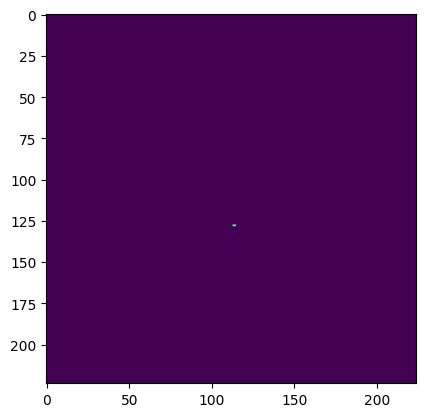

In [42]:
plt.imshow(np.array(vlabels[3][0].cpu()))

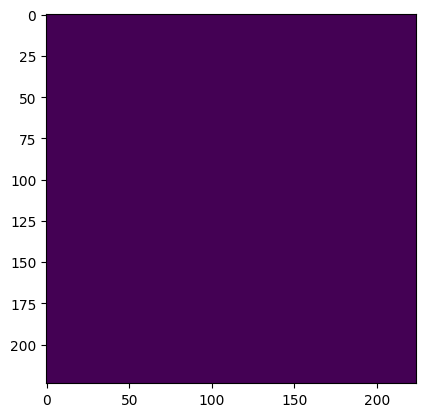

In [43]:
plt.imshow(np.array(voutputs[3][0].cpu()))

In [25]:
running_vloss = 0.0
acc = 0.0
iou = 0.0
loss_fn = WeightedBinaryCrossEntropyLoss(pos_weight=50., neg_weight=1.)
model.eval()

with torch.no_grad():
    for i, vdata in enumerate(train_dataloader):
        vinputs, vlabels = vdata
        voutputs = torch.tensor(np.full(vlabels.shape, -5.))
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        vinputs, vlabels, voutputs = vinputs.to(device), vlabels.to(device), voutputs.to(device)
        vloss = loss_fn(voutputs, vlabels)
        voutputs = torch.round(torch.sigmoid(voutputs))
        running_vloss += vloss
        acc += accuracy(voutputs, vlabels) / vinputs.shape[0]
        iou += IOU(voutputs, vlabels) / vinputs.shape[0]

avg_vloss = running_vloss / (i + 1)
avg_acc = acc / (i + 1)
avg_iou = iou / (i + 1)
print('LOSS valid {}'.format(avg_vloss))
print('Average Accuracy valid {}'.format(avg_acc))
print('Average IOU valid {}'.format(avg_iou))

LOSS valid 1.1040111780166626
Average Accuracy valid 0.24890414083132661
Average IOU valid 0.0


In [55]:
torch.nonzero(voutputs == 1)

tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64)

In [ ]:
voutputs()

In [ ]:
class UNetMobileNetV2fixed(nn.Module):
    """
    U-Net architecture with a fixed MobileNetV2 encoder for image segmentation.

    Args:
    - num_classes (int): Number of output channels/classes for segmentation. Default is 1.

    Attributes:
    - encoder (nn.Module): MobileNetV2 pretrained feature extractor.
    - encoder_layers (list): List of encoder layers for skip connections.
    - classifier (nn.Sequential): Classifier module for the decoder.
    - upsample (nn.Upsample): Upsampling layer.

    Methods:
    - forward(x): Forward pass through the network
    """
    def __init__(self, num_classes=1):
        super(UNetMobileNetV2fixed, self).__init__()

        self.encoder = models.mobilenet_v2(weights='DEFAULT').features

        ## Steps where we will extract the outputs for skip connections, can be changed
        self.encoder_layers = [
            self.encoder[0:2],
            self.encoder[2:4],
            self.encoder[4:7],
            self.encoder[7:14],
            self.encoder[14:19],
            self.encoder[19:24],
            self.encoder[24:],
        ]

        ## The classifier part can be changed; it probably needs to be more complex when the parameters of the pretrained model are fixed
        self.classifier = nn.Sequential(
            nn.Conv2d(320, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, num_classes, height, width).
        """
        # Encoder
        skips = []
        for layer in self.encoder_layers:
            x = layer(x)
            skips.append(x)

        # Decoder
        x = skips[-1]
        for i, skip in enumerate(reversed(skips[:-1])):
            if i > 1:
                x = self.upsample(x)
            x = torch.cat((x, skip), dim=1)

        ## Classifier
        x = self.classifier(x)

        return x


In [ ]:
model = UNetMobileNetV2fixed()

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch
from torch.utils.data import TensorDataset, DataLoader

c:\Users\PC\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
from models import UNetMobileNetV2fixed

In [ ]:
a = UNetMobileNetV2fixed

In [ ]:
b = a()

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
b.encoder

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [ ]:
def filterDataset(folder, classes, annpath, mode, ):    
    # initialize COCO api for instance annotations
    annFile = annpath.format(folder, mode)
    coco = COCO(annFile)
    images = []
    for className in classes:
        # get all images containing given categories
        catIds = coco.getCatIds(catNms=className)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    
    return unique_images, coco

In [ ]:
images, coco = filterDataset(folder = './COCOdataset2017', classes=['sports ball'], annpath = '{}/annotations/instances_{}2017.json', mode='val')

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [ ]:
len(images)

169

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  


def getTensors(images, classes, coco, folder, mode, input_image_size):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    X = []
    y = []
    for i in range(dataset_size):
        imageObj = images[i]
            
        ### Retrieve Image ###
        img = getImage(imageObj, img_folder, input_image_size)
        img = np.resize(img, (3, input_image_size[0], input_image_size[1]))
        X.append(img)

        ### Create Mask ###
        mask = getMask(imageObj, classes, coco, catIds, input_image_size)
        mask = np.resize(mask, (1, input_image_size[0], input_image_size[1]))
        y.append(mask)
        
    X = torch.Tensor(X)
    y = torch.Tensor(y)
    
    return X, y

In [ ]:
X, y = getTensors(images = images, classes=['sports ball'], coco = coco, folder = './COCOdataset2017', mode ='val', input_image_size=(224,224))

In [ ]:
y[48].shape

torch.Size([1, 224, 224])

In [ ]:
def AugmentData(X, y, p = 0.5, input_image_size=(224,224)):

    n = len(X)
    for i in range(n):
        image = X[i]
        mask = y[i]

        for k in range(3):
            if random.random() < p:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            if random.random() < p:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            
            if random.random() < p:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            
            if random.random() < p:
                image = v2.ColorJitter(brightness=random.random())(image)

            if random.random() < p:
                noise = torch.randn(image.size())*0.3 + 0.5
                image = image + noise
                image = v2.ColorJitter(brightness=random.random())(image)
        
            X = torch.cat((X,image.unsqueeze(0)),0)
            y = torch.cat((y,mask.unsqueeze(0)),0)

    return X, y


In [ ]:
X, y = AugmentData(X, y)

In [ ]:
X.shape

torch.Size([676, 3, 224, 224])

In [ ]:
y.shape

torch.Size([676, 1, 224, 224])